# Предсказание автивности покупателей

**Проект:**

В распоряжении имеется информация по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков.
В них есть обезличенная история покупок клиентов за определенный период

**Цель:**

Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней.

**Данные**

- `marketplace` - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;
- `apparel` - магазин одежды, по характеристикам похожий на маркетплейс;
- `gifts` – магазин подарков, очень маленький.

Поля в данных идентичные:

- `client_id` – идентификатор клиента;
- `quantity` – количество товара в заказе;
- `price` – цена 1 единицы товара в заказе;
- `date` – дата покупки.

&copy; by Копцев Андрей [<img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Telegram_logo.svg" alt="Telegram" width="17"/>](https://t.me/Andrei_VK_1980)

## Импорты

In [1]:
# системные модули
import gc
import os
import sys
import time
import magic
import warnings
from functools import wraps
# обработка данных и визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
# оформление выводов
from colorama import Back, Fore, Style
# корреляция
import phik
from phik.report import plot_correlation_matrix
# статистики
from scipy.stats import kurtosis, skew
# разбиение на выборки, кроссвалидация и масштабирование
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, StandardScaler, OneHotEncoder
# модели
from lightgbm import LGBMClassifier
# метрики
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
# подбор гиперпараметров
import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
# отбор признаков
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# балансировка
from crucio import SMOTENC, SMOTETOMEK

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 200)

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

**Переменные**

In [2]:
RANDOM = 12345
# рабочая директория проекта
WORK_DIR = os.path.abspath(os.curdir)
# директория c датасетами
DATA_DIR = os.path.join(WORK_DIR, "datasets")
# файлы с данными для датасетов
APPAREL_FILE = "apparel-purchases.csv"
GIFTS_FILE = "gifts-purchases.csv"
MARKETPLACE_FILE = "marketplace-purchases.csv"

## Классы для реализации проекта

### Временной декоратор `TimeitDecorator`

Для подстета времени выполнения методов обработки и моделирования, можно использовать временной декоратор реализованный в виде класса `TimeitDecorator`.

In [3]:
class TimeitDecorator:
    """
    Класс для декоратора, который измеряет время выполнения функции.
    """

    def timeit(func):
        """
        Декоратор, который измеряет время выполнения функции.

        Параметры:
        - func: функция, для которой измеряется время выполнения

        Возвращает:
        - wrapper: обертка, которая измеряет время выполнения функции
        """

        @wraps(func)
        def wrapper(*args, **kwargs):
            """
            Обертка, которая измеряет время выполнения функции.

            Параметры:
            - args: позиционные аргументы функции
            - kwargs: именованные аргументы функции

            Возвращает:
            - result: результат выполнения функции
            """
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Время выполнения: {round(end_time - start_time, 2)} секунд(ы){Style.RESET_ALL}"
            )

            return result

        return wrapper

### Загрузка датафрейма из файла. Класс: `GetDataframe`

Данный класс обеспечивает создание датасета из файла, выводит информацию по датафрему и количество пропсков.

In [4]:
class GetDataframe:
    """
    Класс для работы с датасетами.

    Методы класса:
    - get_dataframe_from_feather : метод создает датасет из файла формата feather.
    - get_dataframe_info: метод выводит информацию о датасете и пропущенных значениях.
    - is_accessible (staticmethod): статический метод для проверки доступности файлов в режиме чтения.
    - check_type (staticmethod): статический метод для типа переменной на строковое значение и ненулевую длину.
    - get_file_type (staticmethod): статический метод определяет MIME тип файла.
    - load_dataset (staticmethod): статический метод создает датасет методо пандас на основе MIME типа файла.
    """

    def __init__(self, data_dir):
        """
        Конструктор класса GetDataframe.

        Параметры:
        - data_dir (str): директория с данными для датасета.
        """
        self.data_dir = data_dir

    @staticmethod
    def is_accessible(file, data_dir, mode="r"):
        """
        Статический метод is_accessible класса GetDataframe.
        Проверка, является ли файл в рабочей директории доступным для работы в предоставленном режиме.

        Параметры:
        - file (str): файл с данными для датасета,
        - data_dir (str): рабочая директория с файлами для датасета,
        - mode (str): режим доступа к файлу, по умолчанию 'r' - чтение.

        Возвращает:
        - Boolean: True или False.
        """
        try:
            f = open(os.path.join(data_dir, file), mode)
            f.close()
        except IOError:
            return False
        return True

    @staticmethod
    def check_type(file_to_check):
        """
        Статический метод check_type класса GetDataframe.
        Проверяет тип переменной на строковое значение и ненулевую длину.

        Параметры:
        - file_to_check: переменная для проверки.

        Возвращает:
        - Boolean: True если проверка пройдена.
        """
        if not isinstance(file_to_check, str):
            raise TypeError(f"Тип переменной должен быть str. Датасет не будет создан.")
        if len(file_to_check) == 0:
            raise ValueError(
                f"Имя файла не должно быть пустым. Датасет не будет создан."
            )
        else:
            return True

    @staticmethod
    def get_file_type(file):
        """
        Статический метод check_type класса GetDataframe.
        Определяет MIME тип файла.
        (требуется установка библиотеки python-magic)

        Параметры:
        - file (str): имя файла для определения типа файла.

        Возвращает:
        - file_mime_type (str): MIME тип файла
           (https://wp-kama.ru/id_8643/spisok-rasshirenij-fajlov-i-ih-mime-tipov.html).
        """
        # создаем объект Magic, который позволяет определять тип файла. Параметр mime=True
        # указывает, что необходимо получить не просто описание типа файла, а именно его MIME-тип.
        mime = magic.Magic(mime=True)
        # используем метод from_file для определения MIME-типа файла,
        # этот метод анализирует файл и возвращает его MIME-тип на основе содержимого.
        file_mime_type = mime.from_file(file)

        return file_mime_type

    @staticmethod
    def load_dataset(file_dir, file, **kwargs):
        """
        Статический load_dataset класса GetDataframe.
        Создает датасет методо пандас на основе MIME типа файла.

        Параметры
        - file_dir (str): пусть к файлу.
        - file (str): имя файла для датасета.
        - **kwargs: дополнительные именованные аргументы для передачи в pd.read_csv().

        Возвращает:
        - dataset (pd.Dataframe): созданный датасет или инфо о невозможности создания датасета.
        """

        # статическим методом get_file_type получам MIME тип файла
        file_mime_type = GetDataframe.get_file_type(os.path.join(file_dir, file))
        # оператором match принимаем тип файла file_mime_type для дальнейшего сравнения
        match file_mime_type:
            # проверяем условие на text или csv, если True, то используем read_csv
            case "text/csv":
                return pd.read_csv(os.path.join(file_dir, file), **kwargs)
            # проверяем условие на xls или xlsx, если True, то используем read_excel
            case "application/vnd.ms-excel" | "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet":
                return pd.read_excel(os.path.join(file_dir, file), **kwargs)
            # проверяем условие на json, если True, то используем read_json
            case "application/json":
                return pd.read_json(os.path.join(file_dir, file), **kwargs)
            # проверяем условие на html, если True, то используем read_html
            case "text/html":
                return pd.read_html(os.path.join(file_dir, file), **kwargs)
            # проверяем условие для feather или parquet, у них тип octet-stream
            case "application/octet-stream":
                # далее принимаем само имя файла
                match file:
                    # если в расширении feather то используем read_feather
                    case _ if file.endswith(".feather"):
                        return pd.read_feather(os.path.join(file_dir, file), **kwargs)
                    # если в расширении parquet то используем read_parquet
                    case _ if file.endswith(".parquet"):
                        return pd.read_parquet(os.path.join(file_dir, file), **kwargs)
                    # если нету нужного расширения
                    case _:
                        return f"Неподдерживаемый формат файла"
            # если нету нужного типа файла
            case _:
                return f"Неподдерживаемый формат файла"

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_dataframe_from_file(self, file=None, **kwargs):
        """
        Создает датасет из файла.
        Для вывода информации требуется пакет colorama,

        Параметры:
        - file (str): имя файла для создания датасета.
        - **kwargs: дополнительные именованные аргументы для передачи в pd.read_csv().
          (передаются в виде словаря, например: additional_args = {'sep': ';'}, как
           **additional_args)

        Возвращает:
        - dataset (pd.Dataframe): созданный датасет.
        """
        # вызов статического метода проверки типа переменной
        check_file = GetDataframe.check_type(file)
        # вызов статического метода проверки читаемости файла
        flag = GetDataframe.is_accessible(file, self.data_dir)
        # если оба True
        if all([check_file, flag]):
            # создаем датасет
            print(
                f"{Fore.RED}{Style.BRIGHT}Создаем датасет из файла {file}.{Style.RESET_ALL}"
            )
            # вызов статического метода load_dataset
            dataset = GetDataframe.load_dataset(self.data_dir, file, **kwargs)
            # присваиваем имя датасету в соответсвии с именем файла
            dataset.name = re.findall("(\w+)\-", file)[0]
            print(f"{Fore.GREEN}{Style.BRIGHT}Датасет создан!{Style.RESET_ALL}")
            return dataset
        # в противном случай вызываем ошибку
        else:
            raise ValueError(f"Файл {file} не найден в директории {self.data_dir}.")

    def get_dataframe_info(self, dataset=None, info=True, miss_values=True):
        """
        Выводит информацию о датасете и пропущенных значениях.

        Параметры:
        - dataset: датасет для анализа,
        - info (bool): выводить информацию о датасете (по умолчанию True),
        - miss_values (bool): выводить информацию о пропущенных значениях (по умолчанию True).
        """
        # если выбран флаг info, выводим информацию о датасете
        if info:
            print(
                f"{Fore.RED}{Style.BRIGHT}Общая информация по датасету{Style.RESET_ALL}"
            )
            dataset.info()
            print()
        # если выбран флаг miss_values, считаем пропуски в столбцах
        if miss_values:
            percentage_missing = (dataset.isna().sum() / len(dataset)) * 100
            dataset_miss = pd.DataFrame({"percent_missing": percentage_missing})
            dataset_miss = dataset_miss.loc[dataset_miss["percent_missing"] > 0]
            # если в датасете нету пропусков
            if len(dataset_miss) == 0:
                print(
                    f"{Fore.GREEN}{Style.BRIGHT}В датасете нет пропущенных значений.{Style.RESET_ALL}"
                )
            # если они есть
            else:
                print(
                    f"{Fore.RED}{Style.BRIGHT}Столбцы с пропущенными значениями:{Style.RESET_ALL}"
                )
                display(dataset_miss)

### Обработка датасета и создание новых признаков. Класс: `Preprocessor`

В наличии имеются три датасета: `marketplace`, `apparel` и `gifts`.

Столбцы у датасетов идентичные. 

Для генерации новых признаков будут использованы по сути два признка:
- `date` – дата покупки.
- `quantity` – количество товара в заказе умноженная на `price` – цена 1 единицы товара в заказе.

За основу взята статическая модель, которая будет реализована след. образом:
- датасет сортируется по дате в порядке возрастания.
- для выделения тагрета берется срез в 30 дней от конечной даты. Клиенты, попавшие в этот срез помечаются как `target` = 1.
- для генерации признаков будет взята часть датасета, в которую не входят эти 30 дней.
- после генерации признаков датасеты объединяются и клиенты, не попавшие в таргет, помечаются как `target` = 0.

**Генерация признаков.**

На основании существующих признаков, будут сгенерированы следующие:
- `total_sum_position` - сумма по позиции для каждого товара (`quantity` * `price`);
- `activity_duration` - длительность активности: количество дней между первой и последней транзакциями для каждого клиента;
- `last_transaction_ratio` - доля последней покупки в общем перечне покупок;
- `recency` - давность последней покуки;
- `first_recency` - давность первой покупки;
- `frequency` - частота покупок;
- `min_cost_per_position` - минимальная цена за товар;
- `max_cost_per_position` - максимальная цена за товар;
- `monetary_value` - общая потраченная сумма;
- `monetary_value_avg` - средняя потраченная сумма за покупку;
- `avg_recency` - средняя давность между покупками;
- `rfm` - RFM-сегментация клиента.

В данном проекте RFM-сегментация будет выполнена по четырем квартилям.
(https://habr.com/ru/companies/otus/articles/666862/)

Сгенерированные признаки не затронут тестовый период, и не будет накопительной статистики, смотрящей в будущее, а соответвенно утечки.
Все вышеперечисленное реализуется методом `preprocess_dataset`.

Так как датасеты очень маленькие и имеют срез всего в год мною было принято решение объединить три датасета в один для с выделением доп. столбца `shop` (сделать своего рода единый магазин с различными отделами):
- `gifts` будет закодирован как `1`;
- `apparel` будет закодирован как `2`;
- `marketplace` будет закодирован как `3`;

Для объединения будет использован метод `preprocess_dataset`.

Помимо этого в классе есть метод `feature_generation` для отдельной генерации фичей, для возможного повышения влияния на целевую переменную.

In [5]:
class Preprocessor:
    """
    Класс для предобработки датасета.

    Методы класса:
    - preprocess_dataset : метод для обработки датасетов генерации признаков.
    - concat_dataset: метод для объединения датасетов.
    - feature_generation: метод для генерации признаков.
    - optim_mem_types (staticmethod): статический метод оптимизатор памяти.
    """

    def __init__(self):
        """
        Конструктор класса Preprocessor.
        """
        pass

    @staticmethod
    def optim_mem_types(dataset):
        """
        Статический метод optim_mem_types класса DatasetPreprocessor.
        Перебирает все столбцы датафрейма и изменяет тип данных, чтобы
        уменьшить использование памяти.
        Параметры:
        - dataset (pd.DataFrame): исходный датасет.

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """

        print(
            f"{Fore.YELLOW}{Style.BRIGHT}Оптимизация типов и памяти.{Style.RESET_ALL}"
        )
        # глубокая копия датасета
        dataset_opt = dataset.copy(deep=True)
        # подсчет начального объема датасета
        start_mem = round(dataset_opt.memory_usage().sum() / 1024**2, 4)
        print(
            f"{Fore.BLACK}{Style.BRIGHT}Память занимаемая датасетом в ОП до обработки: {start_mem} MB.{Style.RESET_ALL}"
        )
        # цикл по колонкам в датасете
        for col in dataset_opt.columns:
            # проверка на то, что столбец числовой
            if dataset_opt[col].dtype.name not in ["object", "category", "datetime"]:
                # проверка на то, что в типе float после запятой только нули
                if dataset_opt[col].dtype.name[:5].lower() == "float":
                    # создаем временный датасет без пропусков
                    tmp = dataset_opt.loc[dataset_opt[col].notna()]
                    # список с масками, что после запятой нули
                    decimal_check = (tmp[col] % 1 == 0).tolist()
                    # если все значения списка True
                    if all(decimal_check):
                        # то переводи в тип Int64, который не критичен к nan
                        dataset_opt[col] = dataset_opt[col].astype("Int64")
                    # удаляем промежуточный датасет
                    del tmp
                # минимум и максимум в столбце
                c_min = dataset_opt[col].min()
                c_max = dataset_opt[col].max()
                #  проверка на тип int
                if dataset_opt[col].dtype.name[:3].lower() == "int":
                    # если тип int, то присваиваются значения в зависимости от диапазона от min до max
                    if (
                        c_min >= np.iinfo(np.int8).min
                        and c_max <= np.iinfo(np.int8).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int8)
                    elif (
                        c_min >= np.iinfo(np.int16).min
                        and c_max <= np.iinfo(np.int16).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int16)
                    elif (
                        c_min >= np.iinfo(np.int32).min
                        and c_max <= np.iinfo(np.int32).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int32)
                    elif (
                        c_min >= np.iinfo(np.int64).min
                        and c_max <= np.iinfo(np.int64).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.int64)
                # # если тип float, то присваиваются значения в зависимости от диапазона от min до max
                else:
                    if (
                        c_min >= np.finfo(np.float16).min
                        and c_max <= np.finfo(np.float16).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.float16)
                    elif (
                        c_min >= np.finfo(np.float32).min
                        and c_max <= np.finfo(np.float32).max
                    ):
                        dataset_opt[col] = dataset_opt[col].astype(np.float32)
                    else:
                        dataset_opt[col] = dataset_opt[col].astype(np.float64)
            # если тип не дата, то оставшиеся столбцы в тип object
            elif "datetime" not in dataset[col].dtype.name:
                dataset_opt[col] = dataset_opt[col].astype("object")

        # новый объем датасета и возможная экономия в процентах
        end_mem = round(dataset_opt.memory_usage().sum() / 1024**2, 4)
        economy = round(100 * (start_mem - end_mem) / start_mem, 2)
        print(
            f"{Fore.BLACK}{Style.BRIGHT}Память занимаемая датасетом в ОП после обработки: {end_mem} MB.{Style.RESET_ALL}"
        )

        print(f"{Fore.GREEN}{Style.BRIGHT}Экономия {economy}%.{Style.RESET_ALL}")
        # если удалось оптимизировать
        if start_mem - end_mem >= 0:
            print(
                f"{Fore.GREEN}{Style.BRIGHT}Удалось оптимизировать типы и память или выйти по нулям.{Style.RESET_ALL}"
            )
            # сбока мусора
            gc.collect()
            return dataset_opt
        # в противном случае
        else:
            print(
                f"{Fore.RED}{Style.BRIGHT}Не удалось оптимизировать типы и память, оставляем исходный датасет.{Style.RESET_ALL}"
            )
            # сбока мусора
            del dataset_opt
            gc.collect()
            return dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def preprocess_dataset(self, dataset=None):
        """
        Метод preprocess_dataset класса Preprocessor.
        Метод обрабатывает датасет и генерирует новые признаки.

        Параметры:
        - dataset (pd.DataFrame): исходный датасет.

        Возвращает:
        - dataset (pd.DataFrame): обработанный датасет.
        """

        # завват имени датасета
        match dataset.name:
            # если это "gifts" или "apparel"
            case "gifts" | "apparel":
                # сохраняем имя датасета в переменную
                dataset_name = dataset.name
                # оставляем в датасете только столбцы "client_id", "quantity", "price", "date"
                dataset = dataset[["client_id", "quantity", "price", "date"]]
            # если это marketplace
            case "marketplace":
                # сохраняем имя датасета в переменную
                dataset_name = dataset.name
                # оставляем в датасете только столбцы "client_id", "quantity", "price", "created_at"
                dataset = dataset[["client_id", "quantity", "price", "created_at"]]
                # переименовываем "created_at" в "date"
                dataset = dataset.rename(columns={"created_at": "date"})
            # в противном случае
            case _:
                return f"{Fore.RED}{Style.BRIGHT}Нету датасета для обработки{Style.RESET_ALL}"
        # преобразуем в тип datetime
        dataset["date"] = pd.to_datetime(dataset["date"])
        # сортируем по дате
        dataset = dataset.sort_values(by="date").reset_index(drop=True)
        # форматируем явно вибивающееся значение цены за единицу
        dataset.loc[dataset["price"] > 1000000, "price"] = dataset["price"] / 10
        # сумма по позиции
        dataset["total_sum_position"] = dataset["quantity"] * dataset["price"]
        # конечная дата датасета
        end_date_dataset = dataset["date"].max()
        # дата для отсечения теста - разница в 30 дней
        date_for_test = end_date_dataset - pd.Timedelta(days=30)
        # датасет для генерации признаков с датой до теста
        train_data = dataset[dataset["date"] < date_for_test]
        # датасет для выделения таргета с тестовым периодом в 30 дней
        test_data = dataset[dataset["date"] >= date_for_test]
        # ставим таргет как 1  в тестовых данных
        test_data = test_data.assign(target=1)
        # оставляем только "client_id" и "target"
        test_data = test_data.loc[:, ["client_id", "target"]]
        # удаляем дубликаты, т.к. нам не интересно сколько покупок в тесте, нам важно наличие покупки
        test_data = test_data.drop_duplicates()
        #  длительность активности: количество дней между первой и последней транзакциями для каждого клиента.
        train_data["activity_duration"] = (
            train_data.groupby("client_id")["date"].transform("max")
            - train_data.groupby("client_id")["date"].transform("min")
        ).dt.days
        # доля последней покупки в общем перечне покупок
        train_data["last_transaction_ratio"] = train_data.groupby("client_id")[
            "total_sum_position"
        ].transform("last") / train_data.groupby("client_id")[
            "total_sum_position"
        ].transform(
            "sum"
        )
        # агрегированные метрики
        train_data_agg = (
            train_data.groupby("client_id")
            .agg(
                **{
                    # давность последней покуки
                    "recency": ("date", lambda x: (date_for_test - x.max()).days),
                    # давность первой покупки
                    "first_recency": ("date", lambda x: (date_for_test - x.min()).days),
                    # частота покупок
                    "frequency": ("date", lambda x: x.nunique()),
                    # минимальная цена за товар
                    "min_cost_per_position": ("price", lambda x: x.min()),
                    # максимальная цена за товар
                    "max_cost_per_position": ("price", lambda x: x.max()),
                    # общая потраченная сумма
                    "monetary_value": ("total_sum_position", lambda x: x.sum()),
                    # средняя потраченная сумма
                    "monetary_value_avg": ("total_sum_position", lambda x: x.mean()),
                    # длительность активности
                    "activity_duration": ("activity_duration", lambda x: x.max()),
                    # доля последней покупки
                    "last_transaction_ratio": (
                        "last_transaction_ratio",
                        lambda x: x.mean(),
                    ),
                }
            )
            .reset_index()
        )
        # средняя давность между покупками
        train_data_agg["avg_recency"] = (
            train_data_agg["first_recency"] - train_data_agg["recency"]
        ) / train_data_agg["frequency"]

        # сегментация клиента по давности, частоте и сумме покупок
        rfm_segment = train_data_agg.groupby("client_id").agg(
            {
                "recency": lambda x: x,
                "frequency": lambda x: x,
                "monetary_value": lambda x: x,
            }
        )

        # словарь с квартилями для четырех равных частей на основе доступных значений
        quantiles = rfm_segment.quantile(q=[0.25, 0.5, 0.75]).to_dict()
        # RFM сегментация
        # лямбда функция для получения r части сегмента
        # x = значение, p = recency, d = словарь с квартилями
        r_class_lambda = (
            lambda x, p, d: 4
            if x <= d[p][0.25]
            else (3 if x <= d[p][0.5] else (2 if x <= d[p][0.75] else 1))
        )
        # лямбда функция для получения f или m части сегмента
        # x = значение, p = recency или monetary value, d = словарь с квартилями
        fm_class_lambda = (
            lambda x, p, d: 1
            if x <= d[p][0.25]
            else (2 if x <= d[p][0.5] else (3 if x <= d[p][0.75] else 4))
        )
        # получаем r сегмент применяя r_class_lambda к столбцу "recency"
        rfm_segment["r_quartile"] = rfm_segment["recency"].apply(
            lambda x: r_class_lambda(x, "recency", quantiles)
        )
        # получаем f сегмент применяя fm_class_lambda к столбцу "frequency"
        rfm_segment["f_quartile"] = rfm_segment["frequency"].apply(
            lambda x: fm_class_lambda(x, "frequency", quantiles)
        )
        # получаем m сегмент применяя fm_class_lambda к столбцу "monetary_value"
        rfm_segment["m_quartile"] = rfm_segment["monetary_value"].apply(
            lambda x: fm_class_lambda(x, "monetary_value", quantiles)
        )
        # объединяем r, f, m в одно значение
        rfm_segment["rfm"] = (
            rfm_segment["r_quartile"].astype(str)
            + rfm_segment["f_quartile"].astype(str)
            + rfm_segment["m_quartile"].astype(str)
        )
        # переводим в тип "int"
        rfm_segment["rfm"] = rfm_segment["rfm"].astype("int")
        # сброс индексов
        rfm_segment = rfm_segment.reset_index()
        # оставляем только "client_id" и "rfm"
        rfm_segment = rfm_segment[["client_id", "rfm"]]
        # объединяем в train_data по "client_id"
        train_data_agg = train_data_agg.merge(rfm_segment, on="client_id", how="left")
        # объединяем с тест данными с таргетом по "client_id" и заполяем пустой таргет нулем
        dataset = train_data_agg.merge(test_data, on="client_id", how="left").fillna(0)
        # меняем тип "client_id" на "object"
        dataset["client_id"] = dataset["client_id"].astype("object")
        # вызов статик метода для оптимизации типов данный
        dataset = Preprocessor.optim_mem_types(dataset)
        # возвращаем имя каждому датасету
        dataset.name = dataset_name if "dataset_name" in locals() else dataset.name
        # очистка памяти
        del end_date_dataset, date_for_test, train_data, test_data, train_data_agg
        gc.collect()

        return dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def concat_dataset(self, dataset_lst=None):
        """
        Метод concat_dataset класса Preprocessor.
        Метод объединяет датасеты в один.

        Параметры:
        - dataset_lst (list): список с датасетами (по умолчанию None).

        Возвращает:
        - final_dataset (pd.DataFrame): обработанный датасет.
        """

        # цикл по списку с датасетами
        for dataset in dataset_lst:
            # захват имени датасета
            match dataset.name:
                # если "gifts", то добавляем магазин с номером 1
                case "gifts":
                    dataset_gifts = dataset.copy(deep=True)
                    dataset_gifts["shop"] = 1
                # если "apparel", то добавляем магазин с номером 2
                case "apparel":
                    dataset_apparel = dataset.copy(deep=True)
                    dataset_apparel["shop"] = 2
                # если "marketplace", то добавляем магазин с номером 3
                case "marketplace":
                    dataset_marketplace = dataset.copy(deep=True)
                    dataset_marketplace["shop"] = 3
                # в противном случае
                case _:
                    return f"Нету датасета для обработки"
        # объединяем три датасета
        final_dataset = pd.concat(
            [dataset_gifts, dataset_apparel, dataset_marketplace], axis=0
        )
        # категоризируем столбцы "shop" и "rfm"
        final_dataset[["shop", "rfm"]] = final_dataset[["shop", "rfm"]].astype(
            "category"
        )
        # очистка памяти
        del dataset_gifts, dataset_apparel, dataset_marketplace
        gc.collect()

        return final_dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def feature_generation(self, dataset=None, target_col=None):
        """
        Метод feature_generation класса Preprocessor.
        Метод генерирует признаки.

        Параметры:
        - dataset (pd.DataFrame): исходный датасет (по умолчанию None).
        - target_col (str): столбец с таргетом (по умолчанию None).

        Возвращает:
        - dataset (pd.DataFrame): датасет с признаками.
        """

        # выделяем числовые столбцы
        num_cols = dataset.select_dtypes(include=np.number).columns.tolist()
        # делаем тип np.float64 для всех числовых столбцов, чтобы не было значений inf
        dataset[num_cols] = dataset[num_cols].astype(np.float64)
        # цикл по столбцам
        for col in num_cols:
            # проверка, что столбец не таргет
            if col != target_col:
                # имена новых столбцов с кавадратом, кубом и логарифмом
                square_name = f"{col}_square"
                qube_name = f"{col}_qube"
                log_name = f"{col}_log"
                # возведение в квадрат и куб
                dataset[square_name] = dataset[col] ** 2
                dataset[qube_name] = dataset[col] ** 3
                # логарифм
                if dataset[col].min() > 0:
                    dataset[log_name] = np.log(dataset[col])
                else:
                    dataset[log_name] = np.log(dataset[col] + 1)

        return dataset

### EDA. Класс: `CustomEDA`

Класс для разведочного анализа данных.

Методы класса:
- `custom_describe`: cоздает кастомную описательную статистику для числовых признаков в датасете.
- `hist_and_box`: метод для отображения гистограмм и ящиков с усами для числовых признаков датасета.
- `target_countplot`: метод для построения `barplot'а` для подсчета баланса целевого признака.
- `phik_correlation`: метод для вычисления и визуализации корреляции `Phik` между признаками.
- `pairplot`: метод для построения `pairplot` между числовыми признаками.


In [6]:
class CustomEDA:
    """
    Класс для кастомного Exploratory Data Analysis (EDA).

    Методы класса:
    - custom_describe: cоздает кастомную описательную статистику для числовых признаков в датасете.
    - hist_and_box: метод для отображения гистограмм и ящиков с усами для числовых признаков датасета.
    - target_countplot: метод для построения barplot'а для подсчета баланса целевого признака.
    - phik_correlation: метод для вычисления и визуализации корреляции Phik между признаками.
    - pairplot: метод для построения pairplot между числовыми признаками.
    - color_negative_red (staticmethod): статический метод  для определения цвета текста в зависимости от значения.
    """

    def __init__(self):
        """
        Конструктор класса CustomEDA.
        """
        pass

    @staticmethod
    def color_negative_red(value):
        """
        Статический метод color_negative_red класса CustomEDA.
        Метод для определения цвета текста в зависимости от значения. Отрицательные значения - красный, положительные - зеленый, ноль - белый.

        Параметры:
        - value (float): значение, для которого необходимо определить цвет.

        Возвращает:
            str: CSS стиль для цвета текста.
        """
        if float(value) < 0:
            color = "#ff0000"  # касный цвет
        elif float(value) > 0:
            color = "#00ff00"  # зеленый цвет
        else:
            color = "#FFFFFF"  # Белый цвет

        return "color: %s" % color

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def custom_describe(self, dataset=None):
        """
        Метод custom_describe класса CustomEDA.
        Метод для создания кастомной описательной статистики для числовых признаков в датасете.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).

        Возвращает:
        - Нету возвращаемого значения.
        """

        # вычисление статистик для числовых признаков
        print(f"{Fore.BLUE}{Style.BRIGHT}Описательная статистика.{Style.RESET_ALL}")
        print()
        num_cols = dataset.select_dtypes(include=np.number).columns.tolist()
        summary_data = pd.DataFrame(
            {
                col: dataset[col].agg(
                    [
                        lambda x: x.count(),
                        lambda x: x.values.mean(),
                        lambda x: x.median(),
                        lambda x: x.values.std(),
                        lambda x: x.min(),
                        lambda x: x.quantile(0.25),
                        lambda x: x.median(),
                        lambda x: x.quantile(0.75),
                        lambda x: x.max(),
                    ]
                )
                for col in num_cols
            }
        )
        # транспонируем датафрейм
        summary_data = summary_data.T
        # рассчет асимметрии и эксцесса числовых признаков
        skew_ = (
            dataset._get_numeric_data()
            .dropna()
            .apply(lambda x: skew(x))
            .to_frame(name="skewness")
        )
        kurt_ = (
            dataset._get_numeric_data()
            .dropna()
            .apply(lambda x: kurtosis(x))
            .to_frame(name="kurtosis")
        )
        skew_kurt = pd.concat([skew_, kurt_], axis=1)
        # объединяем в единый датасет
        summary_data = pd.concat([summary_data, skew_kurt], ignore_index=True, axis=1)
        # названия столбцов
        summary_data.columns = [
            "count",
            "mean",
            "median",
            "std",
            "min",
            "25%",
            "50%",
            "75%",
            "max",
            "skewness",
            "kurtosis",
        ]
        # формат вывода значений столбцов
        summary_data = summary_data.applymap(lambda x: "{:.2f}".format(x))
        # асимметрия и эксцесс в отдельный список для выделения цветов при помощи статического метода color_negative_red
        info_cols = ["skewness", "kurtosis"]
        display(
            summary_data.style.background_gradient(
                cmap="Spectral", subset=summary_data.columns[:-2]
            )
            .applymap(CustomEDA.color_negative_red, subset=info_cols)
            .set_properties(
                **{"background-color": "#000000", "font-weight": "bold"},
                subset=info_cols,
            )
            .set_properties(**{"font-weight": "bold"}, subset=summary_data.columns[:-2])
        )

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def hist_and_box(self, dataset=None, target=None, cols_to_drop=None):
        """
        Метод hist_and_box класса CustomEDA.
        Метод для отображения гистограмм и ящиков с усами для числовых признаков датасета.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).
        - target (str): название целевого признака (по умолчанию None).
        - cols_to_drop

        Возвращает:
        - Нету возвращаемого значения.
        """

        print(
            f"{Fore.YELLOW}{Style.BRIGHT}Гистограммы и ящики с усами.{Style.RESET_ALL}"
        )
        print()
        # создание копии исходного датасета
        data = dataset.copy(deep=True)
        if cols_to_drop is not None:
            data = data.drop(cols_to_drop, axis=1)
        # создание списка числовых признаков и удаление оттуда таргета
        num_cols = data.select_dtypes(include=np.number).columns.tolist()
        num_cols.remove("target")
        # преобразование float16 в float32
        float16_columns = data.columns[data.dtypes == np.float16]
        data[float16_columns] = data[float16_columns].astype(np.float32)
        # построение гистограмм и boxplot'ов для каждой числовой колонки
        for col in num_cols:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            # гистограмма
            ax1.hist(data[col], bins=50, color="skyblue", edgecolor="black")
            ax1.set_xlabel("Значения")
            ax1.set_ylabel("Частота")
            ax1.set_title("Гистограмма")

            box_dict = {
                "boxprops": dict(color="#000000", linewidth=2),
                "capprops": dict(color="#000000", linewidth=1.5),
                "medianprops": dict(color="#000000", linewidth=1.5),
                "whiskerprops": dict(color="#000000", linewidth=1.5),
                "flierprops": dict(markeredgecolor="#ff9900"),
                "meanprops": dict(markeredgecolor="#000000"),
            }
            # построение ящика с усами с использованием параметра hue
            data.boxplot(
                by=target,
                column=[col],
                widths=0.5,
                showmeans=True,
                patch_artist=True,
                vert=False,
                **box_dict,
                ax=ax2,
            )
            ax2.set_xlabel("Данные")
            ax2.set_ylabel("Значения")
            ax2.set_title("Boxplot")

            boxes = ax2.findobj(matplotlib.artist.Artist)
            # цветовая палитра для boxplot'ов в зависимости от типа данных в целевом признаке
            if data[target].dtypes == "O":
                for i, box in enumerate(boxes):
                    if isinstance(box, matplotlib.patches.PathPatch):
                        if i < 3:
                            box.set_facecolor("#ea4b33")
                        if i > 3:
                            box.set_facecolor("#3490d6")
            else:
                for i, box in enumerate(boxes):
                    if isinstance(box, matplotlib.patches.PathPatch):
                        if i < 3:
                            box.set_facecolor("#3490d6")
                        if i > 3:
                            box.set_facecolor("#ea4b33")

            fig.suptitle(f"Гистограмма и ящик с усами для {col}", size=20, y=1.02)

            # Отображение графика
            plt.show()

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def target_countplot(self, dataset=None):
        """
        Метод target_countplot класса CustomEDA.
        Метод для построения barplot'а для подсчета баланса целевого признака.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).

        Возвращает:
        - Нету возвращаемого значения.
        """

        print(f"{Fore.GREEN}{Style.BRIGHT}Баланс целевого признака{Style.RESET_ALL}")
        print()
        # создание графика barplot для целевого признака
        plt.figure(figsize=(9, 5))
        plt.title("Целевой признак", fontsize=18)
        # построение barplot'а
        ax = sns.barplot(
            x=dataset["target"].unique(),
            y=dataset["target"].value_counts(ascending=True, normalize=True).values
            * 100,
            palette=["green", "red"],
        )

        # добавление дополнительной информации к графику
        abs_values = dataset["target"].value_counts(ascending=True)
        rel_values = (
            dataset["target"].value_counts(ascending=True, normalize=True).values * 100
        )
        lbls = [f"{p[0]} ({p[1]:.5f}%)" for p in zip(abs_values, rel_values)]
        ax.bar_label(container=ax.containers[0], labels=lbls)
        plt.xlabel("Оплата заявки", fontsize=15)
        plt.ylabel("Процентное соотношение", fontsize=15)
        plt.xticks(ticks=[0, 1], labels=["Купит", "Не купит"])

        plt.show()

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def phik_correlation(self, dataset=None, cols_to_drop=None, multi_collinear=False):
        """
        Метод phik_correlation класса CustomEDA.
        Метод для вычисления и визуализации корреляции Phik между признаками.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).
        - cols_to_drop (list): список столбцов для удаления (по умолчанию None).
        - multi_collinear (Boolean): флаг для выбора фильтрации признаков в мультиколлинеарностью
                                     (по умолчанию False).

        Возвращает:
        - dataset (pd. Dataframe): датасет с отфильтрованными признаками.
        """
        # копия датасета
        dataset_copy = dataset.copy(deep=True)
        # если есть столбцы для удаления - удаляем
        if cols_to_drop is not None:
            dataset_copy = dataset_copy.drop(cols_to_drop, axis=1)
        # список столбцов
        columns = list(dataset_copy.columns)
        # матрица корреляции
        phik_overview = dataset_copy.phik_matrix(interval_cols=columns)

        # фильтрация мультиколлениарных признаков
        if multi_collinear:
            to_drop = (
                set()
            )  # cоздаем множество для хранения названий признаков, которые нужно удалить
            # в цикле определяем признаки у которых взаимная корреляция больше 0.8 и оставляем тот из них,
            # у которого корреляция с таргетом наибольшая
            for i in range(len(phik_overview.columns)):
                for j in range(i + 1, len(phik_overview.columns)):
                    if abs(phik_overview.iloc[i, j]) > 0.8:
                        feature_i = phik_overview.columns[i]
                        feature_j = phik_overview.columns[j]
                        if (
                            phik_overview.loc[feature_i, "target"]
                            < phik_overview.loc[feature_j, "target"]
                        ):
                            to_drop.add(feature_i)
                        else:
                            to_drop.add(feature_j)
            # удаляем признаки с высокой корреляцией с целевым признаком
            phik_overview = phik_overview.drop(list(to_drop))
            phik_overview = phik_overview.drop(list(to_drop), axis=1)

        # визуализация матрицы корреляции
        plot_correlation_matrix(
            phik_overview.values,
            x_labels=phik_overview.columns,
            y_labels=phik_overview.index,
            vmin=0,
            vmax=1,
            color_map="Greens",
            title=r"Корреляция $\phi_K$",
            fontsize_factor=1,
            figsize=(26, 16),
        )
        plt.tight_layout()
        # обновление датасета с отфильтрованными признаками
        final_cols = list(phik_overview.columns)
        final_cols.extend(cols_to_drop)
        dataset = dataset[final_cols]

        return dataset

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def pairplot(self, dataset=None, cols_to_drop=None, target_col=None):
        """
        Метод pairplot класса CustomEDA.
        Метод для построения pairplot между числовыми признаками.

        Параметры:
        - dataset (pd. Dataframe): исходный датафрейм Pandas (по умолчанию None).
        - cols_to_drop (list): список для удаления категориальных столбцов (по умолчанию None).
        - target_col (str): целевая переменная (по умолчанию None).

        Возвращает:
        - Нету возвращаемого значения.
        """

        print(f"{Fore.GREEN}{Style.BRIGHT}График Pairplot{Style.RESET_ALL}")
        print()
        # выделяем датасет с числовыми признаками
        dataset_num = dataset.drop(cols_to_drop, axis=1)
        # строим pairplot
        sns.pairplot(dataset_num, hue=target_col)
        plt.show()

### Разбиение на выборки: `DataSplitCoder`

При помощи данного класса можно разбить датасет на выборки, масштабировать числовые признаки и закодировать категориальные.

In [7]:
class DataSplitCoder:
    """
    Класс для разбиения датасета на выборки и масштабирования.

    Методы класса:
    - get_coded_data: метод получения масштабированных выборок.
    - data_split (статический метод): статический метод разбивает датасет на выборки.
    """

    def __init__(self):
        """
        Конструктор класса DataSplitCoder.
        """
        pass

    @staticmethod
    def data_split(
        dataset=None,
        target_col=None,
        test_size=None,
        valid=False,
        test_valid_size=0.4,
        report=False,
    ):
        """
        Статический метод data_split класса DataSplitCoder.
        Метод разбивает датасет на выборки.

        Параметры:

        - dataset (pd.DataFrame): датасет с данными (по умолчанию None).
        - target_col (str): целевой признак (по умолчанию None).
        - test_size (float): размер тестовой выборки (по умолчанию None).
        - valid (Boolean): флаг для выбора возможности добавлять валидационную выборку (по умолчанию False).
        - test_valid_size (float): размер тестовой и валидационной выборки (по умолчанию None).
        - report (Boolean): флаг для выбора возможности вывода отчета по разбиению (по умолчанию False).

        Возвращает (результат разбиения на выборки):

        - Если valid=False, возвращаются только трейн и тест:

           features_train, target_train, features_test, target_test

        - Если valid=True, возвращаются трейн, валид и тест:

           features_train, target_train, features_valid, target_valid, features_test, target_test

        """

        # выделение признаков
        features = dataset.drop([target_col], axis=1)
        # выделение целевого признака
        target = dataset[target_col]
        # если нужна валидация - разбиваем на train, valid, test в соотношении 60-20-20
        if valid:
            features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=test_valid_size, random_state=RANDOM
            )
            features_valid, features_test, target_valid, target_test = train_test_split(
                features_test, target_test, test_size=0.5, random_state=RANDOM
            )
            # если True
            if report:
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тренировочная выборка: {Style.RESET_ALL}",
                    features_train.shape,
                    target_train.shape,
                )
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Валидационная выборка: {Style.RESET_ALL}",
                    features_valid.shape,
                    target_valid.shape,
                )
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тестовая выборка: {Style.RESET_ALL}",
                    features_test.shape,
                    target_test.shape,
                )

            return (
                features_train,
                target_train,
                features_valid,
                target_valid,
                features_test,
                target_test,
            )

        # если не нужна валидация - разбиваем на train и test в соотношении 80-20
        else:
            features_train, features_test, target_train, target_test = train_test_split(
                features,
                target,
                test_size=test_size,
                random_state=RANDOM,
                stratify=target,
            )
            # если True
            if report:
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тренировочная выборка: {Style.RESET_ALL}",
                    features_train.shape,
                    target_train.shape,
                )
                print(
                    f"{Fore.BLACK}{Style.BRIGHT}Тестовая выборка: {Style.RESET_ALL}",
                    features_test.shape,
                    target_test.shape,
                )

            return features_train, target_train, features_test, target_test

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_coded_data(
        self,
        dataset=None,
        target_col=None,
        cols_to_drop=None,
        test_size=0.25,
        valid=False,
        test_valid_size=0.4,
        report=False,
        scaler=StandardScaler(),
        one_hot=False,
        cols_to_one_hot=None,
        categorical=False,
        encoder=OrdinalEncoder(),
    ):
        """
        Метод get_coded_data класса DataSplitCoder.
        Метод получения масштабированных выборок.

        Параметры:

        - dataset (pd.DataFrame): датасет с данными (по умолчанию None).
        - target_col (str): целевой признак (по умолчанию None).
        - cols_to_drop (list): список столбцов, которые можно дополнительно удалить (по умолчанию пустой список).
        - test_size (float): размер тестовой выборки (по умолчанию 0.25).
        - valid (Boolean): флаг для выбора возможности добавлять валидационную выборку (по умолчанию False).
        - test_valid_size (float): размер тестовой и валидационной выборки (по умолчанию 0.4).
        - report (Boolean): флаг для выбора возможности вывода отчета по разбиению (по умолчанию False).
        - scaler (class object): скалер для масштабирования числовых признаков (по умолчанию StandardScaler()).
        - one_hot (Boolean): флаг для выбора OHE (по умолчанию False).
        - cols_to_one_hot (list): столбцы для OHE (по умолчанию None).
        - categorical(Boolean): флаг для выбора возможность кодирования категориальных признаков (по умолчанию False).
        - encoder (class object): энкодер для кодирования категориальных признаков (по умолчанию OrdinalEncoder()).


        Возвращает (результат разбиения на выборки):

        - Если valid=False, возвращаются только трейн и тест:

           features_train, target_train, features_test, target_test

        - Если valid=True, возвращаются трейн, валид и тест:

           features_train, target_train, features_valid, target_valid, features_test, target_test

        """
        # вызов метода pd..get_dummies для OHE
        if one_hot:
            # кодируем данные
            one_hot_encoded = pd.get_dummies(
                dataset[cols_to_one_hot], drop_first=True
            ).astype("int")
            # объединение закодированных данных с исходным датафреймом
            dataset = pd.concat([dataset, one_hot_encoded], axis=1)
            # датасет с кодировкой OHE
            dataset = dataset.drop(cols_to_one_hot, axis=1)
        # вызов метода data_split для разбиения на выборки
        # если True, то разбиваем на train, valid и test
        if valid:
            (
                features_train,
                target_train,
                features_valid,
                target_valid,
                features_test,
                target_test,
            ) = DataSplitCoder.data_split(
                dataset,
                target_col=target_col,
                test_size=test_valid_size,
                report=report,
                valid=valid,
            )
        # если False, то разбиваем на train и test
        else:
            (
                features_train,
                target_train,
                features_test,
                target_test,
            ) = DataSplitCoder.data_split(
                dataset,
                target_col=target_col,
                test_size=test_size,
                report=report,
                valid=valid,
            )
        # проверка наличия списка удаляемых столбцов из выборок
        if cols_to_drop is not None:
            # удаление из трейна и теста нужных столбцов
            features_train = features_train.drop(cols_to_drop, axis=1)
            features_test = features_test.drop(cols_to_drop, axis=1)
            if valid:
                features_valid = features_valid.drop(cols_to_drop, axis=1)
        # список числовых признаков
        num_cols = features_train.select_dtypes(include=np.number).columns.tolist()
        # масштабирование числовых признаков
        if len(num_cols) > 0:
            # объявление шкалера и его обучение на трейне
            scaler.fit(features_train[num_cols])
            # масштабирование числовых признаков в трейне и тесте
            features_train[num_cols] = scaler.transform(features_train[num_cols])
            features_test[num_cols] = scaler.transform(features_test[num_cols])
            if valid:
                features_valid[num_cols] = scaler.transform(features_valid[num_cols])
        # масштабирование категориальных признаков
        if categorical:
            # список категориальных признаков
            cat_cols = features_train.select_dtypes(exclude=np.number).columns.tolist()
            if len(cat_cols) > 0:
                if isinstance(encoder, OrdinalEncoder):
                    # объявление шкалера и его обучение на трейне
                    encoder.fit(features_train[cat_cols])
                    # масштабирование числовых признаков в трейне и тесте
                    features_train[cat_cols] = encoder.transform(
                        features_train[cat_cols]
                    )
                    features_test[cat_cols] = encoder.transform(features_test[cat_cols])
                    if valid:
                        features_valid[cat_cols] = encoder.transform(
                            features_valid[cat_cols]
                        )
                elif isinstance(encoder, OneHotEncoder):
                    train_encoded = pd.DataFrame(
                        encoder.fit_transform(features_train[cat_cols])
                    )
                    test_encoded = pd.DataFrame(
                        encoder.transform(features_test[cat_cols])
                    )  # Используется transform, а не fit_transform

                    # Переименование столбцов One-Hot Encoding
                    encoded_columns = encoder.get_feature_names_out(cat_cols)
                    train_encoded.columns = encoded_columns
                    test_encoded.columns = encoded_columns

                    # Удаление столбца "Цвет" из train и test наборов данных
                    features_train = features_train.drop(cat_cols, axis=1)
                    features_test = features_test.drop(cat_cols, axis=1)

                    # Объединение закодированных данных с исходными датафреймами
                    features_train = pd.concat([features_train, train_encoded], axis=1)
                    features_test = pd.concat([features_test, test_encoded], axis=1)

                    if valid:
                        valid_encoded = pd.DataFrame(
                            encoder.transform(features_valid[cat_cols])
                        )
                        valid_encoded.columns = encoded_columns
                        features_valid = eatures_valid.drop(cat_cols, axis=1)
                        features_valid = pd.concat(
                            [features_valid, train_encoded], axis=1
                        )

        # возврат выборок и таргетов
        if valid:
            return (
                features_train,
                target_train,
                features_valid,
                target_valid,
                features_test,
                target_test,
            )
        return features_train, target_train, features_test, target_test

### Моделирование: `ModelOptuna`.

Тут и перебор гиперпараметров, и получение результатов на тестовой выборке в зависимости от выбранной метрики, отбор признаков `SFS` и балансировка `Crucio`.

Подробно все расписано в докстрингах и комментариях к коду.

In [8]:
class ModelOptuna:
    """
    Класс для подбора гиперпараметров модели с Optuna, обучения моделей и отбора признаков.

    Методы класса:
    - get_model_with_best_params: метод получает модель на лучших гиперпараметрах.
    - models_report: метод выводит отчет с полученными метриками разных моделей.
    - get_test_results: метод обучает модель, делает предсказания с калибровкой и без неё.
    - sequential_feature_selection: метод отбирает лучшие признаки модели.
    - objective: метод поиска лучших гиперпараметров для модели.
    - convert_param (статический метод): статический метод конвертирует параметр в формат, подходящий для оптимизации с помощью Optuna.
    - get_model (статический метод): статический метод создает модель с параметрами, на основаниия полученного названия модели и словарей с ее гиперпараметрами.
    """

    def __init__(self, random_state=RANDOM):
        """
        Конструктор класса ModelOptuna.
        Параметры:
        - random_state (int): значение random_state.
        """
        self.RANDOM = random_state

    @staticmethod
    def convert_param(param_name, param_value, trial=None):
        """
        Статический метод convert_paramt класса ModelOptuna.
        Конвертирует параметр в формат, подходящий для оптимизации с помощью Optuna.

        Параметры:
        - param_name (str): имя параметра.
        - param_value (any): значение параметра
        - trial (optuna.Trial, optional): экземпляр класса optuna.Trial, используемый для оптимизации параметров.
                                          (по умолчанию None).

        Возвращает:
        - значение параметра, подходящее для оптимизации с помощью Optuna.

        """
        # проверка значения param_value на тип np.ndarray
        if isinstance(param_value, np.ndarray):
            # если тип np.ndarray, проверяем на тип np.integer
            if np.issubdtype(param_value.dtype, np.integer):
                # если тип np.integer возвращаем trial.suggest_int c именем гиперпараметра, стартовым и конечным значением поиска
                # при условии что значение param_value это np.ndarray
                return trial.suggest_int(param_name, param_value[0], param_value[-1])
            # если тип np.ndarray, проверяем на тип np.float
            elif np.issubdtype(param_value.dtype, np.float):
                # если значение параметра является массивом numpy и содержит числа с плавающей запятой, используем suggest_float
                # c именем гиперпараметра, стартовым и конечным значением поиска при условии что значение param_value это np.ndarray
                return trial.suggest_float(
                    param_name, param_value[0], param_value[-1], log=True
                )
        # проверка значения param_value на тип list
        elif isinstance(param_value, list):
            # если все в списке string
            if all(isinstance(item, str) for item in param_value):
                # используем suggest_categorical c именем гиперпараметра и списком строковых значений
                return trial.suggest_categorical(param_name, param_value)
            # если все в списке int
            elif all(isinstance(item, int) for item in param_value):
                # используем suggest_int
                # c именем гиперпараметра, стартовым и конечным значением поиска при условии что значение param_value это list
                return trial.suggest_int(param_name, param_value[0], param_value[-1])
            # если какое-нибудь значение в списке float
            elif any(isinstance(item, float) for item in param_value):
                # используем suggest_float
                # c именем гиперпараметра, стартовым и конечным значением поиска при условии что значение param_value это list
                return trial.suggest_float(
                    param_name, param_value[0], param_value[-1], log=True
                )
            # в других случаях возвращаем исходное значение
            else:
                return param_value

    @staticmethod
    def get_model(
        model_name=None,
        fixed_params=None,
        dynamic_or_best_params=None,
        trial=None,
        random=None,
    ):
        """
        Статический метод get_model класса ModelOptuna.
        Возвращает модель с параметрами, на основаниия полученного названия модели и словарей с ее гиперпараметрами.

        Параметры:
        - model_name (str): имя модели (по умолчанию None).
        - fixed_params (dict): словарь фиксированных параметров (по умолчанию None)
        - dynamic_or_best_params (dict): словарь динамических или лучших параметров (по умолчанию None).
        - trial (optuna.Trial): экземпляр класса optuna.Trial, используемый для оптимизации параметров (по умолчанию None).
        - random (int): значение random_state (по умолчанию None)

        Возвращает:
        - model: экземпляр модели с оптимизированными параметрами.

        """
        # имициализируем переменную со значением None, в которую будем записывать словарь с гиперпараметрами.
        final_params = None
        # проверка на наличие словаря с гиперпараметрами для подбора оптуной или словаря с лучшими гиперпараметрами
        if dynamic_or_best_params:
            # проверка нужен ли экземпляр класса optuna.Trial
            if trial:
                # создаем словарь через вызов статического метода convert_param для конвертации в формат, подходящий
                # для оптимизации с помощью Optuna.
                final_params = {
                    k: ModelOptuna.convert_param(k, v, trial=trial)
                    for k, v in dynamic_or_best_params.items()
                }
            # если optuna.Trial не нужен
            else:
                # в переменную сохраняем словарь с лучшими гиперпараметрами
                final_params = dynamic_or_best_params
        # проверка на наличие словаря с фиксированными гиперпараметрами
        if fixed_params:
            # если передан словарь только с фикированными гиперпараметрами и переменная final_params пустая
            if final_params is None:
                # присваиваем в переменную словарь с фикированными гиперпараметрами
                final_params = fixed_params
            # иначе
            else:
                # объединем словари final_params, полученный при dynamic_or_best_params с fixed_params
                final_params.update(fixed_params)
        # создаем модель согласно имени модели model_name. sys.modules - это словарь,
        # содержащий все загруженные модули в текущем исполняющемся скрипте. name здесь - это строка с именем модуля,
        # из которого мы хотим получить атрибут.  getattr - это встроенная функция Python, которая возвращает значение
        # атрибута объекта по его имени. obj - это модуль, из которого нужно получить атрибут, а attr - это строка с именем атрибута.
        model_class = getattr(sys.modules[__name__], model_name)
        # заполняем модель гиперпараметрами из словаря final_params если он не пустой
        model = (
            lambda p: model_class(**p, random_state=random)
            if p is not None
            else model_class(random_state=random)
        )(final_params)

        return model

    def objective(
        self,
        trial,
        model_name,
        features_train,
        target_train,
        fixed_params,
        dynamic_or_best_params,
        metric_for_cv,
    ):
        """
        Метод objective класса ModelOptuna.
        Метод поиска лучших гиперпараметров для модели.

        Параметры:
        - trial (optuna.Trial): экземпляр класса optuna.Trial, используемый для оптимизации параметров.
        - model_name (str): имя модели.
        - features_train (pd.DataFrame): признаки для облучения.
        - target_train (pd.Series, np.array): целевой признак для обучения.
        - fixed_params (dict): словарь фиксированных параметров.
        - dynamic_or_best_params (dict): словарь динамических или лучших параметров.
        - metric_for_cv (str): метрика для кросс-валидации.

        Возвращает:
        - metric (float)- значение метрики.
        """

        # создаем модель вызывая статический метод get_model, передавая в него имя модели, фиксированные гиперпараметры,
        # гиперпараметры для подбора, trial и random_state
        model = ModelOptuna.get_model(
            model_name=model_name,
            fixed_params=fixed_params,
            dynamic_or_best_params=dynamic_or_best_params,
            trial=trial,
            random=self.RANDOM,
        )

        # получение метрики на кроссвалидации
        skf = StratifiedKFold(n_splits=5, random_state=self.RANDOM, shuffle=True)

        metric = cross_val_score(
            model, features_train, target_train, cv=skf, scoring=metric_for_cv
        ).mean()
        # возврат метрики
        return metric

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_model_with_best_params(
        self,
        n_trials=10,
        features_train=None,
        target_train=None,
        model_name=None,
        fixed_params=None,
        dynamic_or_best_params=None,
        metric_for_cv="roc_auc",
    ):
        """
        Метод get_model_with_best_params класса ModelOptuna.
        Метод получает модель на лучших гиперпараметрах.

        Параметры:

        - n_trials (int): количество тестов модели (по умолчанию 10).
        - features_train (pd.DataFrame): признаки для облучения (по умолчанию None).
        - target_train (pd.Series, np.array): целевой признак для обучения (по умолчанию None).
        - model_name (srt): название модели, например DecisionTreeClassifier (по умолчанию None).
        - fixed_params (dict): словарь с фиксироваными гиперпараметрами (по умолчанию None).
        - dynamic_or_best_params (dict): словарь динамических или лучших параметров (по умолчанию None).
        - metric_for_cv (str): метрика (по умолчанию "roc_auc").

        Возвращает:
        - model: модель на лучших гиперпараметрах.
        """

        # создание сэмплера
        pruner = HyperbandPruner()
        sampler = TPESampler(seed=self.RANDOM)
        # инициализация подбора гиперпараметров
        study = optuna.create_study(
            study_name=model_name, direction="maximize", pruner=pruner, sampler=sampler
        )
        # процесс подбора гиперпараметров
        study.optimize(
            lambda trial: self.objective(
                trial,
                model_name,
                features_train,
                target_train,
                fixed_params,
                dynamic_or_best_params,
                metric_for_cv,
            ),
            n_trials=n_trials,
        )

        # вывод на экран результатов
        print()
        print(
            f"{Fore.GREEN}{Style.BRIGHT}Лучшие гиперпараметры подобраные Optuna:{Style.RESET_ALL}",
            study.best_params,
        )
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Усредненная метрика {metric_for_cv} модели на тренировочной выборке с кроссвалидацией: {study.best_value}{Style.RESET_ALL}"
        )
        # создаем модель вызывая статический метод get_model, передавая в него имя модели, фиксированные гиперпараметры,
        # лучшие подобранные гиперпараметры и random_state
        model = ModelOptuna.get_model(
            model_name=model_name,
            fixed_params=fixed_params,
            dynamic_or_best_params=study.best_params,
            random=self.RANDOM,
        )
        # возврат модели
        return model

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def models_report(self, model_names=None, model_metrics=None):
        """
        Метод models_report класса ModelOptuna.
        Метод выводит отчет с полученными метриками разных моделей.

        Параметры:

        - model_names (list): список с моделями (по умолчанию None).
        - model_metrics (list): список с метриками (по умолчанию None).

        Возвращает:
        - Нет возвращаемого значения.
        """
        # создаем словарь из списков
        data_dict = dict(zip(model_names, model_metrics))
        # создание DataFrame из словаря
        result_df = (
            pd.DataFrame(data_dict, index=[0])
            .T.rename_axis("Models")
            .rename(columns={0: "Metrics"})
        )
        # вывод DataFrame
        display(result_df)

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def get_test_results(
        self,
        model=None,
        features_train=None,
        target_train=None,
        features_test=None,
        target_test=None,
        metric="roc_auc",
    ):
        """
        Метод get_test_results класса ModelOptuna.
        Метод обучает модель, делает предсказания с калибровкой и без неё.

        Параметры:

        - model (object): модель для обучения (по умолчанию None).
        - features_train (pd.DataFrame): признаки для обучения (по умолчанию None).
        - target_train (pd.Series, np.array): целевой признак для обучения (по умолчанию None).
        - features_test (pd.DataFrame): признаки для теста (по умолчанию None).
        - target_test (pd.Series, np.array): целевой признак для теста (по умолчанию None).
        - metric (str): метрика (по умолчанию "roc_auc")

        Возвращает:
        - model: обученная модель.
        - preds (np.array): предсказания модели.
        - predicted_probalities_test (np.array): предсказанные вероятности моделью.
        - metric_test (float): метрика.
        """

        # обучение модели
        model.fit(features_train, target_train)
        # предсказанные вероятности
        predicted_probalities_test = model.predict_proba(features_test)[:, 1]
        # предсказания
        preds = model.predict(features_test)
        # присваиваем имени метода пустую строку
        metric_method = ""
        # захватываем метрику
        match metric:
            # если метрика связана с roc_auc, то это будет метод из sklearn.metrics  - roc_auc_score
            case "roc_auc" | "roc_auc_ovr" | "roc_auc_ovo" | "roc_auc_ovr_weighted" | "roc_auc_ovo_weighted" | "auc_roc":
                metric_method = "roc_auc_score"
            # если метрика связана с f1, то это будет метод из sklearn.metrics  - f1_score
            case "f1" | "f1_micro" | "f1_macro" | "f1_weighted" | "f1_samples":
                metric_method = "f1_score"
            # если метрика связана с accuracy, то это будет метод из sklearn.metrics  - accuracy_score
            case "accuracy":
                metric_method = "accuracy_score"
            # если метрика связана с balanced_accuracy, то это будет метод из sklearn.metrics  - balanced_accuracy_score
            case "balanced_accuracy":
                metric_method = "balanced_accuracy_score"
            # если метрика связана с top_k_accuracy, то это будет метод из sklearn.metrics  - top_k_accuracy_score
            case "top_k_accuracy":
                metric_method = "top_k_accuracy_score"
            # если метрика связана с average_precision, то это будет метод из sklearn.metrics  - average_precision_score
            case "average_precision":
                metric_method = "average_precision_score"
            # если метрика связана с precision, то это будет метод из sklearn.metrics  - precision_score
            case "precision":
                metric_method = "precision_score"
            # если метрика связана с recall, то это будет метод из sklearn.metrics  - recall_score
            case "recall":
                metric_method = "recall_score"
            # если метрика связана с matthews_corrcoe, то это будет метод из sklearn.metrics  - matthews_corrcoe
            case "matthews_corrcoef":
                metric_method = "matthews_corrcoef"
            # если метрика связана с kappa_score, то это будет метод из sklearn.metrics  - cohen_kappa_score
            case "cohen_kappa_score" | "cohen_kappa":
                metric_method = "cohen_kappa_score"
            # если нету метрики
            case _:
                raise ValueError(f"Нет метрики для подсчета.")
        # создаем объект metric_scorer согласно имени метода metric_method. sys.modules - это словарь,
        # содержащий все загруженные модули в текущем исполняющемся скрипте. name здесь - это строка с именем модуля,
        # из которого мы хотим получить атрибут.  getattr - это встроенная функция Python, которая возвращает значение
        # атрибута объекта по его имени. obj - это модуль, из которого нужно получить атрибут, а attr - это строка с именем атрибута.
        try:
            metric_scorer = getattr(sys.modules[__name__], metric_method)
        # если в импортах нету, то выводим ошибку.
        except:
            raise ValueError(
                f"Метод {metric_method} не определен. Нужно импортировать from sklearn.metrics import {metric_method}"
            )
        # захват метрики
        match metric:
            # если это roc_auc с "ovr" и "weighted", то вызываем соответсвующий скорер с нужными доп. параметрами
            case _ if all(item in metric for item in ["ovr", "weighted"]):
                metric_test = metric_scorer(
                    target_test,
                    predicted_probalities_test,
                    average="weighted",
                    multi_class="ovr",
                )
            # если это roc_auc с "ovo" и "weighted", то вызываем соответсвующий скорер с нужными доп. параметрами
            case _ if all(item in metric for item in ["ovo", "weighted"]):
                metric_test = metric_scorer(
                    target_test,
                    predicted_probalities_test,
                    average="weighted",
                    multi_class="ovo",
                )
            # если это roc_auc с "ovo", то вызываем соответсвующий скорер с нужными доп. параметрами
            case _ if "ovo" in metric:
                metric_test = metric_scorer(
                    target_test, predicted_probalities_test, multi_class="ovo"
                )
            # если это roc_auc с "ovr", то вызываем соответсвующий скорер с нужными доп. параметрами
            case _ if "ovr" in metric:
                metric_test = metric_scorer(
                    target_test, predicted_probalities_test, multi_class="ovr"
                )
            # если это просто roc_auc , то вызываем соответсвующий скорер без доп. параметров
            case _ if "roc" in metric:
                metric_test = metric_scorer(target_test, predicted_probalities_test)
            # аналогичто для f1
            case _ if all(item in metric for item in ["f1", "micro"]):
                metric_test = metric_scorer(target_test, preds, average="micro")
            case _ if all(item in metric for item in ["f1", "macro"]):
                metric_test = metric_scorer(target_test, preds, average="macro")
            case _ if all(item in metric for item in ["f1", "weighted"]):
                metric_test = metric_scorer(target_test, preds, average="weighted")
            case _ if all(item in metric for item in ["f1", "samples"]):
                metric_test = metric_scorer(target_test, preds, average="samples")
            # для остальных метрик
            case _:
                metric_test = metric_scorer(target_test, preds)

        print(
            f"{Fore.GREEN}{Style.BRIGHT}Метрика {metric.upper()} модели на тестовой выборке: {metric_test:.6f}{Style.RESET_ALL}"
        )
        print(classification_report(target_test, preds))

        return model, preds, predicted_probalities_test, metric_test

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def sequential_feature_selection(
        self,
        model=None,
        features_train=None,
        target_train=None,
        k_features=None,
        forward=False,
        floating=False,
        verbose=2,
        scoring="roc_auc",
        cv=5,
        n_jobs=2,
        top_rows=3,
    ):
        """
        Метод sequential_feature_selection ModelOptuna.
        Метод отбирает лучшие признаки модели при помощи mlxtend SFS
        (https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

        Sequential Forward Selection (SFS) - это метод пошагового выбора признаков, который начинает
        с пустого подмножества и поочередно добавляет признак с наилучшим критерием качества.
        Этот процесс продолжается до тех пор, пока не будет достигнуто определенное условие остановки,
        такое как количество выбранных признаков или улучшение качества модели (forward=True, floating=False).

        Sequential Backward Selection (SBS), напротив, начинает с полного набора признаков и постепенно
        удаляет признаки, которые вносят наименьший вклад в качество модели (forward=False, floating=False).

        Sequential Forward Floating Selection (SFFS) интегрирует идею SFS с дополнительным шагом, в
        котором некоторые признаки могут быть временно удалены после того, как они были добавлены на
        предыдущих шагах. Это помогает улучшить способность алгоритма к обнаружению наилучшего подмножества
        признаков (forward=True, floating=True).

        Sequential Backward Floating Selection (SBFS), с другой стороны, объединяет идеи SBS и SFFS,
        позволяя как удаление, так и добавление признаков на различных этапах алгоритма (forward=False, floating=True).

        Параметры:

        - model (object): модель для выбора признаков (по умолчанию None).
        - features_train (pd.DataFrame): признаки для облучения (по умолчанию None).
        - target_train (pd.Series, np.array): целевой признак для обучения (по умолчанию None).
        - k_features (int): количество признаков для отбора (по умолчанию None).
        - forward (Boolean): (по умолчанию False).
        - floating (Boolean): (по умолчанию False).
        - verbose (int): вывод промежуточного отчета (по умолчанию 2).
        - scoring (string): метрика, по которой будет отбор признаков (по умолчанию "roc_auc").
        - cv (int): параметр кроссвалидации (по умолчанию 5).
        - n_jobs (int): количество процессоров (по умолчанию 2).
        - top_rows (int): количество строк датасета для вывода отчета (по умолчанию 3).

        Возвращает:
        - final_features (list): список лучших признаков.
        """

        # инициализация SFS
        sfs = SFS(
            model,
            k_features=k_features,
            forward=forward,
            floating=floating,
            verbose=verbose,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
        )
        # запуск процессаотбора признаков
        sfs = sfs.fit(features_train, target_train)
        # создание датасета с отчетом из атрибута get_metric_dict()
        report = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
        # сортировка по убыванию по наилучшей метрике
        report = report.sort_values(by="avg_score", ascending=False).reset_index(
            drop=True
        )
        report["num_features"] = report["feature_names"].apply(lambda x: len(x))
        # создание списка с лучшими признаками
        final_features = list(report["feature_names"].loc[0])
        # проверка параметра top_rows, если он больше либо равен длине датасета, то выводим весь отчет
        if top_rows >= len(report):
            display(report)
        # в противном случае только top_rows строк
        else:
            display(report.head(top_rows))

        return final_features

    @TimeitDecorator.timeit  # декоратор подсчета времени выполнения метода
    def oversampling(self, features=None, target=None, method=SMOTENC()):
        """
        Метод oversampling класса ModelOptuna.
        Метод для борьбы с дисбалансом классов.
        Используется Crucio — это пакет, для устранения дисбаланса классов.
        Он использует некоторые классические методы балансировки классов,
        принимая в качестве параметров фрейм данных и целевой столбец.
        - ADASYN.
        - ICOTE (Immune Centroids Oversampling).
        - MTDF (Mega-Trend Difussion Function).
        - MWMOTE (Majority Weighted Minority Oversampling Technique).
        - SMOTE (Synthetic Minority Oversampling Technique).
        - SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous).
        - SMOTETOMEK (Synthetic Minority Oversampling Technique + Tomek links for undersampling).
        - SMOTEENN (Synthetic Minority Oversampling Technique + ENN for undersampling).
        - SCUT (SMOTE and Clustered Undersampling Technique).
        - SLS (Safe-Level-Synthetic Minority Over-Sampling TEchnique).
        - TKRKNN (Top-K ReverseKNN).
        https://github.com/SigmoidAI/crucio

        Параметры:

        - features (pd.DataFrame): признаки для балансировки (по умолчанию None).
        - target (pd.Series, np.array): целевой признак для балансировки (по умолчанию None).
        - method (object): метод для балансировки (по умолчанию SMOTENC())ю

        Возвращает:
        - features_train (pd.DataFrame): сбалансированные признаки.
        - target_train (pd.Series, np.array): сбалансированный таргет.
        """

        # создаем копию features
        features_to_oversampling = features.copy(deep=True)
        # присоединяем target
        features_to_oversampling["target"] = target
        # сброс индексов
        features_to_oversampling = features_to_oversampling.reset_index()
        # получаем сбалансированную выборку
        features_to_oversampling = method.balance(features_to_oversampling, "target")
        # удаляем "index", "target"
        features_train = features_to_oversampling.drop(["index", "target"], axis=1)
        # выделяем таргет
        target_train = features_to_oversampling["target"]

        return features_train, target_train

### Визуализация: `GraphicReport`.

Визуализируем матрицу ошибок, `PR`-кривую и важность признаков.

In [9]:
class GraphicReport:
    """
    Класс для визуализации графических отчетов.

    Методы класса:
    - drow_confusion_matrix: метод получения масштабированных выборок.
    - drow_pr_curve: метод для построения pr-кривой и нахождения лучшего трешхолда.
    - plot_importance: метод для построения графика важности признаков.
    - get_preds (статический метод): статический метод для получения предсказаний.
    - get_pred_pro (статический метод): статический метод для получения предсказанных вероятностей.
    """

    def __init__(self):
        """
        Конструктор класса DatasetPreprocessor.
        """
        pass

    @staticmethod
    def get_preds(model, features):
        """
        Статический метод get_preds класса GraphicReport
        Метод для получения предсказаний модели.

        Параметры:
        - model (class object): модель для предсказаний.
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания.

        Возвращает:
        - preds (np.array): предсказания модели.
        """
        preds = model.predict(features)
        return preds

    @staticmethod
    def get_pred_proba(model, features):
        """
        Статический метод get_pred_proba класса GraphicReport
        Метод для получения вероятностей предсказаний модели.

        Параметры:
        - model (class object): модель для предсказаний.
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания.

        Возвращает:
        - pred_proba (np.array): предсказания модели.
        """
        pred_proba = model.predict_proba(features)[:, 1]
        return pred_proba

    def drow_confusion_matrix(self, model=None, features=None, target=None):
        """
        Метод drow_confusion_matrix класса GraphicReport.
        Метод для построения матрицы ошибок.

        Параметры:
        - model (class object): модель для предсказаний (по умолчанию None).
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания (по умолчанию None).
        - target (pd.Series): целевой признак (по умолчанию None).
        Возвращает:
        - Нет возвращаемого значения
        """
        print(f"{Fore.GREEN}{Style.BRIGHT}Матрица ошибок{Style.RESET_ALL}")
        print()
        # получение предсказаний модели и построение confusion matrix
        preds = GraphicReport.get_preds(model, features)
        conf_matrix = confusion_matrix(target, preds)
        # создание графика с матрицей ошибок (confusion matrix)
        plt.figure(figsize=(12, 8))
        # определение классов и их значения
        classes = ["True Negative", "False Positive", "False Negative", "True Positive"]
        # форматирование значений и вычисление процентов
        values = ["{0:0.0f}".format(x) for x in conf_matrix.flatten()]
        percentages = [
            "{0:.1%}".format(x) for x in conf_matrix.flatten() / np.sum(conf_matrix)
        ]
        # комбинация значений для подписей в графике
        combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
        combined = np.asarray(combined).reshape(2, 2)
        # построение Heatmap с подписями - confusion matrix
        ax = sns.heatmap(conf_matrix, annot=combined, fmt="", cmap="YlGnBu")
        ax.set(title="Confusion Matrix")
        ax.set(xlabel="Predicted", ylabel="Actual")
        plt.show()
        # вычисление основных метрик качества модели
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]
        TP = conf_matrix[1][1]
        total = TN + TP + FP + FN
        # вычисление основных метрик качества модели
        acc = round((TP + TN) / total, 4)
        recall = round(TP / (TP + FN), 4)
        precision = round(TP / (TP + FP), 4)

        print(
            f"{Fore.BLACK}{Style.BRIGHT}Всего предсказаний: {total}\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}Правильно предсказанные ответы (Accuracy): {acc}{Style.RESET_ALL}"
        )
        print(
            f"{Fore.RED}{Style.BRIGHT}Ошибки в прогнозах: {round(1 - acc, 4)}\n{Style.RESET_ALL}"
        )
        print(f"{Fore.BLUE}{Style.BRIGHT}Recall: {recall}{Style.RESET_ALL}")
        print(f"{Fore.BLUE}{Style.BRIGHT}Precision: {precision}\n{Style.RESET_ALL}")
        print(
            f"{Fore.BLACK}{Style.BRIGHT}1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}  - TN в левом верхнем углу. {TN} правильных ответов. Не оплаченая заявка определена правильно.{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}  - TP в правом нижнем углу. {TP} правильных ответов. Оплаченая заявка определена правильно.\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.BLACK}{Style.BRIGHT}2. Вне главной диагонали — ошибочные варианты:\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.RED}{Style.BRIGHT}  - FP в правом верхнем углу. {FP} ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.{Style.RESET_ALL}"
        )
        print(
            f"{Fore.RED}{Style.BRIGHT}  - FN в левом нижнем углу. {FN} ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.{Style.RESET_ALL}"
        )

    def drow_pr_curve(self, model=None, features=None, target=None, treshold=False):
        """
        Метод drow_pr_curve класса GraphicReport.
        Метод для построения pr-кривой и нахождения лучшего трешхолда.
        Используется для тренировочной выборки.

        Параметры:
        - model (class object): модель для предсказаний (по умолчанию None).
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания (по умолчанию None).
        - target (pd.Series): целевой признак (по умолчанию None).
        - treshold (Boolean): флаг позволяющий отображать treshold на графике (по умолчанию None).

        Возвращает:
        - Нет возвращаемого значения
        """

        print(f"{Fore.GREEN}{Style.BRIGHT}PR-кривая{Style.RESET_ALL}")
        print()
        # получение вероятностей предсказаний целевого класса
        target_score = GraphicReport.get_pred_proba(model, features)
        # вычисление precision, recall и пороговых значений для PR-кривой
        precision, recall, thresholds = precision_recall_curve(target, target_score)
        # если указан параметр threshold, находим лучший порог
        if treshold:
            fscore = (2 * precision * recall) / (precision + recall)
            ix = np.argmax(fscore)
            best_treshold = thresholds[ix]
            print("Лучший Threshold = %.2f" % best_treshold)
        # построение PR-кривой
        fig, ax = plt.subplots()
        ax.plot(recall, precision, color="purple", label="Модель")
        # отображение лучшего порога на графике, если указан параметр threshold
        if treshold:
            ax.scatter(
                recall[ix],
                precision[ix],
                marker="o",
                color="black",
                label="Лучший Threshold",
            )
        # настройка графика и добавление подписей
        ax.set_title("Precision-Recall Curve")
        ax.set_ylabel("Precision")
        ax.set_xlabel("Recall")
        ax.legend()

        plt.show()

    def plot_importance(self, model=None, features=None, fig_size=(40, 20)):
        """
        Метод plot_importance GraphicReport.
        Метод для построения графика важности признаков.
        Используется для тренировочной выборки.

        Параметры:
        - model (class object): обученная модель (по умолчанию None).
        - features (pd.DataFrame): признаки, на основе которых делаются предсказания (по умолчанию None).
        - fig_size (tuple(int)): размер графика (по умолчанию (40, 20)).

        Возвращает:
        - Нет возвращаемого значения
        """

        # создаем датафрейм из значений и признаков
        feature_imp = pd.DataFrame(
            {"Value": model.feature_importances_, "Feature": features.columns}
        )
        # создаем barplot
        fig, ax = plt.subplots(figsize=fig_size)
        sns.barplot(
            x="Value",
            y="Feature",
            data=feature_imp.sort_values(by="Value", ascending=False),
            ax=ax,
        )
        # подписи к барам
        ax.bar_label(
            ax.containers[0],
            labels=feature_imp["Value"]
            .sort_values(ascending=False)
            .apply("{:.0f}".format),
            fontsize=24,
        )
        # заголовки
        ax.set_title("Важность признаков", fontsize=36)
        ax.set_xlabel("Значение", fontsize=30)
        ax.set_ylabel("Признак", fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        # вывод графика
        plt.tight_layout()
        plt.show()

## Инициализация объектов классов.

In [10]:
# загрузчик
data_loader = GetDataframe(DATA_DIR)
# обработчик
preprocessor = Preprocessor()
# разведоватеньный анализ 
eda = CustomEDA()
# выборки
splitter = DataSplitCoder()
# моделирование
modelling = ModelOptuna()
# отчеты
report = GraphicReport()

## Загрузка датасетов и создание признаков 

### `marketplace`

In [11]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
marketplace = data_loader.get_dataframe_from_file(MARKETPLACE_FILE)

Создаем датасет из файла marketplace-purchases.csv.
Датасет создан!
Время выполнения: 0.09 секунд(ы)


In [12]:
# генерируем новые признаки, вызывая метод preprocess_dataset класса Preprocessor
marketplace = preprocessor.preprocess_dataset(dataset=marketplace)

Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 1.5954 MB.
Память занимаемая датасетом в ОП после обработки: 0.583 MB.
Экономия 63.46%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 12.11 секунд(ы)


In [13]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=marketplace)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16084 entries, 0 to 16083
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               16084 non-null  object 
 1   recency                 16084 non-null  int16  
 2   first_recency           16084 non-null  int16  
 3   frequency               16084 non-null  int8   
 4   min_cost_per_position   16084 non-null  float32
 5   max_cost_per_position   16084 non-null  float32
 6   monetary_value          16084 non-null  float32
 7   monetary_value_avg      16084 non-null  float32
 8   activity_duration       16084 non-null  int16  
 9   last_transaction_ratio  16084 non-null  float16
 10  avg_recency             16084 non-null  float16
 11  rfm                     16084 non-null  int16  
 12  target                  16084 non-null  int8   
dtypes: float16(2), float32(4), int16(4), int8(2), object(1)
memory

In [14]:
# 5 любых строк датасета
marketplace.sample(5)

client_id  recency  first_recency  frequency  \
2678   1515915625516110857      171            171          1   
3919   1515915625517553389      137            137          1   
828    1515915625470570384      167            167          1   
10972  1515915625552990897       67             67          1   
15975  1515915625585812787        8              8          1   

       min_cost_per_position  max_cost_per_position  monetary_value  \
2678                   846.0                  846.0          1692.0   
3919                 24998.0                24998.0         24998.0   
828                  44798.0                44798.0         89596.0   
10972                37998.0                39998.0        115994.0   
15975                59998.0                59998.0         59998.0   

       monetary_value_avg  activity_duration  last_transaction_ratio  \
2678           846.000000                  0                0.500000   
3919         24998.000000                  0                1.000000   
828          44798.000000                  0                0.500000   
10972        38664.667969                  0                0.344727   
15975        59998.000000                  0                1.000000   

       avg_recency  rfm  target  
2678           0.0  211       0  
3919           0.0  312       0  
828            0.0  213       0  
10972          0.0  414       1  
15975          0.0  413       0

### `apparel`

In [15]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
apparel = data_loader.get_dataframe_from_file(APPAREL_FILE)

Создаем датасет из файла apparel-purchases.csv.
Датасет создан!
Время выполнения: 0.2 секунд(ы)


In [16]:
# генерируем новые признаки, вызывая метод preprocess_dataset класса Preprocessor
apparel = preprocessor.preprocess_dataset(dataset=apparel)

Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 2.7997 MB.
Память занимаемая датасетом в ОП после обработки: 0.9692 MB.
Экономия 65.38%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 21.16 секунд(ы)


In [17]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=apparel)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28227 entries, 0 to 28226
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               28227 non-null  object 
 1   recency                 28227 non-null  int16  
 2   first_recency           28227 non-null  int16  
 3   frequency               28227 non-null  int8   
 4   min_cost_per_position   28227 non-null  int32  
 5   max_cost_per_position   28227 non-null  int32  
 6   monetary_value          28227 non-null  int32  
 7   monetary_value_avg      28227 non-null  float16
 8   activity_duration       28227 non-null  int16  
 9   last_transaction_ratio  28227 non-null  float16
 10  avg_recency             28227 non-null  float16
 11  rfm                     28227 non-null  int16  
 12  target                  28227 non-null  int8   
dtypes: float16(3), int16(4), int32(3), int8(2), object(1)
memory u

In [18]:
# 5 любых строк датасета
apparel.sample(5)

client_id  recency  first_recency  frequency  \
14182  1515915625559161758      319            319          1   
11871  1515915625544016782      165            165          1   
12510  1515915625550711344      127            127          1   
25182  1515915625863218409      305            305          1   
6237   1515915625490020019       82             82          1   

       min_cost_per_position  max_cost_per_position  monetary_value  \
14182                    699                    699             699   
11871                   1699                   1699            3398   
12510                      8                    839             855   
25182                   3400                   3400            3400   
6237                     249                   2399           10094   

       monetary_value_avg  activity_duration  last_transaction_ratio  \
14182               699.0                  0                1.000000   
11871              1699.0                  0                0.500000   
12510               285.0                  0                0.981445   
25182              3400.0                  0                1.000000   
6237               1682.0                  0                0.237671   

       avg_recency  rfm  target  
14182          0.0  111       0  
11871          0.0  213       0  
12510          0.0  311       0  
25182          0.0  113       0  
6237           0.0  414       0

### `gifts`

In [19]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
gifts = data_loader.get_dataframe_from_file(GIFTS_FILE)

Создаем датасет из файла gifts-purchases.csv.
Датасет создан!
Время выполнения: 0.0 секунд(ы)


In [20]:
# генерируем новые признаки, вызывая метод preprocess_dataset класса Preprocessor
gifts = preprocessor.preprocess_dataset(dataset=gifts)

Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 0.0307 MB.
Память занимаемая датасетом в ОП после обработки: 0.0113 MB.
Экономия 63.19%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 0.43 секунд(ы)


In [21]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=gifts)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               308 non-null    object 
 1   recency                 308 non-null    int16  
 2   first_recency           308 non-null    int16  
 3   frequency               308 non-null    int8   
 4   min_cost_per_position   308 non-null    int32  
 5   max_cost_per_position   308 non-null    int32  
 6   monetary_value          308 non-null    int32  
 7   monetary_value_avg      308 non-null    float32
 8   activity_duration       308 non-null    int16  
 9   last_transaction_ratio  308 non-null    float16
 10  avg_recency             308 non-null    float16
 11  rfm                     308 non-null    int16  
 12  target                  308 non-null    int8   
dtypes: float16(2), float32(1), int16(4), int32(3), int8(2), object(1)


In [22]:
# 5 любых строк датасета
gifts.sample(5)

client_id  recency  first_recency  frequency  \
68   1515915625833830433      186            186          1   
182  1515915625882069801      292            292          1   
75   1515915625835001244      317            317          1   
179  1515915625876407681      202            202          1   
11   1515915625803211039      310            310          1   

     min_cost_per_position  max_cost_per_position  monetary_value  \
68                    2936                  32670           82763   
182                  26310                  26310           26310   
75                    3713                   3713            7426   
179                   4092                   5391            9483   
11                   45647                  45647           45647   

     monetary_value_avg  activity_duration  last_transaction_ratio  \
68          9195.888672                  0                0.035461   
182        26310.000000                  0                1.000000   
75          3713.000000                  0                0.500000   
179         4741.500000                  0                0.431396   
11         45647.000000                  0                1.000000   

     avg_recency  rfm  target  
68           0.0  214       0  
182          0.0  113       0  
75           0.0  112       0  
179          0.0  212       0  
11           0.0  114       0

### `Финальный датасет`

In [23]:
# объединяем три датасета в один, вызывая метод concat_dataset класса Preprocessor
final = preprocessor.concat_dataset(dataset_lst=[marketplace, apparel, gifts])

Время выполнения: 0.11 секунд(ы)


In [24]:
# информация по датасету вызывая метод get_dataframe_info класса GetDataframeу
data_loader.get_dataframe_info(dataset=final)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 44619 entries, 0 to 16083
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   client_id               44619 non-null  object  
 1   recency                 44619 non-null  int16   
 2   first_recency           44619 non-null  int16   
 3   frequency               44619 non-null  int8    
 4   min_cost_per_position   44619 non-null  float64 
 5   max_cost_per_position   44619 non-null  float64 
 6   monetary_value          44619 non-null  float64 
 7   monetary_value_avg      44619 non-null  float32 
 8   activity_duration       44619 non-null  int16   
 9   last_transaction_ratio  44619 non-null  float16 
 10  avg_recency             44619 non-null  float16 
 11  rfm                     44619 non-null  category
 12  target                  44619 non-null  int8    
 13  shop                    44619 non-null  category
dty

In [25]:
# 5 любых строк датасета
final.sample(5)

client_id  recency  first_recency  frequency  \
13539  1515915625566123065       39             39          1   
24159  1515915625815834030      200            200          1   
4861   1515915625489147272      256            256          1   
4105   1515915625488555706      108            108          1   
16713  1515915625577707578      283            283          1   

       min_cost_per_position  max_cost_per_position  monetary_value  \
13539                  358.0                  358.0           358.0   
24159                  420.0                 1499.0          3568.0   
4861                  3499.0                 3499.0          3499.0   
4105                   474.0                  800.0          8474.0   
16713                  886.0                 1399.0          4883.0   

       monetary_value_avg  activity_duration  last_transaction_ratio  \
13539               358.0                  0                1.000000   
24159               892.0                  0                0.294189   
4861               3500.0                  0                1.000000   
4105                706.0                  0                0.091003   
16713              1221.0                  0                0.181396   

       avg_recency  rfm  target shop  
13539          0.0  411       0    3  
24159          0.0  213       0    2  
4861           0.0  213       0    2  
4105           0.0  314       0    2  
16713          0.0  113       0    2

**Итог.**

Датасеты загружены, созданы признаки, создана целевая переменная. Три датасета объединены в один.
Пропущенных значений нету, типы данных оптимизированы.

## `EDA`

### Баланс целевого признака

Баланс целевого признака



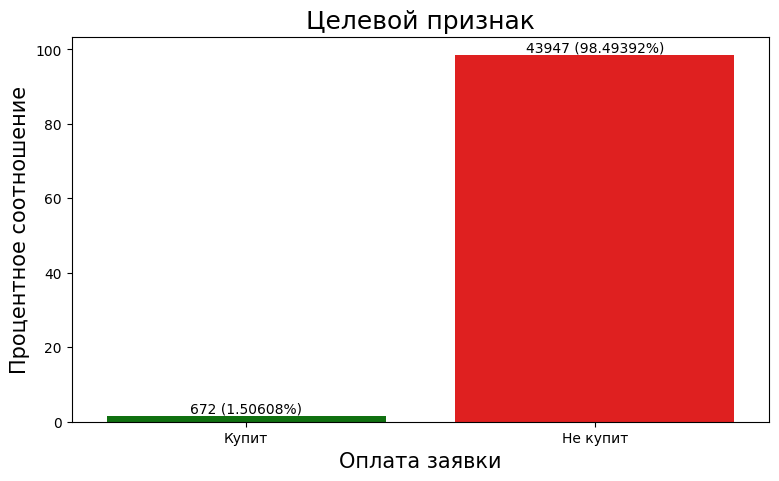

Время выполнения: 0.33 секунд(ы)


In [26]:
# вызов метода target_countplot класса EDA
eda.target_countplot(dataset=final)

Дисбаланс очень значительный - всего 1.5 процента единиц

### Гистограммы и ящики с усами для числовых признаков

Гистограммы и ящики с усами.



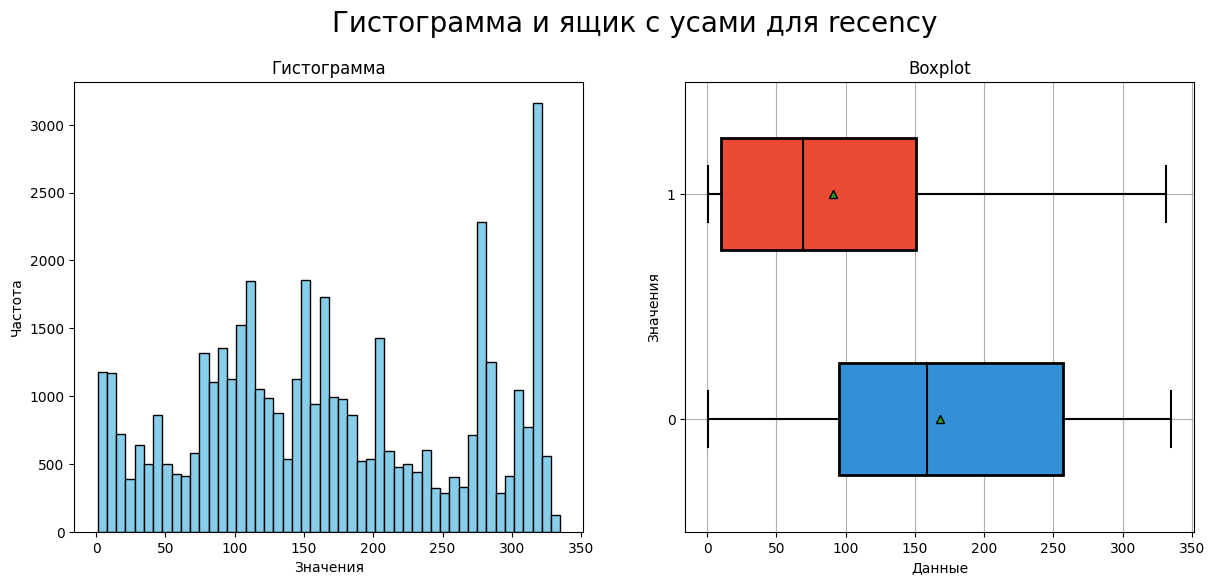

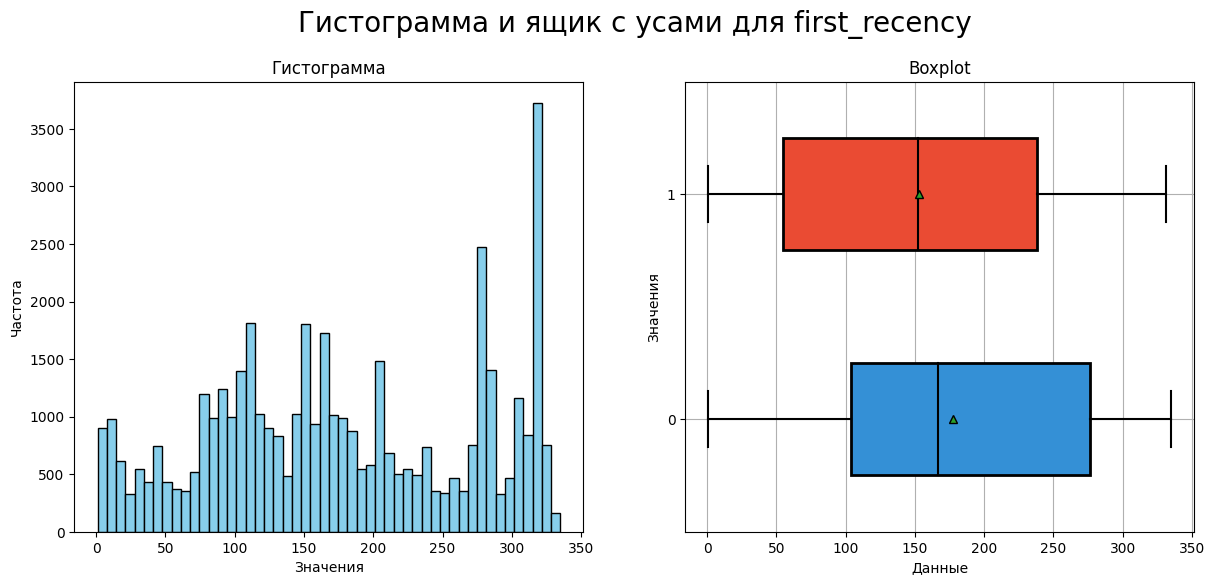

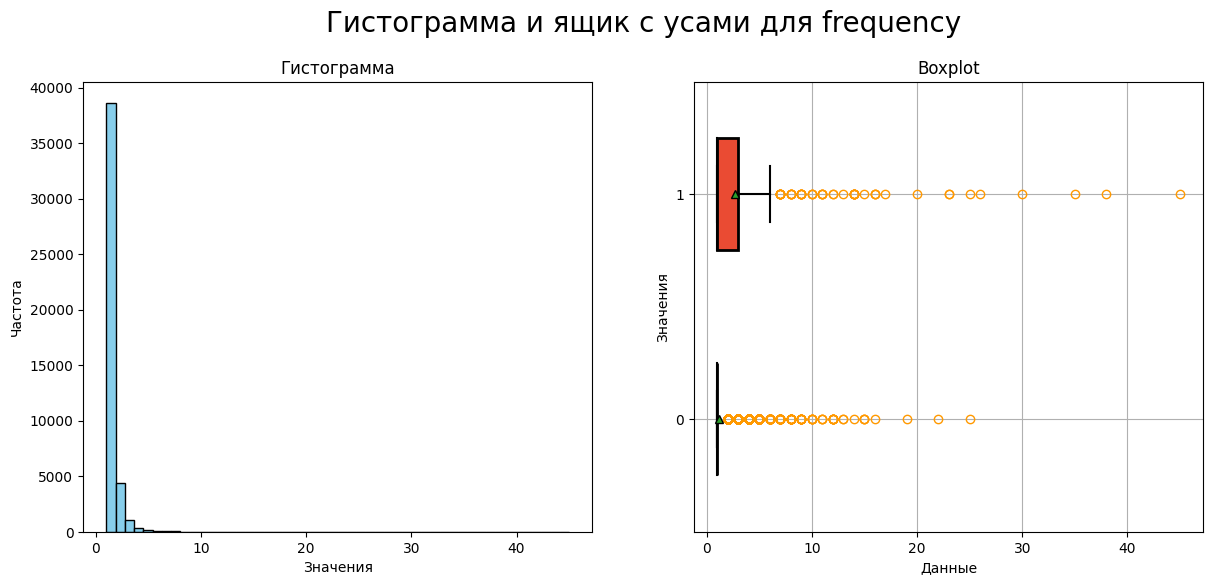

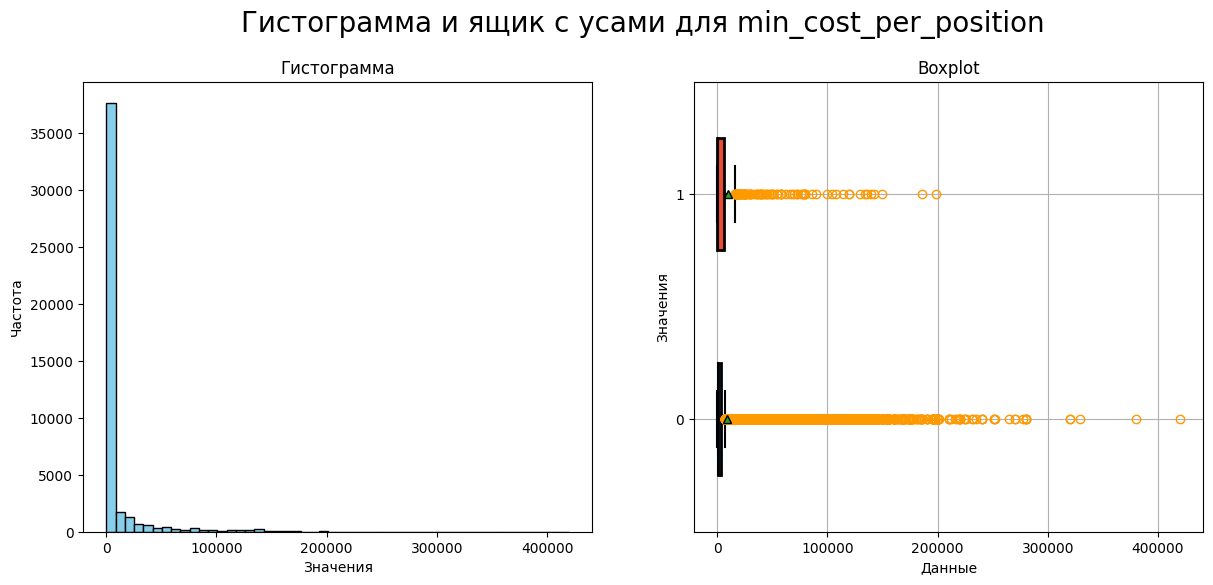

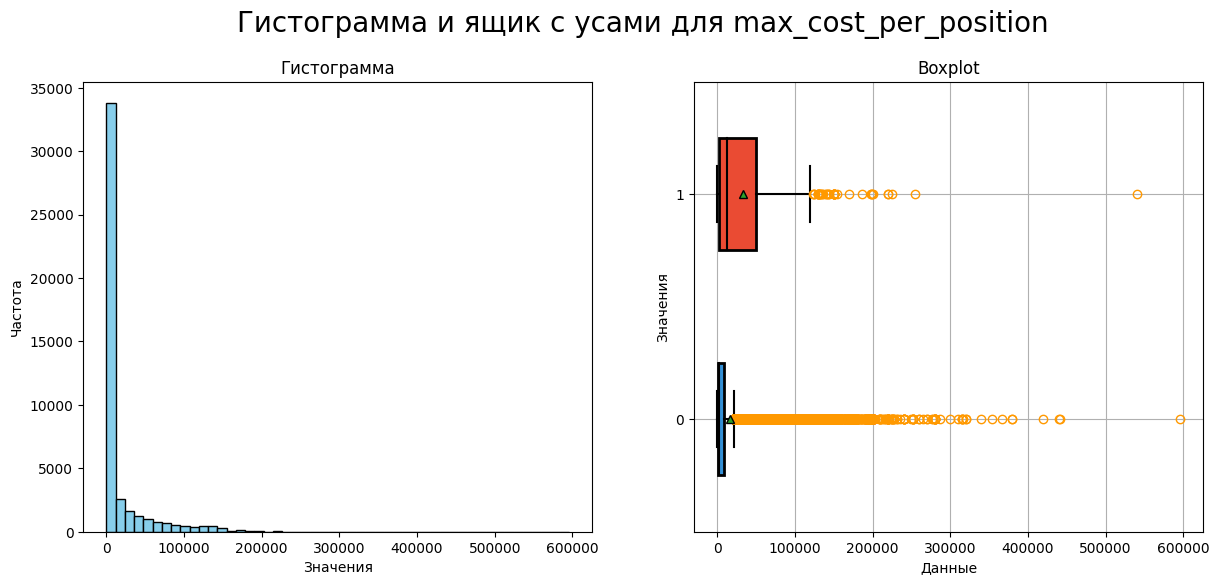

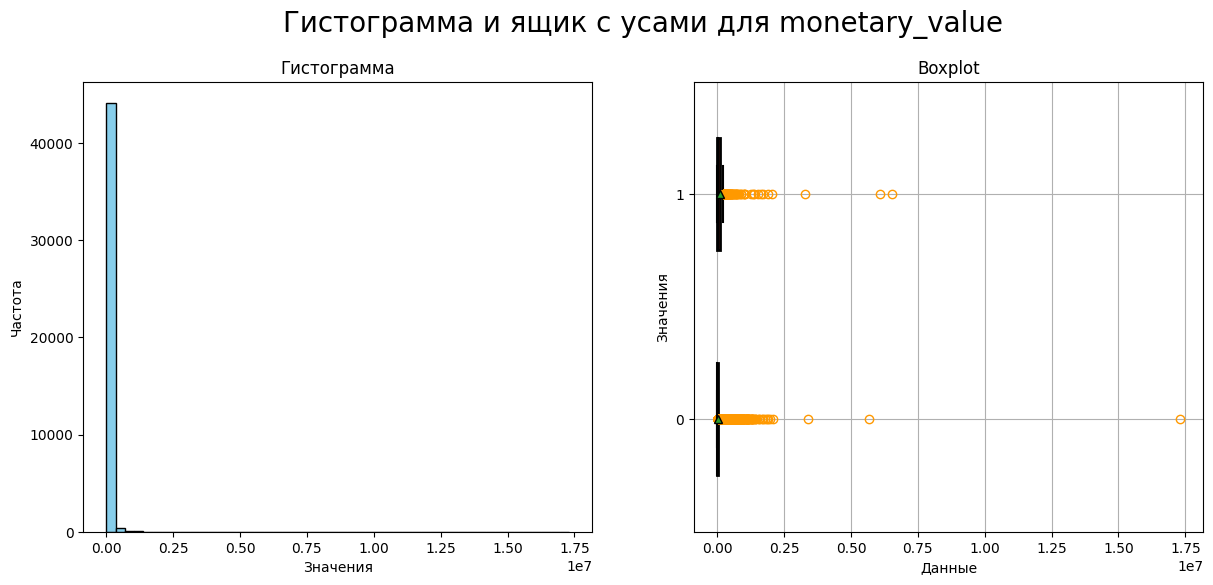

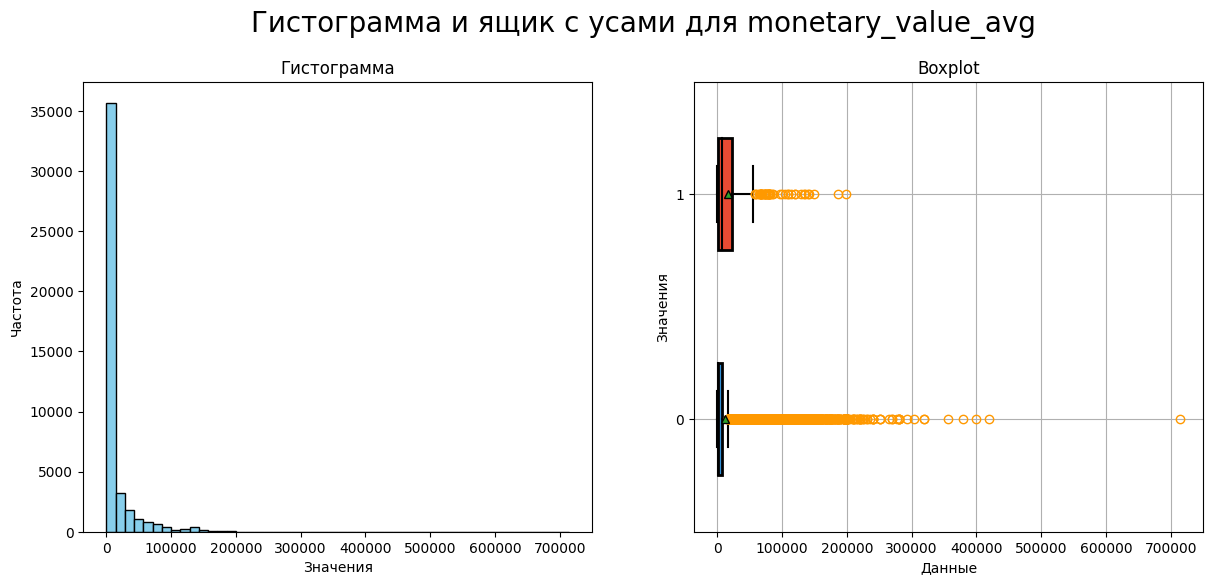

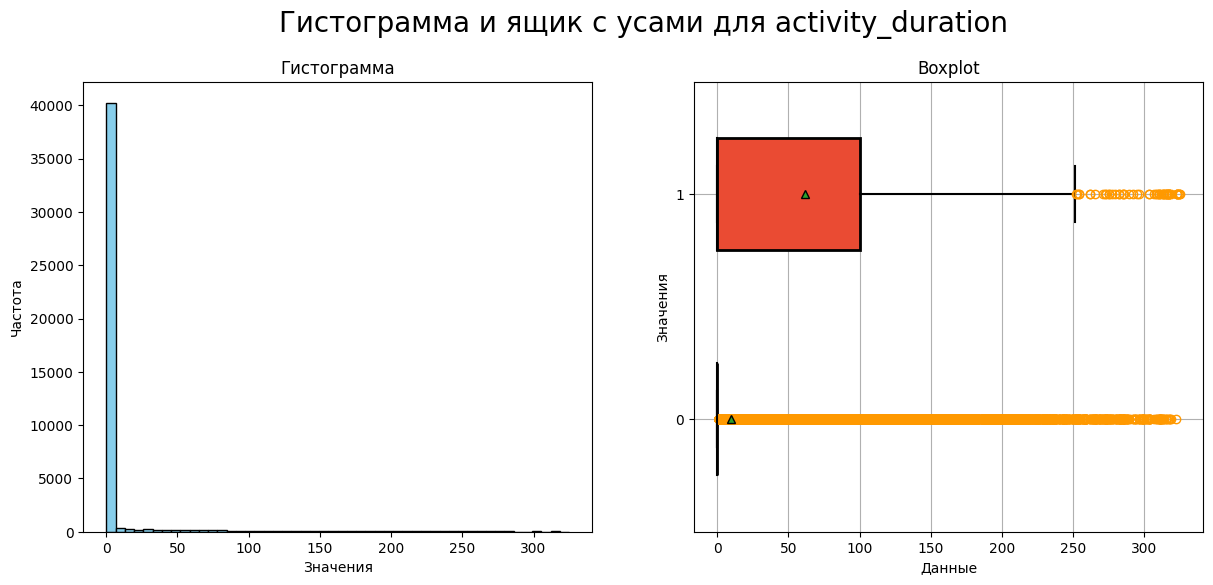

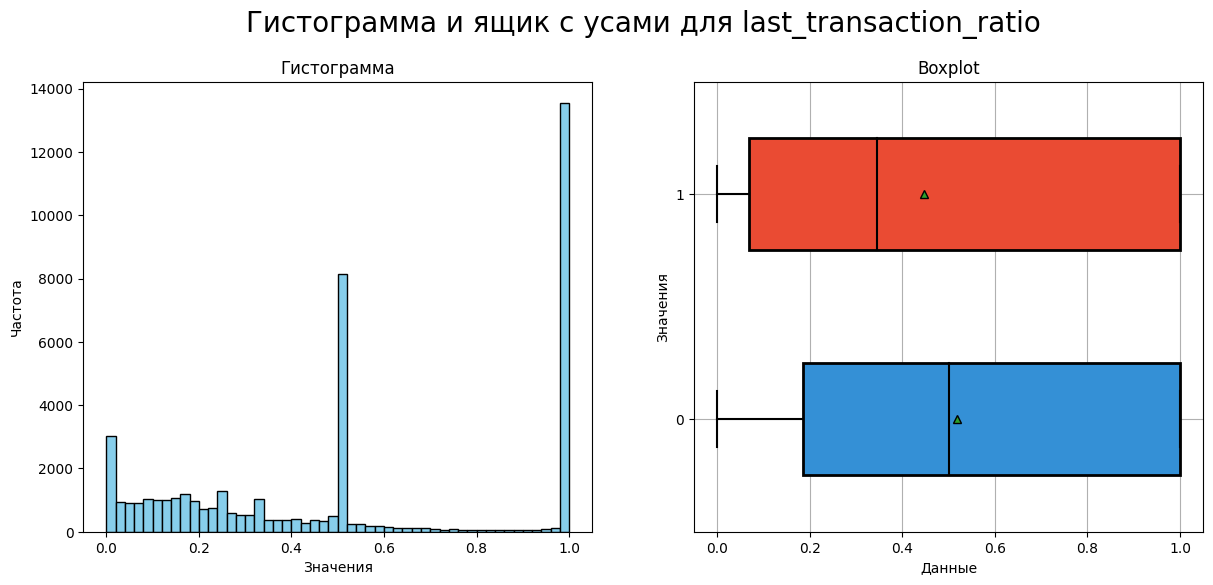

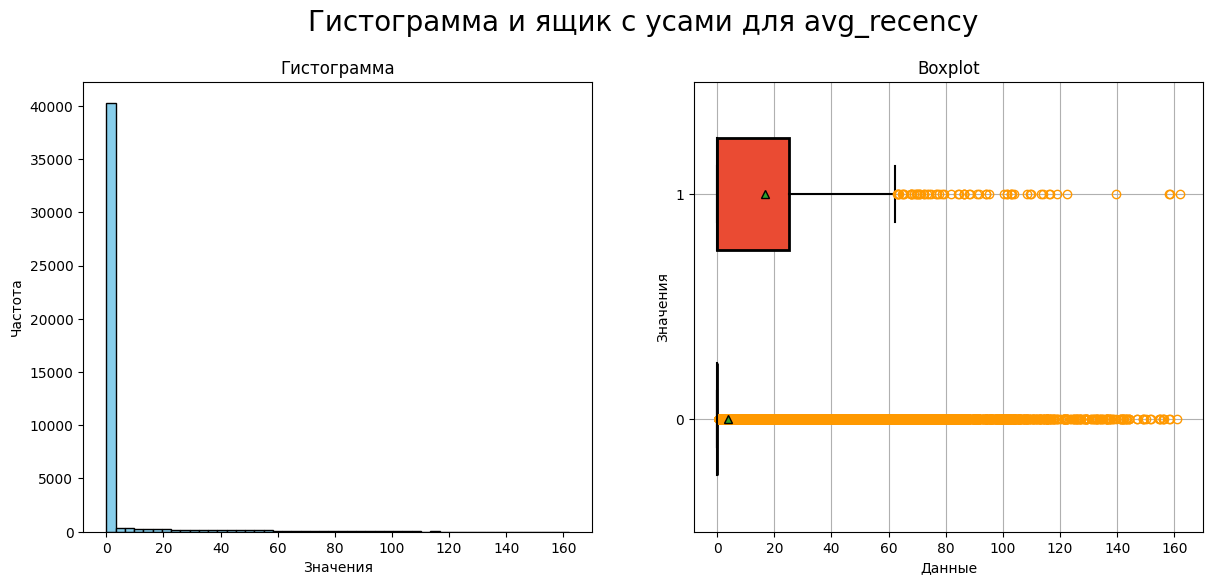

Время выполнения: 5.07 секунд(ы)


In [27]:
# вызов метода hist_and_box класса EDA
eda.hist_and_box(dataset=final, target="target")

Распределения далеки от нормальных, есть скошенные. По ящикам с усами: практически по всем признакам есть выбросы, но тут я ничего с ними поделать не могу. Принимаю как факт реальность данных и соответсвенно то, что все значения реальные и имеют место быть.

### Описательная статистика

In [28]:
# вызов метода custom_describe класса EDA
eda.custom_describe(dataset=final)

Описательная статистика.



Время выполнения: 0.27 секунд(ы)


По описательно статистике есть суммарное значение `monetary_value` в 17300384.00, минимальная цена за товар `min_cost_per_position`, который купил клиент, да и максимальная `max_cost_per_position` тоже.

По минимуму и максимуму тут можно предположить что угодно, хотя это скорее всего какая-то дорогая техника, например самые новороченные ПК в сборке.

По `monetary_value` можно наглядно увидеть ниже:

In [29]:
final.loc[final["monetary_value"] == 17300384.00]

client_id  recency  first_recency  frequency  \
11742  1515915625557752721       84            178         13   

       min_cost_per_position  max_cost_per_position  monetary_value  \
11742                    2.0               219998.0      17300384.0   

       monetary_value_avg  activity_duration  last_transaction_ratio  \
11742        61787.089844                 94                0.006935   

       avg_recency  rfm  target shop  
11742     7.230469  344       0    3

Вполне себе похоже на правду: 13 раз покупал, самая дорогая покупка 219998.0, хотя уже давно не забегал в магазин..

### Корреляция

Время выполнения: 3.04 секунд(ы)


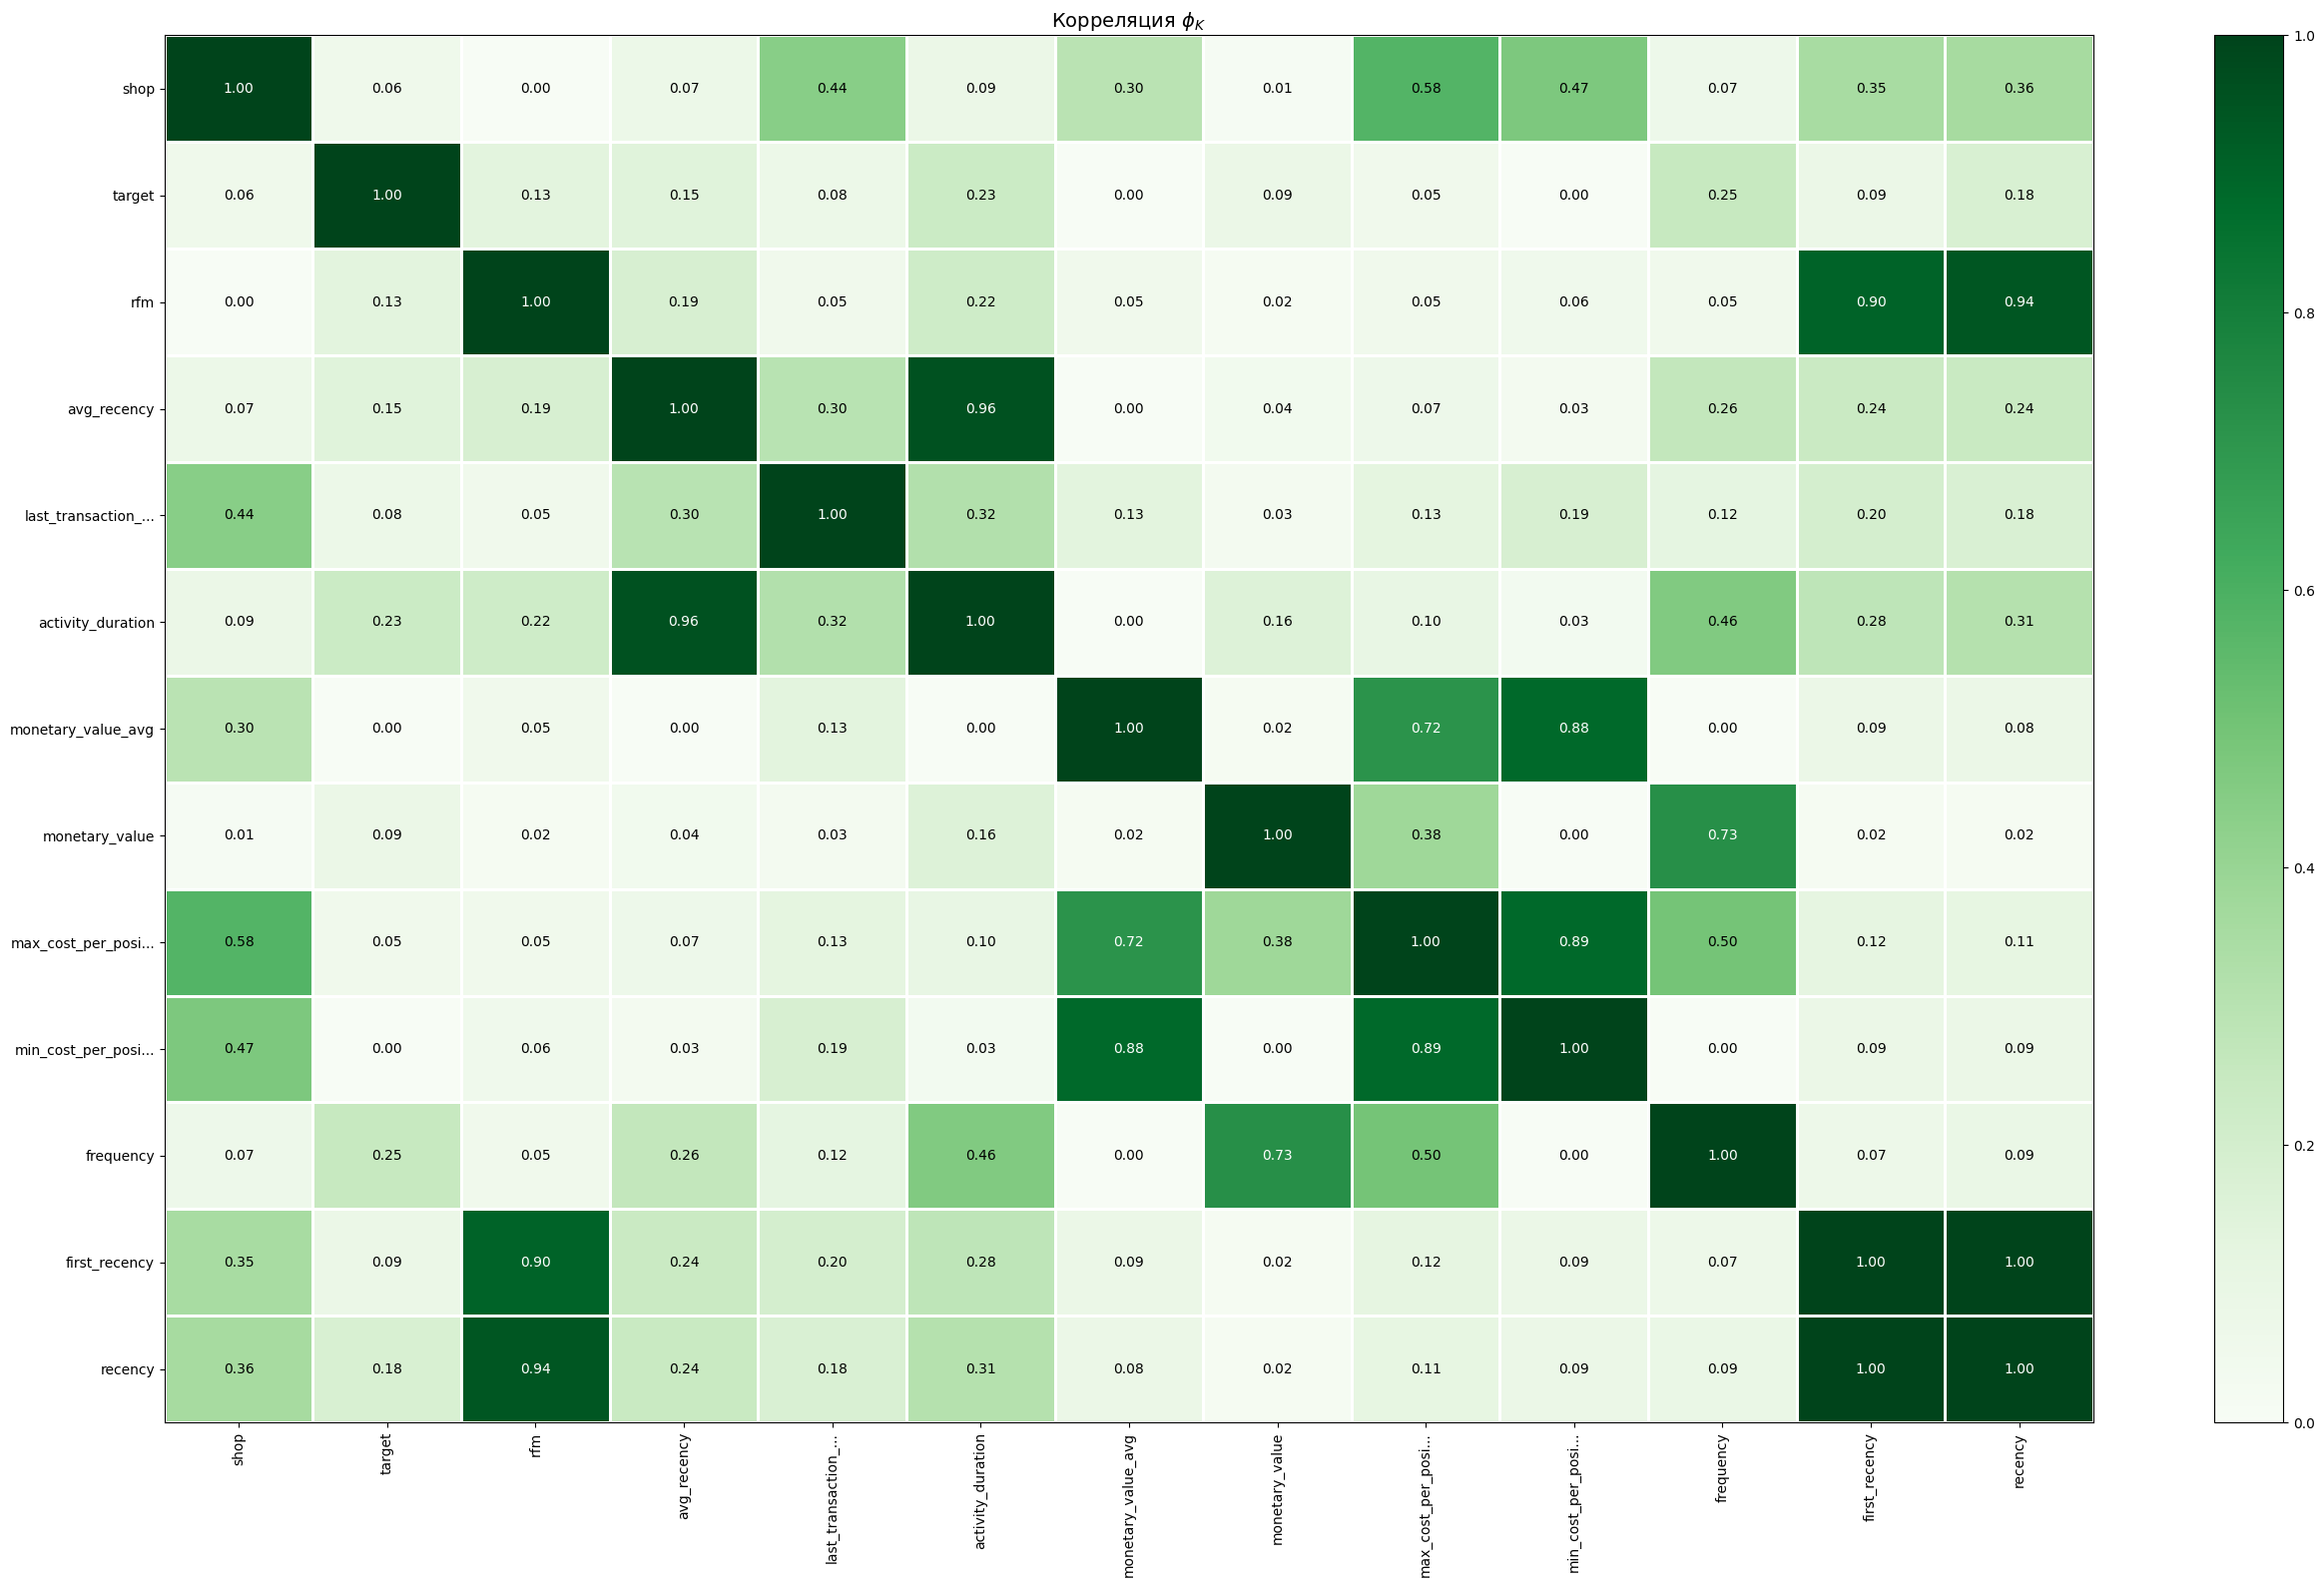

In [30]:
# вызов метода phik_correlation класса EDA
_ = eda.phik_correlation(dataset=final, cols_to_drop=["client_id"])

Сильной корреляции с таргетом нету. Видны мультиколлениарность некоторых признаков между собой.

### `Pairplot`

График Pairplot



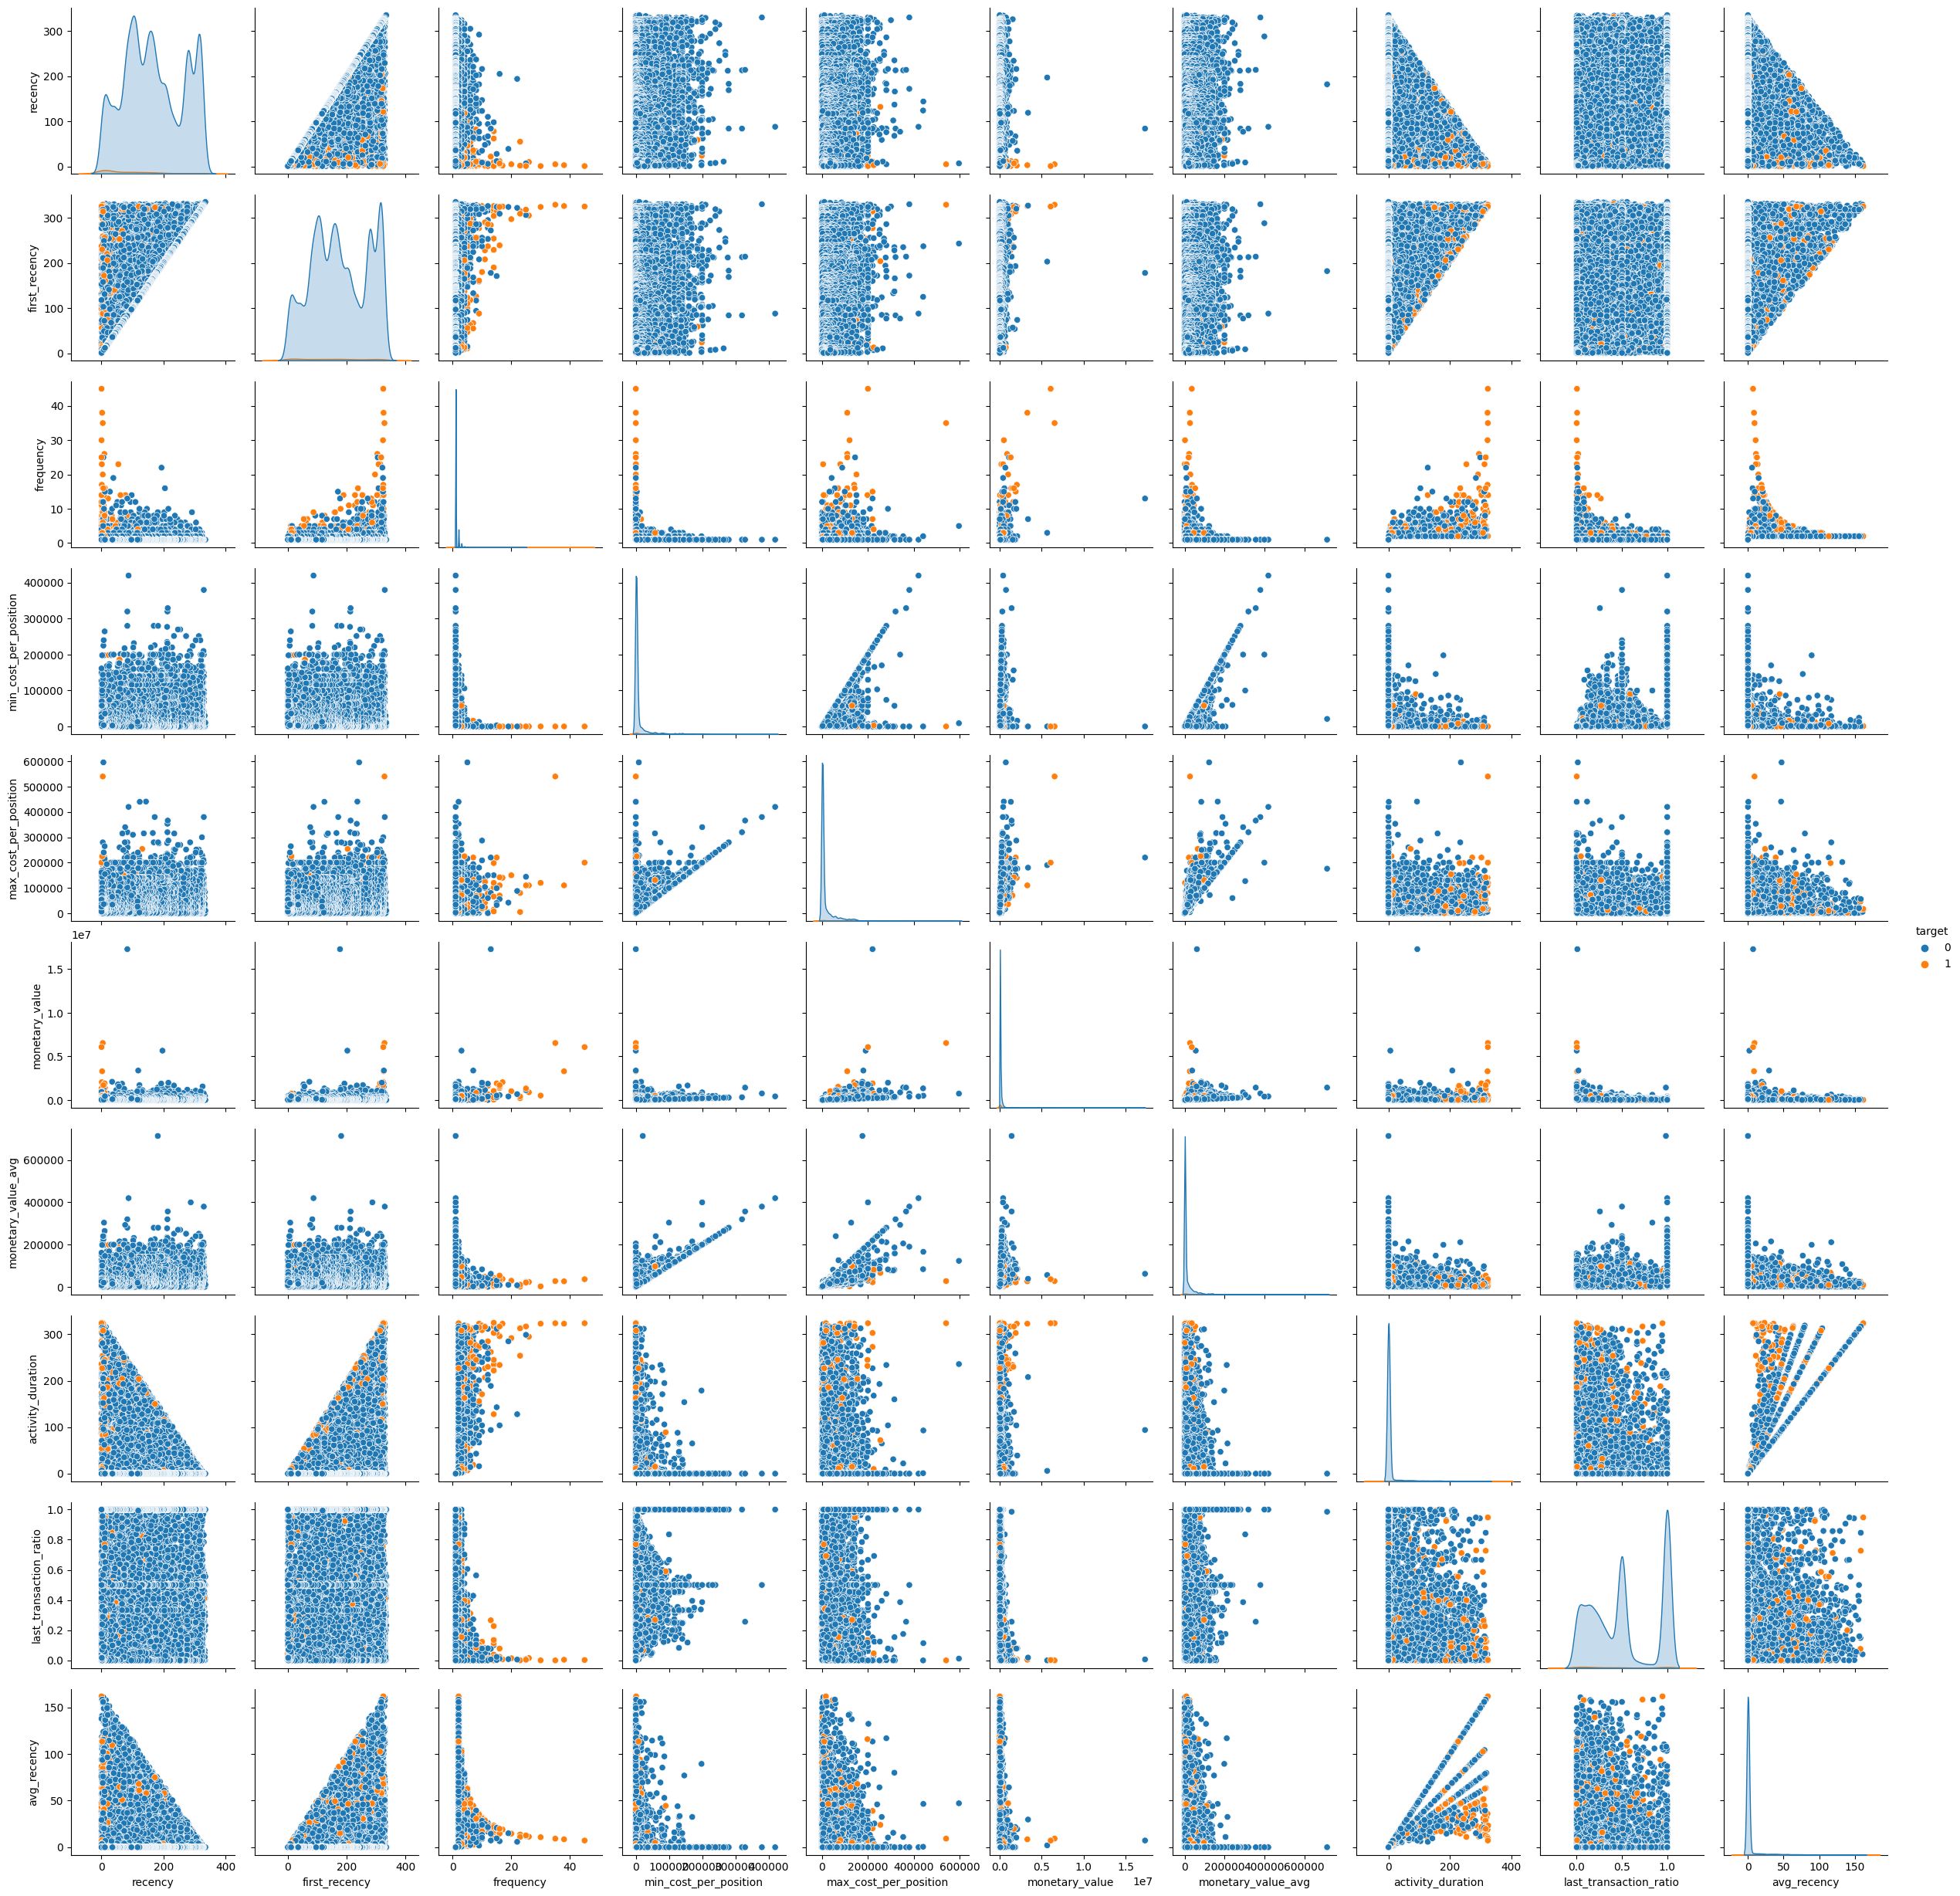

Время выполнения: 253.72 секунд(ы)


In [31]:
# вызов метода pairplot класса EDA
eda.pairplot(
    dataset=final, cols_to_drop=["client_id", "rfm", "shop"], target_col="target"
)

Посмотрев на графики, в принципе видна не разделимость, но все-таки есть отчетливая различимость таргета по признаку `frequency` со всеми остальными.

Можно попробовать нагенерить доп признаков, такие как квадраты, кубы и логарифмы уже существующих.

### Генерация доп. признаков

In [32]:
# получаем датасет с новыми признаками вызовом метода feature_generation
final = preprocessor.feature_generation(dataset=final, target_col="target")

Время выполнения: 0.04 секунд(ы)


### Новая матрица корреляции

Время выполнения: 11.06 секунд(ы)


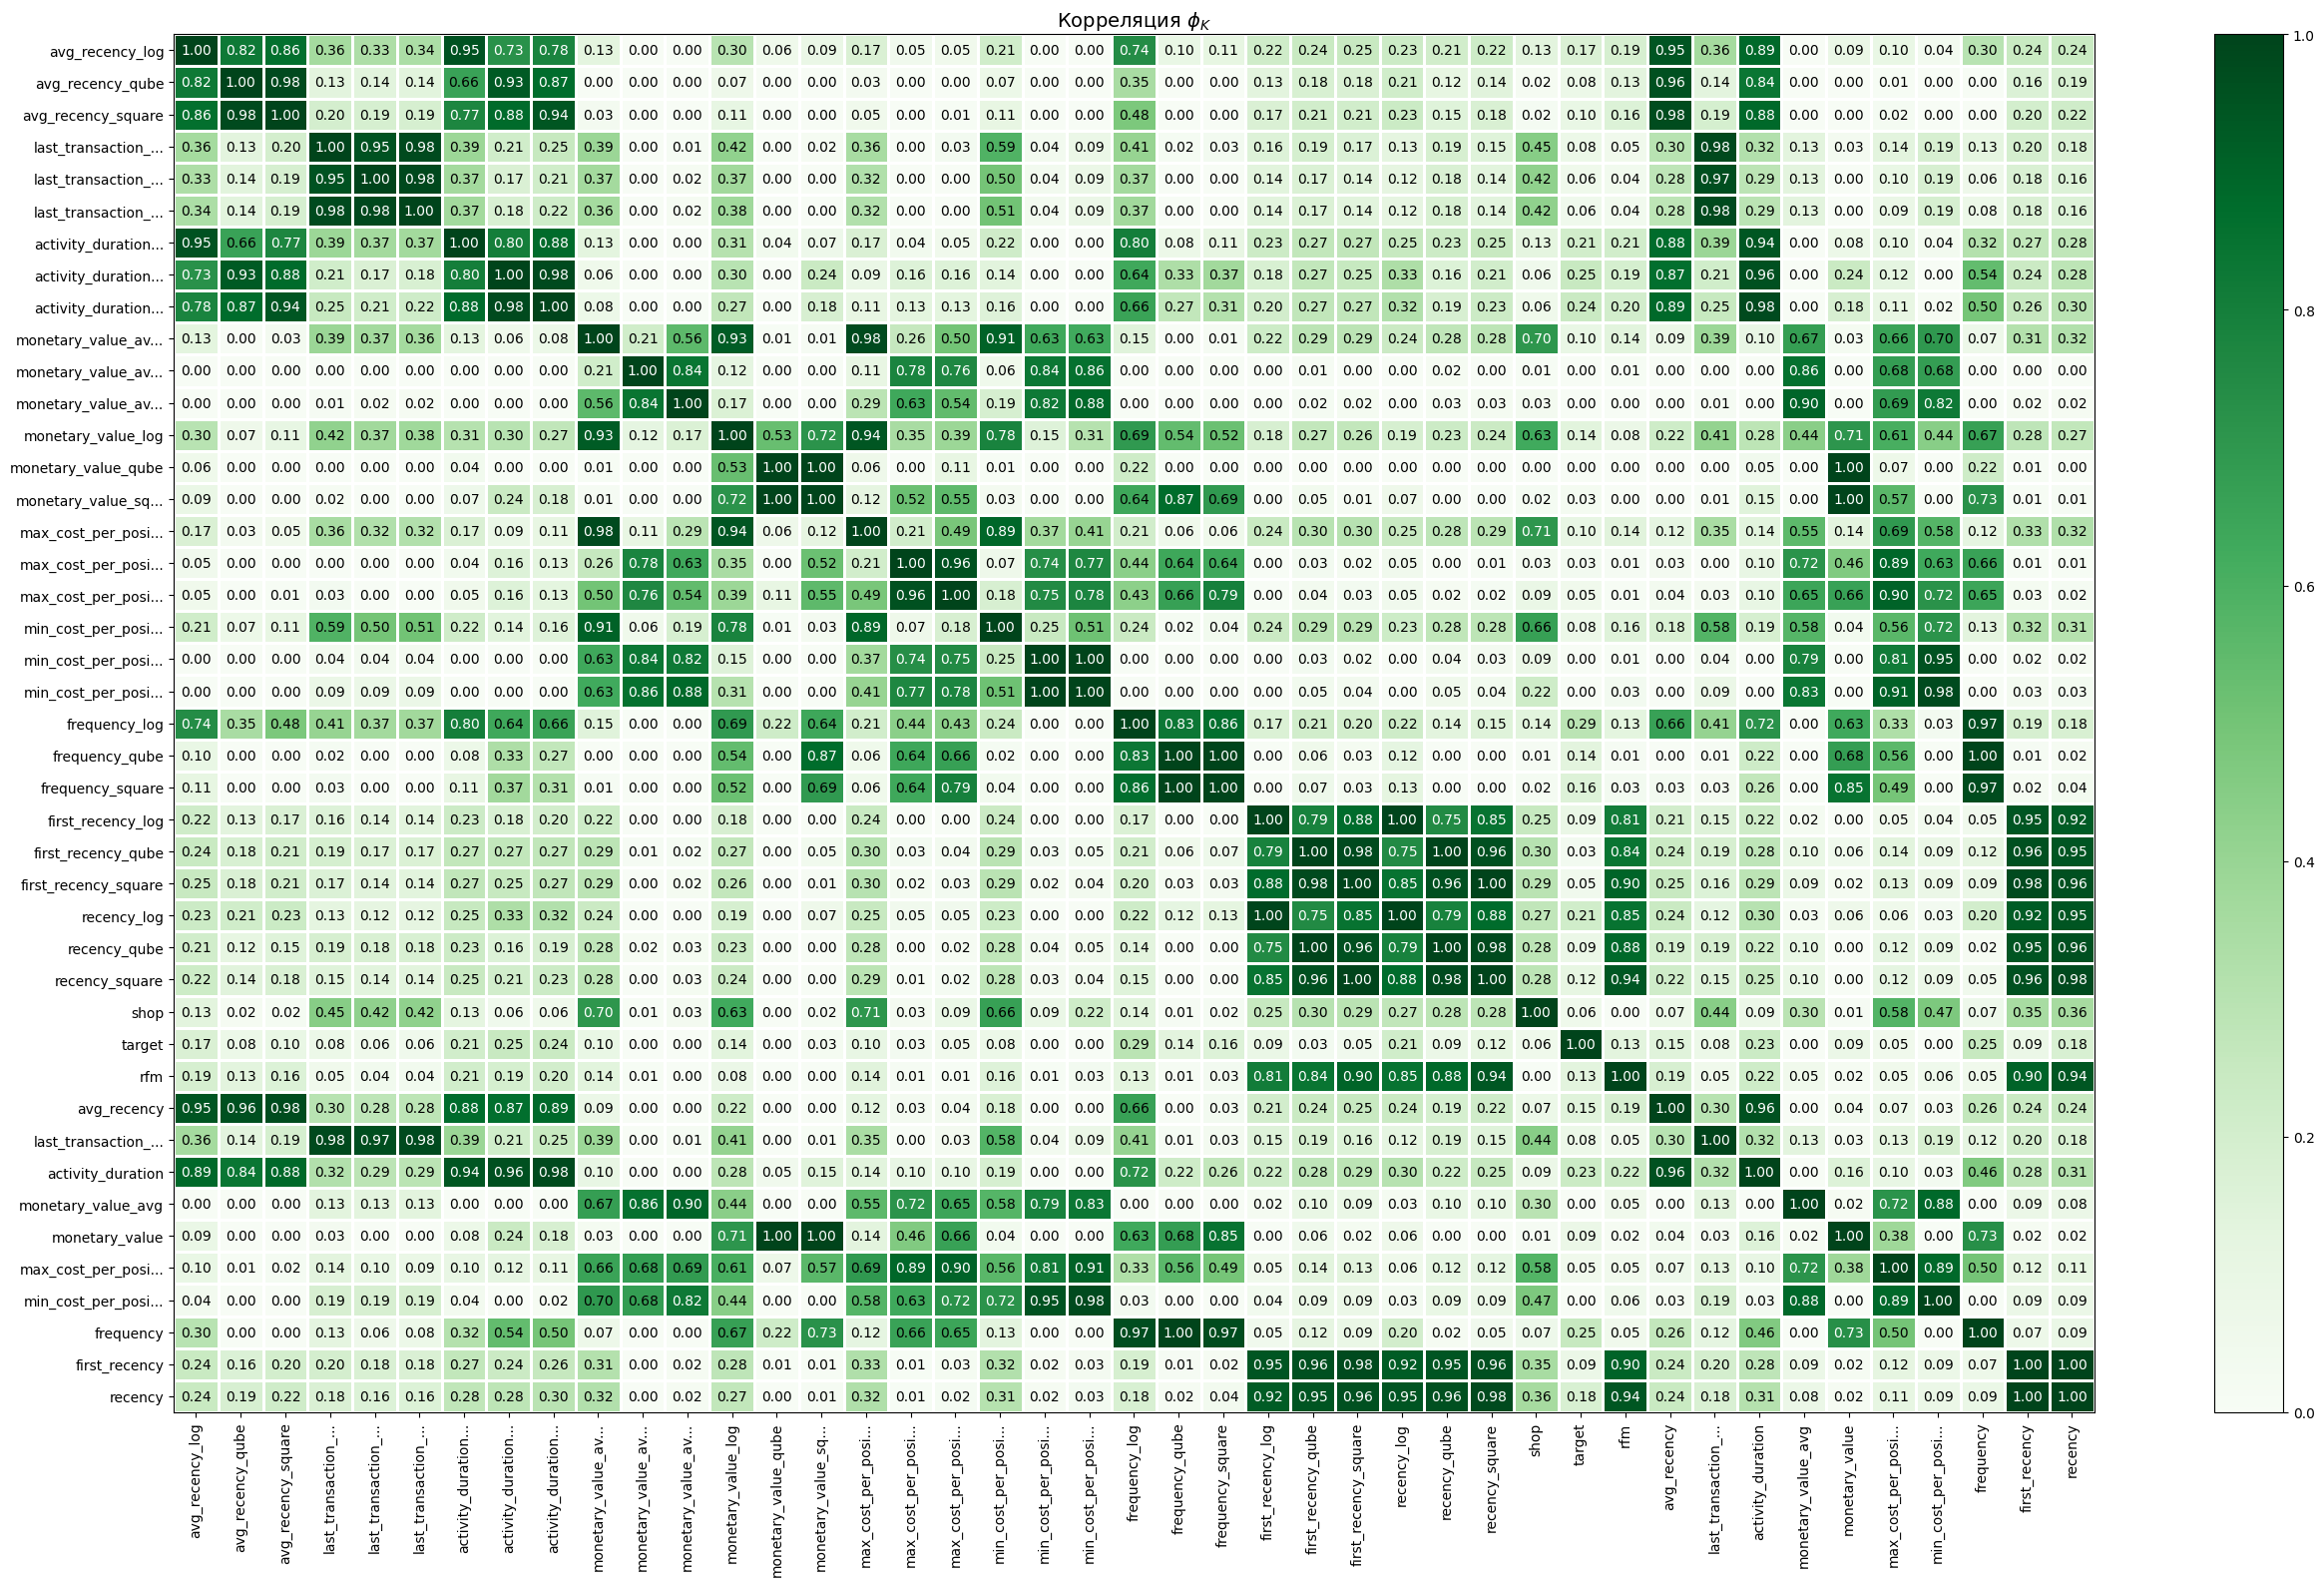

In [33]:
# вызов метода phik_correlation класса EDA
_ = eda.phik_correlation(dataset=final, cols_to_drop=["client_id"])

Если детально посмотреть, то у сгенерированных признаков увеличивается корреляция с таргетом, например `recency` - 0.18, а `recency_log` - 0.21. И такое для многих признаков. Ну и конечно же мултиколлинеарность. От части признаков можно избавиться подключив в методе `phik_correlation` проверку на мультиколлинеарность, но я этого делать не буду, а в дальнейшем пропущу признаки через автоматический отбор.

Удаляем `client_id` и проверяем дубликаты.

In [34]:
final = final.drop("client_id", axis=1)
final.duplicated().sum()

5602

Дубликаты есть, их удаляем

In [35]:
final = final.drop_duplicates()

### Новый баланс целевого признака

Баланс целевого признака



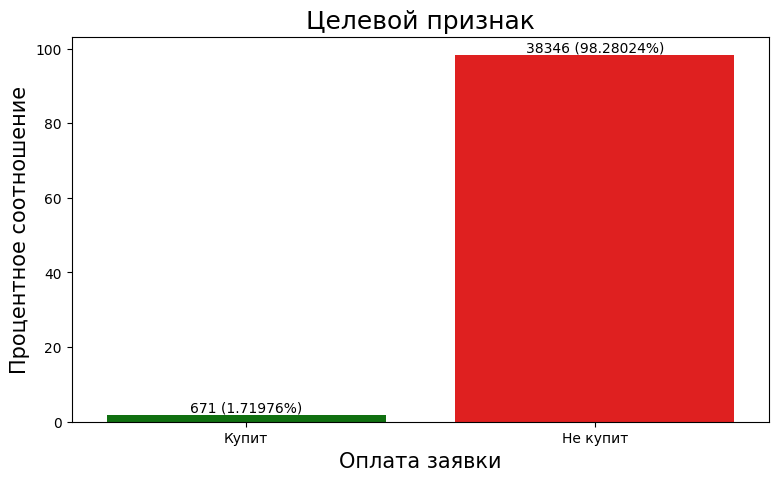

Время выполнения: 0.21 секунд(ы)


In [36]:
# вызов метода target_countplot класса EDA
eda.target_countplot(dataset=final)

После удаления дубликатов в количестве 5602 штук, удалось чуть снизить дисбаланс до 1.7% против 1.5% изначальных.

## Разбиение на выборки

In [37]:
features_train, target_train, features_test, target_test = splitter.get_coded_data(
    dataset=final,
    target_col="target",
    test_size=0.2,
    report=False,
    one_hot=True,
    cols_to_one_hot=["shop"],
    scaler=RobustScaler(),
)

Время выполнения: 0.18 секунд(ы)


## Метрика

Так как дисбаланс огромный и цель стоит в предсказании покупки, то есть в максимизации таргета = 1, то можно в качестве метрики выбрать не `accuracy`, которая при дисбалансе не актуальна и не `roc_auc`, а
**сбалансированную точность** (`Balanced Accuracy`).

$BA = \huge\frac{{R_{1}+R_{0}}}{2} = \frac{1}{2} \left( \frac{TP}{TP+FN} + \frac{TN}{TN+FP} \right)$

Для простоты запоминания – это среднее полноты всех классов, ну или в других терминах: среднее чувствительности (`Sensitivity`) и специфичности (`Specificity`). Отметим, что чувствительность и специфичность тоже, неформально говоря, «ортогональные критерии». Легко сделать специфичность 100%-й, отнеся все объекты к классу 0, при этом будет 0%-я чувствительность, и наоборот, если отнести все объекты к классу `1`, то будет `0%-я` специфичность и `100%-я` чувствительность.

Если в бинарной задаче классификации представителей двух классов примерно поровну, то $TP + FN \approx TN + FP \approx \frac{m}{2}$ и сбалансированная точность примерно равна точности обычной (Accuracy).
(Источник: )

## Модели

### Модель `LGBMClassifier` с дефолтными гипермараметрами

In [38]:
# инициализация модели вызовом метода get_model класса ModelOptuna
model_lgbm = ModelOptuna.get_model(
    model_name="LGBMClassifier",
    fixed_params={"force_row_wise": True, "verbose": -1},
    random=RANDOM,
)

In [39]:
# обучение модели и получение метрики на тесте вызовом метода get_test_results класса ModelOptuna
# прочерки ставлю, чтобы не сохранять данные в переменные, т.к. они не пригодятся в дальнейшем
_, _, _, _ = modelling.get_test_results(
    model=model_lgbm,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
    metric="balanced_accuracy",
)

Метрика BALANCED_ACCURACY модели на тестовой выборке: 0.532735
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      7670
         1.0       0.41      0.07      0.12       134

    accuracy                           0.98      7804
   macro avg       0.70      0.53      0.55      7804
weighted avg       0.97      0.98      0.98      7804

Время выполнения: 1.04 секунд(ы)


Матрица ошибок



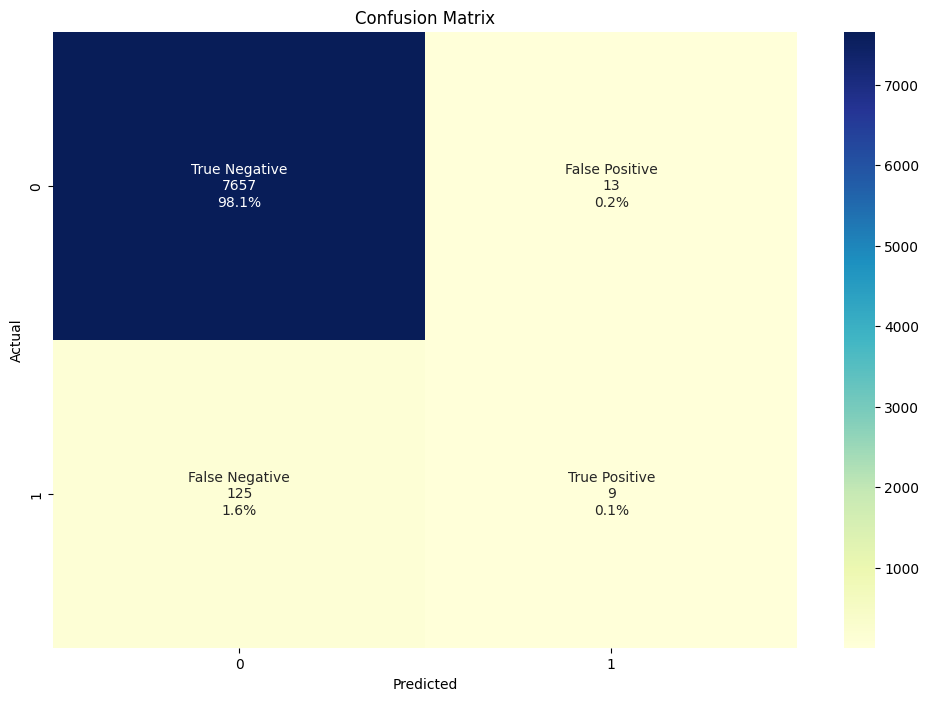

Всего предсказаний: 7804

Правильно предсказанные ответы (Accuracy): 0.9823
Ошибки в прогнозах: 0.0177

Recall: 0.0672
Precision: 0.4091

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 7657 правильных ответов. Не оплаченая заявка определена правильно.
  - TP в правом нижнем углу. 9 правильных ответов. Оплаченая заявка определена правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 13 ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.
  - FN в левом нижнем углу. 125 ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.


In [40]:
# выводим матрицу ошибок вызовом метода drow_confusion_matrix класса GraphicReport
report.drow_confusion_matrix(
    model=model_lgbm, features=features_test, target=target_test
)

Дефолтная модель, видит очень мало единиц.

### Отбор признаков `Sequential Future Selection`

Отбор будет произведен методом `Sequential Backward Floating Selection (SBFS)`, начиная с полного набора признаков и постепенного
удаления признаков, которые вносят наименьший вклад в качество модели при этом позволяя как удаление, так и добавление признаков на различных этапах алгоритма (`forward=False, floating=True`).

Будет сдела проход от всех до 1 признака, но так как в течение отбора все результаты сохраняются во внутренний словарь, то как результат будут выданы признаки с наибольшей метрикой на первом месте.

In [41]:
# получение лучших признаков вызовом метода ential_feature_selection класса ModelOptuna
best_features = modelling.sequential_feature_selection(
    model=model_lgbm,
    features_train=features_train,
    target_train=target_train,
    k_features=1,
    forward=False,
    floating=True,
    verbose=-2,
    scoring="balanced_accuracy",
    cv=StratifiedKFold(n_splits=5, random_state=RANDOM, shuffle=True),
    n_jobs=2,
    top_rows=6,
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  43 out of  43 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  42 out of  42 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  41 out of  41 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  39 out of  39 | elapsed:  2

feature_idx  \
0              (0, 2, 6, 8, 10, 20, 23, 41, 42)   
1                     (0, 2, 6, 10, 23, 36, 42)   
2                          (0, 2, 3, 6, 36, 42)   
3                  (0, 2, 6, 8, 10, 23, 36, 42)   
4         (0, 1, 2, 5, 6, 8, 9, 10, 23, 34, 42)   
5  (0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 23, 42)   

                                                                                              cv_scores  \
0  [0.5275484653157708, 0.5322444082224034, 0.5462962962962963, 0.5459139760375964, 0.5600956668113856]   
1  [0.5368942597082942, 0.5368740378520329, 0.5414221678891605, 0.5458324764450944, 0.5509943711963683]   
2  [0.5320583898914328, 0.5321629086299013, 0.5367925382595309, 0.5414040780263388, 0.5647685640076472]   
3  [0.5320583898914328, 0.5368740378520329, 0.5414221678891605, 0.5458324764450944, 0.5509943711963683]   
4    [0.541485670594256, 0.5367110386670289, 0.5459702979262882, 0.536486682052571, 0.5464029735926087]   
5    [0.541485670594256, 0.5367110386670289, 0.5458887983337861, 0.536486682052571, 0.5464029735926087]   

  avg_score  \
0   0.54242   
1  0.542403   
2  0.541437   
3  0.541436   
4  0.541411   
5  0.541395   

                                                                                                                                                                                             feature_names  \
0                                                        (recency, frequency, monetary_value_avg, last_transaction_ratio, rfm, min_cost_per_position_square, max_cost_per_position_square, shop_2, shop_3)   
1                                                                                         (recency, frequency, monetary_value_avg, rfm, max_cost_per_position_square, last_transaction_ratio_qube, shop_3)   
2                                                                                                     (recency, frequency, min_cost_per_position, monetary_value_avg, last_transaction_ratio_qube, shop_3)   
3                                                                 (recency, frequency, monetary_value_avg, last_transaction_ratio, rfm, max_cost_per_position_square, last_transaction_ratio_qube, shop_3)   
4                           (recency, first_recency, frequency, monetary_value, monetary_value_avg, last_transaction_ratio, avg_recency, rfm, max_cost_per_position_square, activity_duration_log, shop_3)   
5  (recency, first_recency, frequency, monetary_value, monetary_value_avg, activity_duration, last_transaction_ratio, avg_recency, rfm, recency_square, recency_qube, max_cost_per_position_square, sho...   

   ci_bound   std_dev   std_err  num_features  
0  0.014816  0.011527  0.005764             9  
1   0.00698   0.00543  0.002715             7  
2  0.015635  0.012165  0.006082             6  
3  0.008515  0.006625  0.003312             8  
4  0.005515  0.004291  0.002145            11  
5  0.005493  0.004273  0.002137            13

Время выполнения: 3642.67 секунд(ы)


В результате отбора из 43-х признаков осталось всего 9 и там присутсутвуют сгенерированные признаки, которые получились возведением в квадрат `min_cost_per_position_square`, `max_cost_per_position_square`.

Ниже оставляем в выборках только эти признаки.

In [42]:
features_train = features_train[best_features]
features_test = features_test[best_features]

### Подбор гиперпараметров для `LGBMClassifier`

In [43]:
# словарь с гиперпараметрами для подбора несбалансированной выборки
params_lgbm_unbalanced = {
    "boosting_type": ["gbdt", "rf"],
    "n_estimators": [10, 5000],
    "max_depth": [1, 20],
    "num_leaves": [2, 55],
    "min_child_weight": [5.01, 101],
    "subsample": [0.5, 1.0],
    "subsample_freq": [1, 10],
    "learning_rate": [0.0001, 1],
    "reg_alpha": [0.1, 10.1],
    "reg_lambda": [0.1, 10.1],
}
# словарь с гиперпараметрами для подбора сбалансированной выборки
params_lgbm_balanced = {
    "boosting_type": ["gbdt", "rf"],
    "n_estimators": [10, 5000],
    "max_depth": [1, 20],
    "num_leaves": [2, 55],
    "min_child_weight": [5.01, 101],
    "subsample": [0.5, 1.0],
    "subsample_freq": [1, 10],
    "learning_rate": [0.0001, 1],
    "reg_alpha": [0.1, 10.1],
    "reg_lambda": [0.1, 10.1],
    "pos_subsample": [0.85, 0.99],
    "neg_subsample": [0.3, 0.35],
}
# словарь с фиксироваными гиперпараметрами
fixed_params_lgbm = {
    "objective": "binary",
    "n_jobs": -1,
    "verbose": -1,
    "force_row_wise": True,
}

#### `LGBMClassifier` без балансировки на гиперпараметрах

In [44]:
# получаем модель с подобранными оптуной гиперпараметрами без балансировки
# вызываем метод get_model_with_best_params класса ModelOptuna
model_lgbm_unbalanced = modelling.get_model_with_best_params(
    n_trials=10,
    features_train=features_train,
    target_train=target_train,
    model_name="LGBMClassifier",
    fixed_params=fixed_params_lgbm,
    dynamic_or_best_params=params_lgbm_unbalanced,
    metric_for_cv="balanced_accuracy",
)

[I 2024-02-21 18:36:19,412] A new study created in memory with name: LGBMClassifier
[I 2024-02-21 18:36:29,598] Trial 0 finished with value: 0.5247309795022359 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 927, 'max_depth': 5, 'num_leaves': 32, 'min_child_weight': 29.97202267634364, 'subsample': 0.9757033722905775, 'subsample_freq': 7, 'learning_rate': 0.09899802946330918, 'reg_alpha': 2.041568994445536, 'reg_lambda': 3.152541219720587}. Best is trial 0 with value: 0.5247309795022359.
[I 2024-02-21 18:36:34,064] Trial 1 finished with value: 0.5091797765395024 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 541, 'max_depth': 6, 'num_leaves': 37, 'min_child_weight': 57.0459685989543, 'subsample': 0.9152107567263323, 'subsample_freq': 10, 'learning_rate': 0.07847681841413351, 'reg_alpha': 1.9396663511526442, 'reg_lambda': 2.741622318691845}. Best is trial 0 with value: 0.5247309795022359.
[I 2024-02-21 18:36:53,342] Trial 2 finished with value: 0.5 and parameters: {'


Лучшие гиперпараметры подобраные Optuna: {'boosting_type': 'rf', 'n_estimators': 2346, 'max_depth': 10, 'num_leaves': 40, 'min_child_weight': 8.552733908034288, 'subsample': 0.7226905248045996, 'subsample_freq': 2, 'learning_rate': 0.118920211690429, 'reg_alpha': 7.250234776848835, 'reg_lambda': 1.6657935106843442}
Усредненная метрика balanced_accuracy модели на тренировочной выборке с кроссвалидацией: 0.608381896603621
Время выполнения: 246.4 секунд(ы)


In [45]:
# обучение модели и получение метрики на тесте вызовом метода get_test_results класса ModelOptuna
best_model_lgbm_unbalanced, _, _, _ = modelling.get_test_results(
    model=model_lgbm_unbalanced,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
    metric="balanced_accuracy",
)

Метрика BALANCED_ACCURACY модели на тестовой выборке: 0.605518
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      7670
         1.0       0.13      0.24      0.17       134

    accuracy                           0.96      7804
   macro avg       0.56      0.61      0.57      7804
weighted avg       0.97      0.96      0.97      7804

Время выполнения: 6.69 секунд(ы)


Матрица ошибок



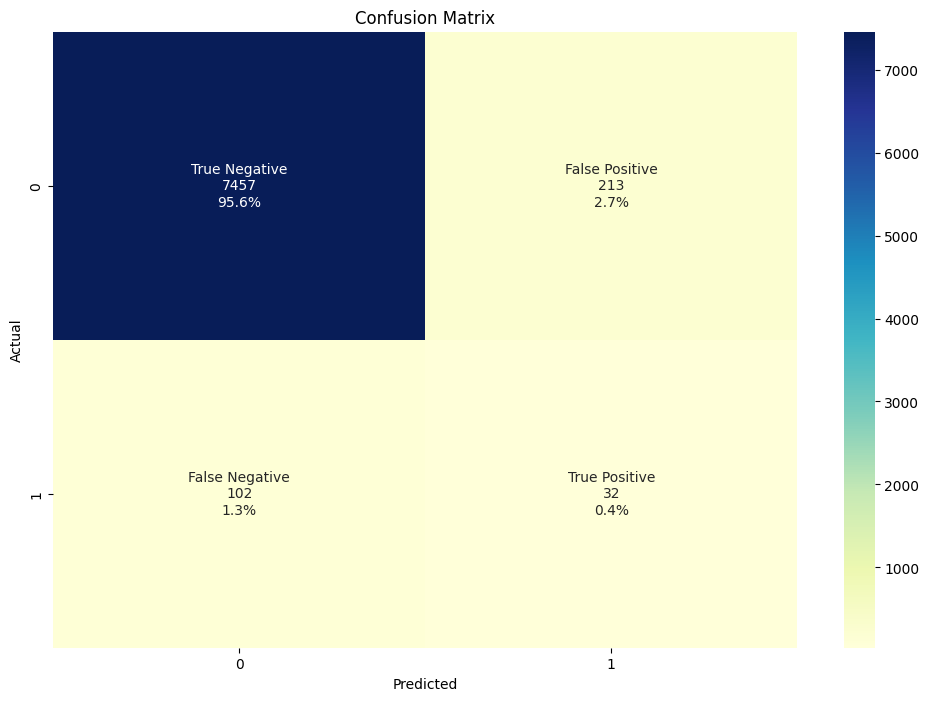

Всего предсказаний: 7804

Правильно предсказанные ответы (Accuracy): 0.9596
Ошибки в прогнозах: 0.0404

Recall: 0.2388
Precision: 0.1306

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 7457 правильных ответов. Не оплаченая заявка определена правильно.
  - TP в правом нижнем углу. 32 правильных ответов. Оплаченая заявка определена правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 213 ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.
  - FN в левом нижнем углу. 102 ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.


In [46]:
# выводим матрицу ошибок вызовом метода drow_confusion_matrix класса GraphicReport
report.drow_confusion_matrix(
    model=best_model_lgbm_unbalanced, features=features_test, target=target_test
)

По сравнению с дефолтной моделью метрика подросла, и модель стала видеть единицы, хотя усилился `FP`.

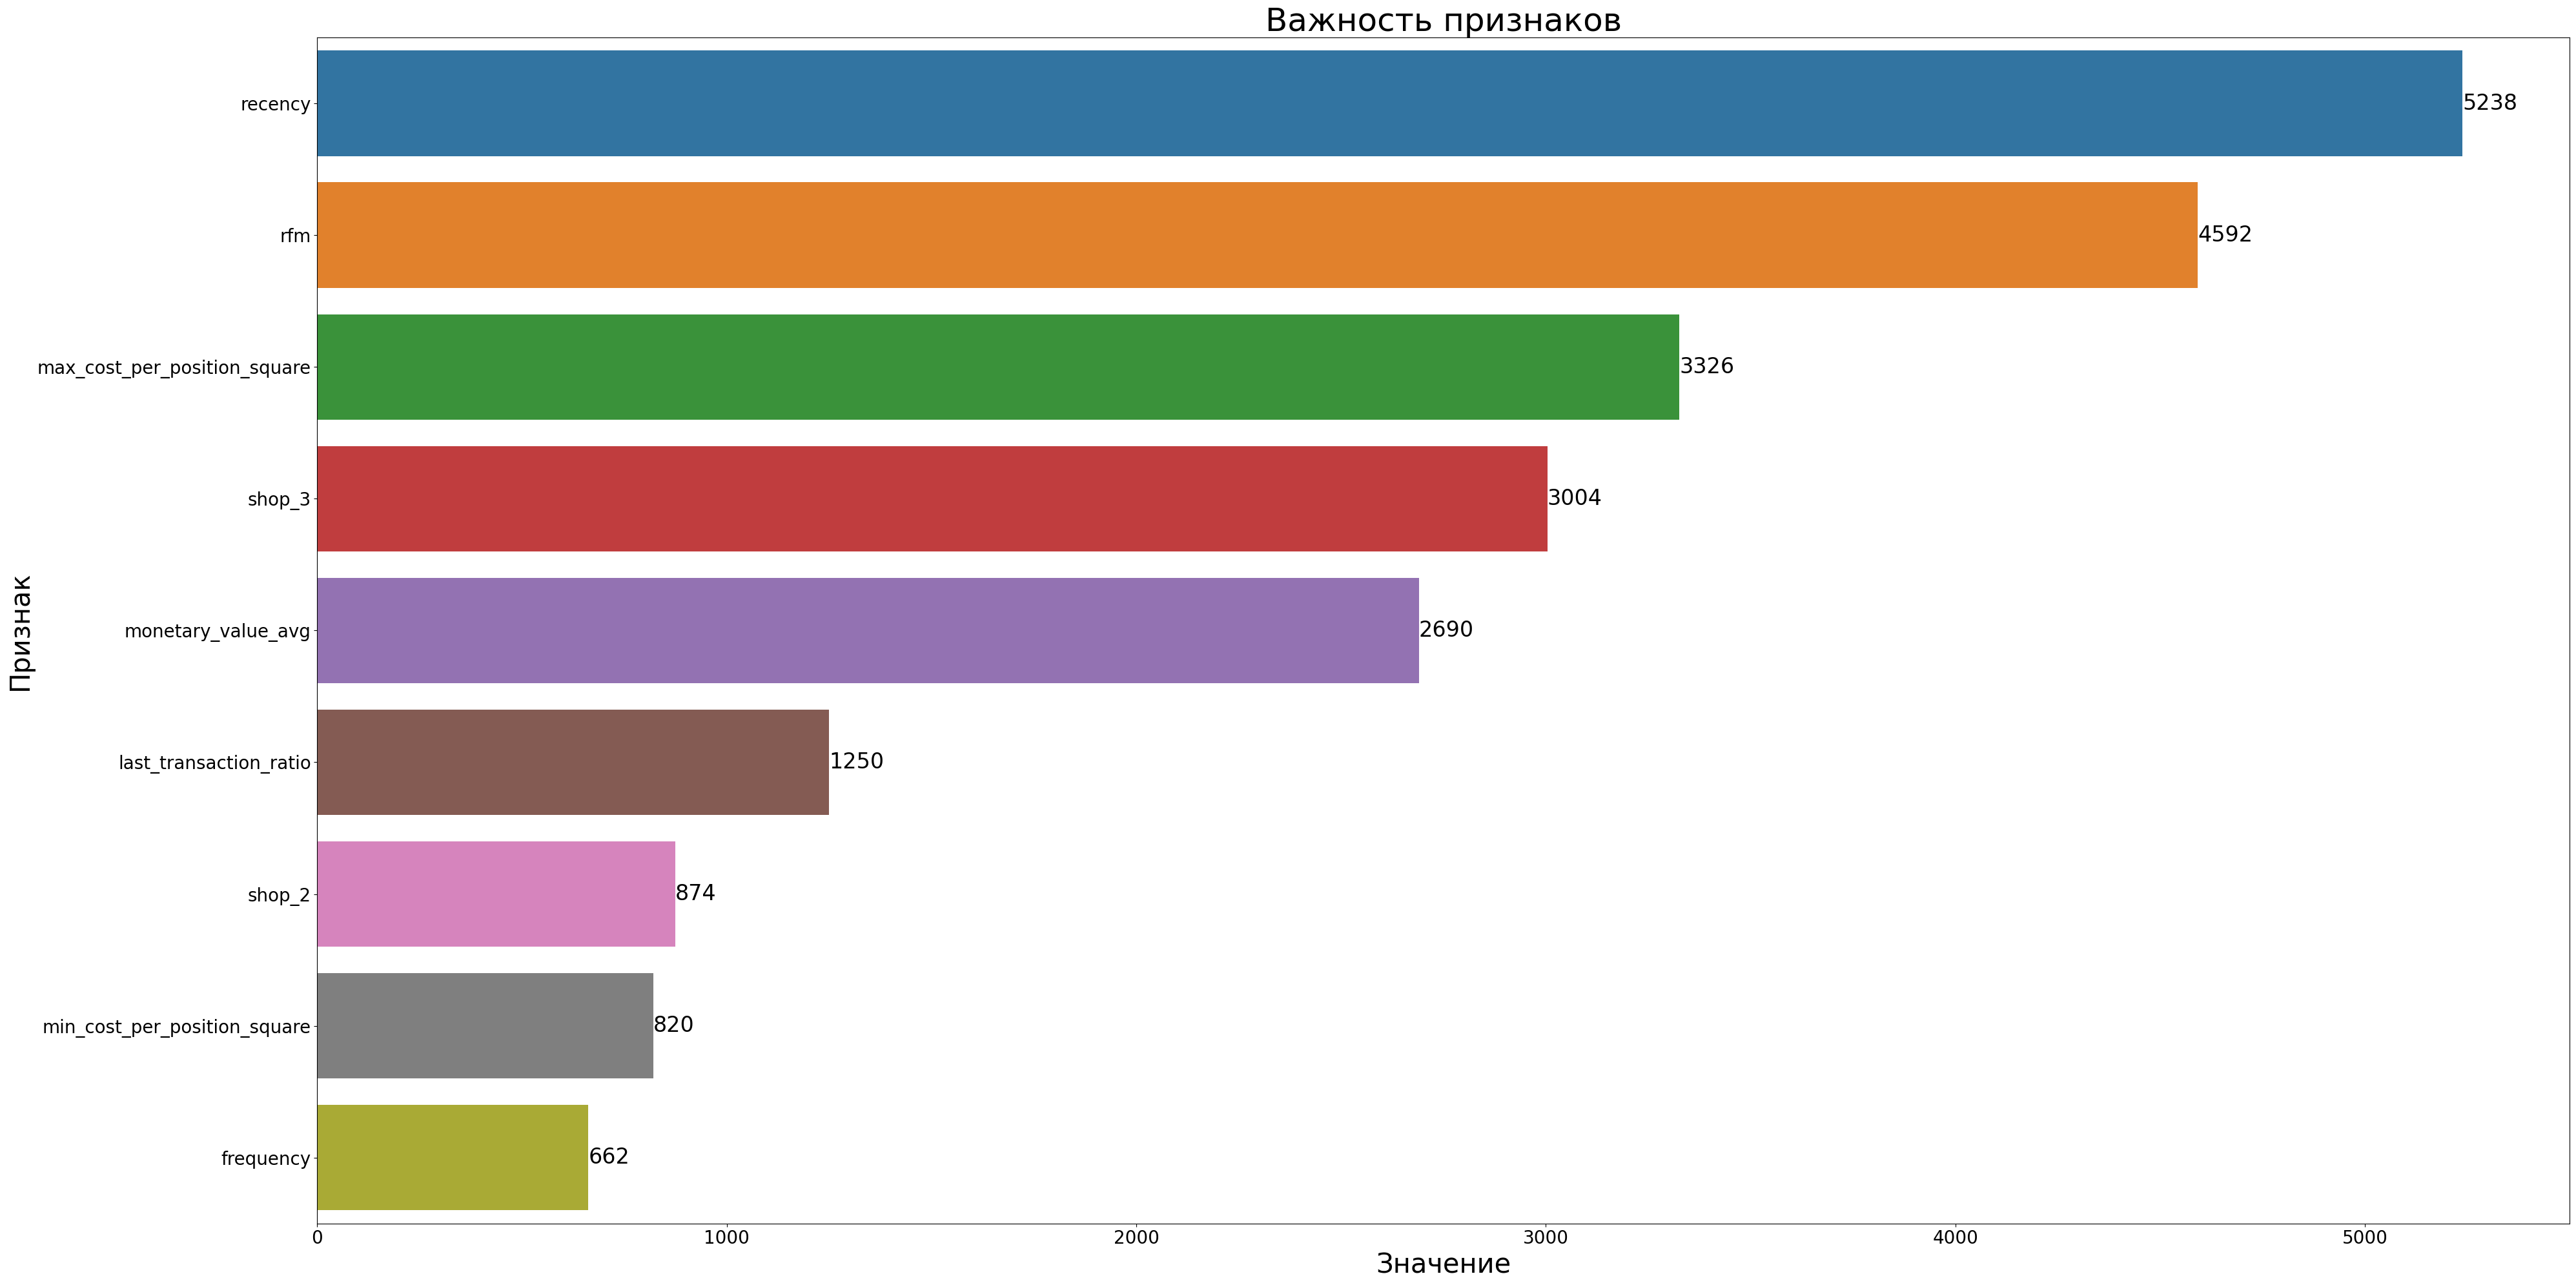

In [47]:
# выводим важность признаков, вызывая метод plot_importance класса GraphicReport
report.plot_importance(
    model=best_model_lgbm_unbalanced, features=features_train, fig_size=(40, 20)
)

Самый важный признак `recency`, далее `rfm`. Так же присутсвует категория `shop_3` - `marketplace`, что неудивительно, т.к таргета там, больше всего.

Ниже можно увидить рапределение таргета по магазинам.

Баланс целевого признака



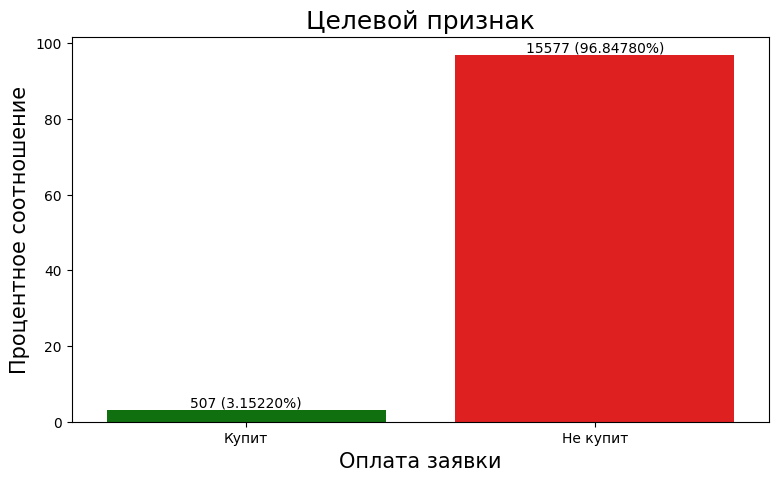

Время выполнения: 0.21 секунд(ы)


In [48]:
# вызов метода target_countplot класса EDA
eda.target_countplot(dataset=marketplace)

Баланс целевого признака



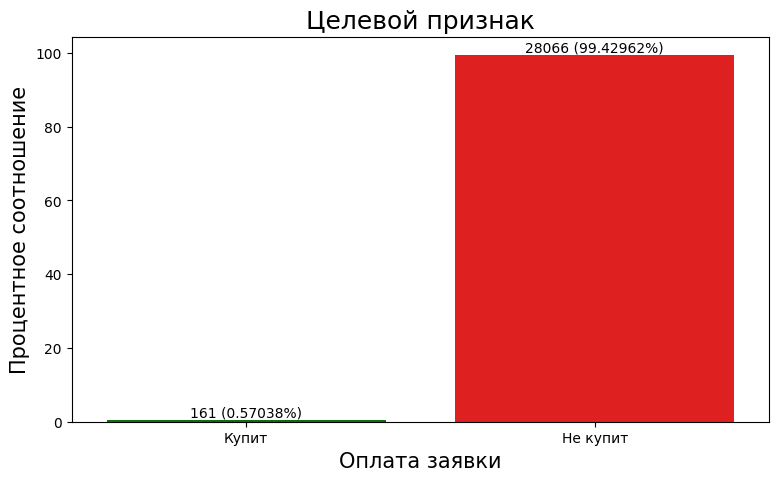

Время выполнения: 0.21 секунд(ы)


In [49]:
# вызов метода target_countplot класса EDA
eda.target_countplot(dataset=apparel)

Баланс целевого признака



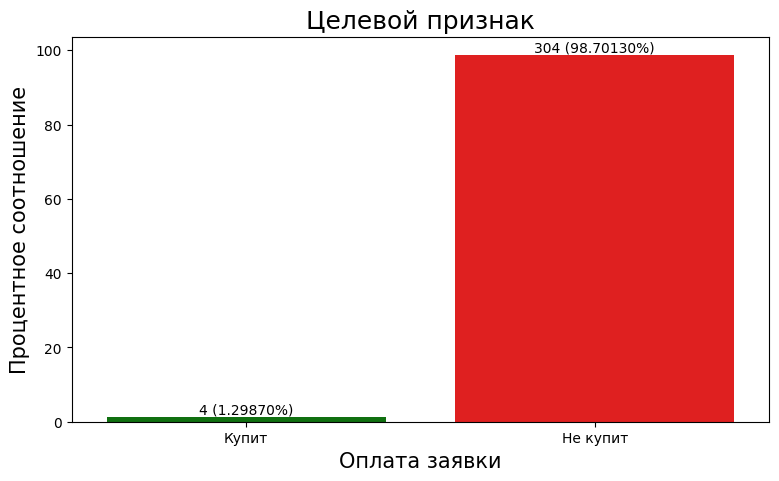

Время выполнения: 0.29 секунд(ы)


In [50]:
# вызов метода target_countplot класса EDA
eda.target_countplot(dataset=gifts)

Самый неуловимый таргет в подарках....

#### `LGBMClassifier` с балансировкой на гиперпараметрах

In [51]:
# получаем модель с подобранными оптуной гиперпараметрами c балансировкой
# вызываем метод get_model_with_best_params класса ModelOptuna
model_lgbm_balanced = modelling.get_model_with_best_params(
    n_trials=10,
    features_train=features_train,
    target_train=target_train,
    model_name="LGBMClassifier",
    fixed_params=fixed_params_lgbm,
    dynamic_or_best_params=params_lgbm_balanced,
    metric_for_cv="balanced_accuracy",
)

[I 2024-02-21 18:40:34,803] A new study created in memory with name: LGBMClassifier
[I 2024-02-21 18:40:42,613] Trial 0 finished with value: 0.5536503595302618 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 927, 'max_depth': 5, 'num_leaves': 32, 'min_child_weight': 29.97202267634364, 'subsample': 0.9757033722905775, 'subsample_freq': 7, 'learning_rate': 0.09899802946330918, 'reg_alpha': 2.041568994445536, 'reg_lambda': 3.152541219720587, 'pos_subsample': 0.9841766817853487, 'neg_subsample': 0.3003881694585552}. Best is trial 0 with value: 0.5536503595302618.
[I 2024-02-21 18:40:47,124] Trial 1 finished with value: 0.5 and parameters: {'boosting_type': 'rf', 'n_estimators': 3286, 'max_depth': 17, 'num_leaves': 49, 'min_child_weight': 90.82486115823463, 'subsample': 0.8256975599188451, 'subsample_freq': 7, 'learning_rate': 0.07409936448355497, 'reg_alpha': 0.8654035741696874, 'reg_lambda': 0.44934129040742815, 'pos_subsample': 0.9089302369903002, 'neg_subsample': 0.33571565702


Лучшие гиперпараметры подобраные Optuna: {'boosting_type': 'rf', 'n_estimators': 2453, 'max_depth': 19, 'num_leaves': 29, 'min_child_weight': 6.222560268154369, 'subsample': 0.7409809194713276, 'subsample_freq': 7, 'learning_rate': 0.5836939312060528, 'reg_alpha': 0.6800199434241506, 'reg_lambda': 0.3388618621744718, 'pos_subsample': 0.8627161691817978, 'neg_subsample': 0.3233307172278955}
Усредненная метрика balanced_accuracy модели на тренировочной выборке с кроссвалидацией: 0.7031050894306974
Время выполнения: 180.12 секунд(ы)


In [52]:
# обучение модели и получение метрики на тесте вызовом метода get_test_results класса ModelOptuna
best_model_lgbm_balanced, _, _, _ = modelling.get_test_results(
    model=model_lgbm_balanced,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
    metric="balanced_accuracy",
)

Метрика BALANCED_ACCURACY модели на тестовой выборке: 0.697538
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      7670
         1.0       0.07      0.51      0.13       134

    accuracy                           0.88      7804
   macro avg       0.53      0.70      0.53      7804
weighted avg       0.97      0.88      0.92      7804

Время выполнения: 13.17 секунд(ы)


Матрица ошибок



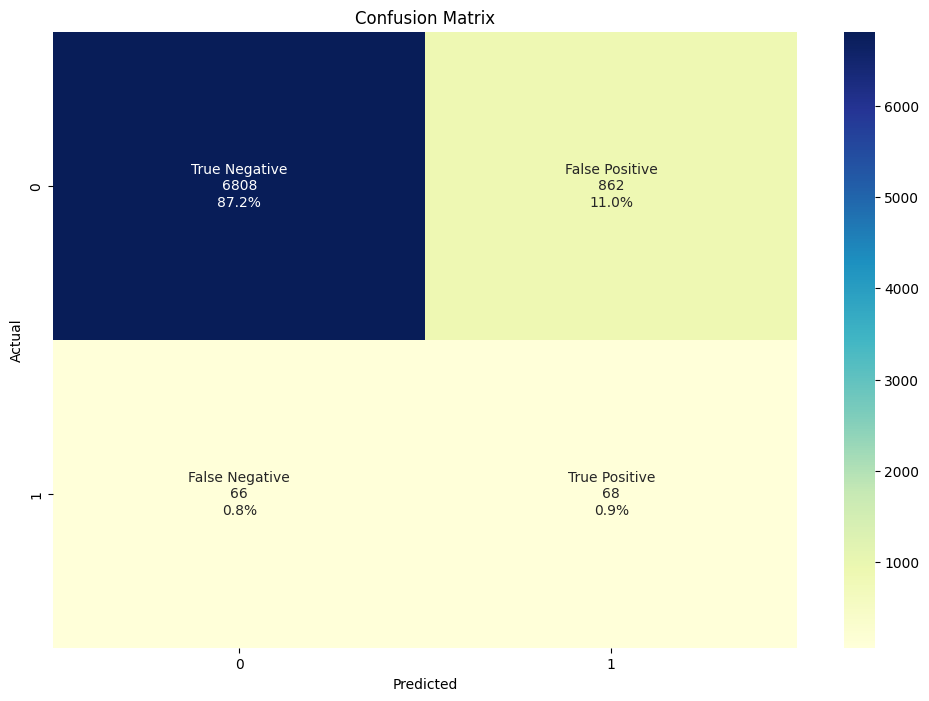

Всего предсказаний: 7804

Правильно предсказанные ответы (Accuracy): 0.8811
Ошибки в прогнозах: 0.1189

Recall: 0.5075
Precision: 0.0731

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 6808 правильных ответов. Не оплаченая заявка определена правильно.
  - TP в правом нижнем углу. 68 правильных ответов. Оплаченая заявка определена правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 862 ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.
  - FN в левом нижнем углу. 66 ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.


In [53]:
# выводим матрицу ошибок вызовом метода drow_confusion_matrix класса GraphicReport
report.drow_confusion_matrix(
    model=best_model_lgbm_balanced, features=features_test, target=target_test
)

При балансировке удалось еще больше увеличить метрику с **0.605518** до **0.697538**, но и `FP` тоже растет.

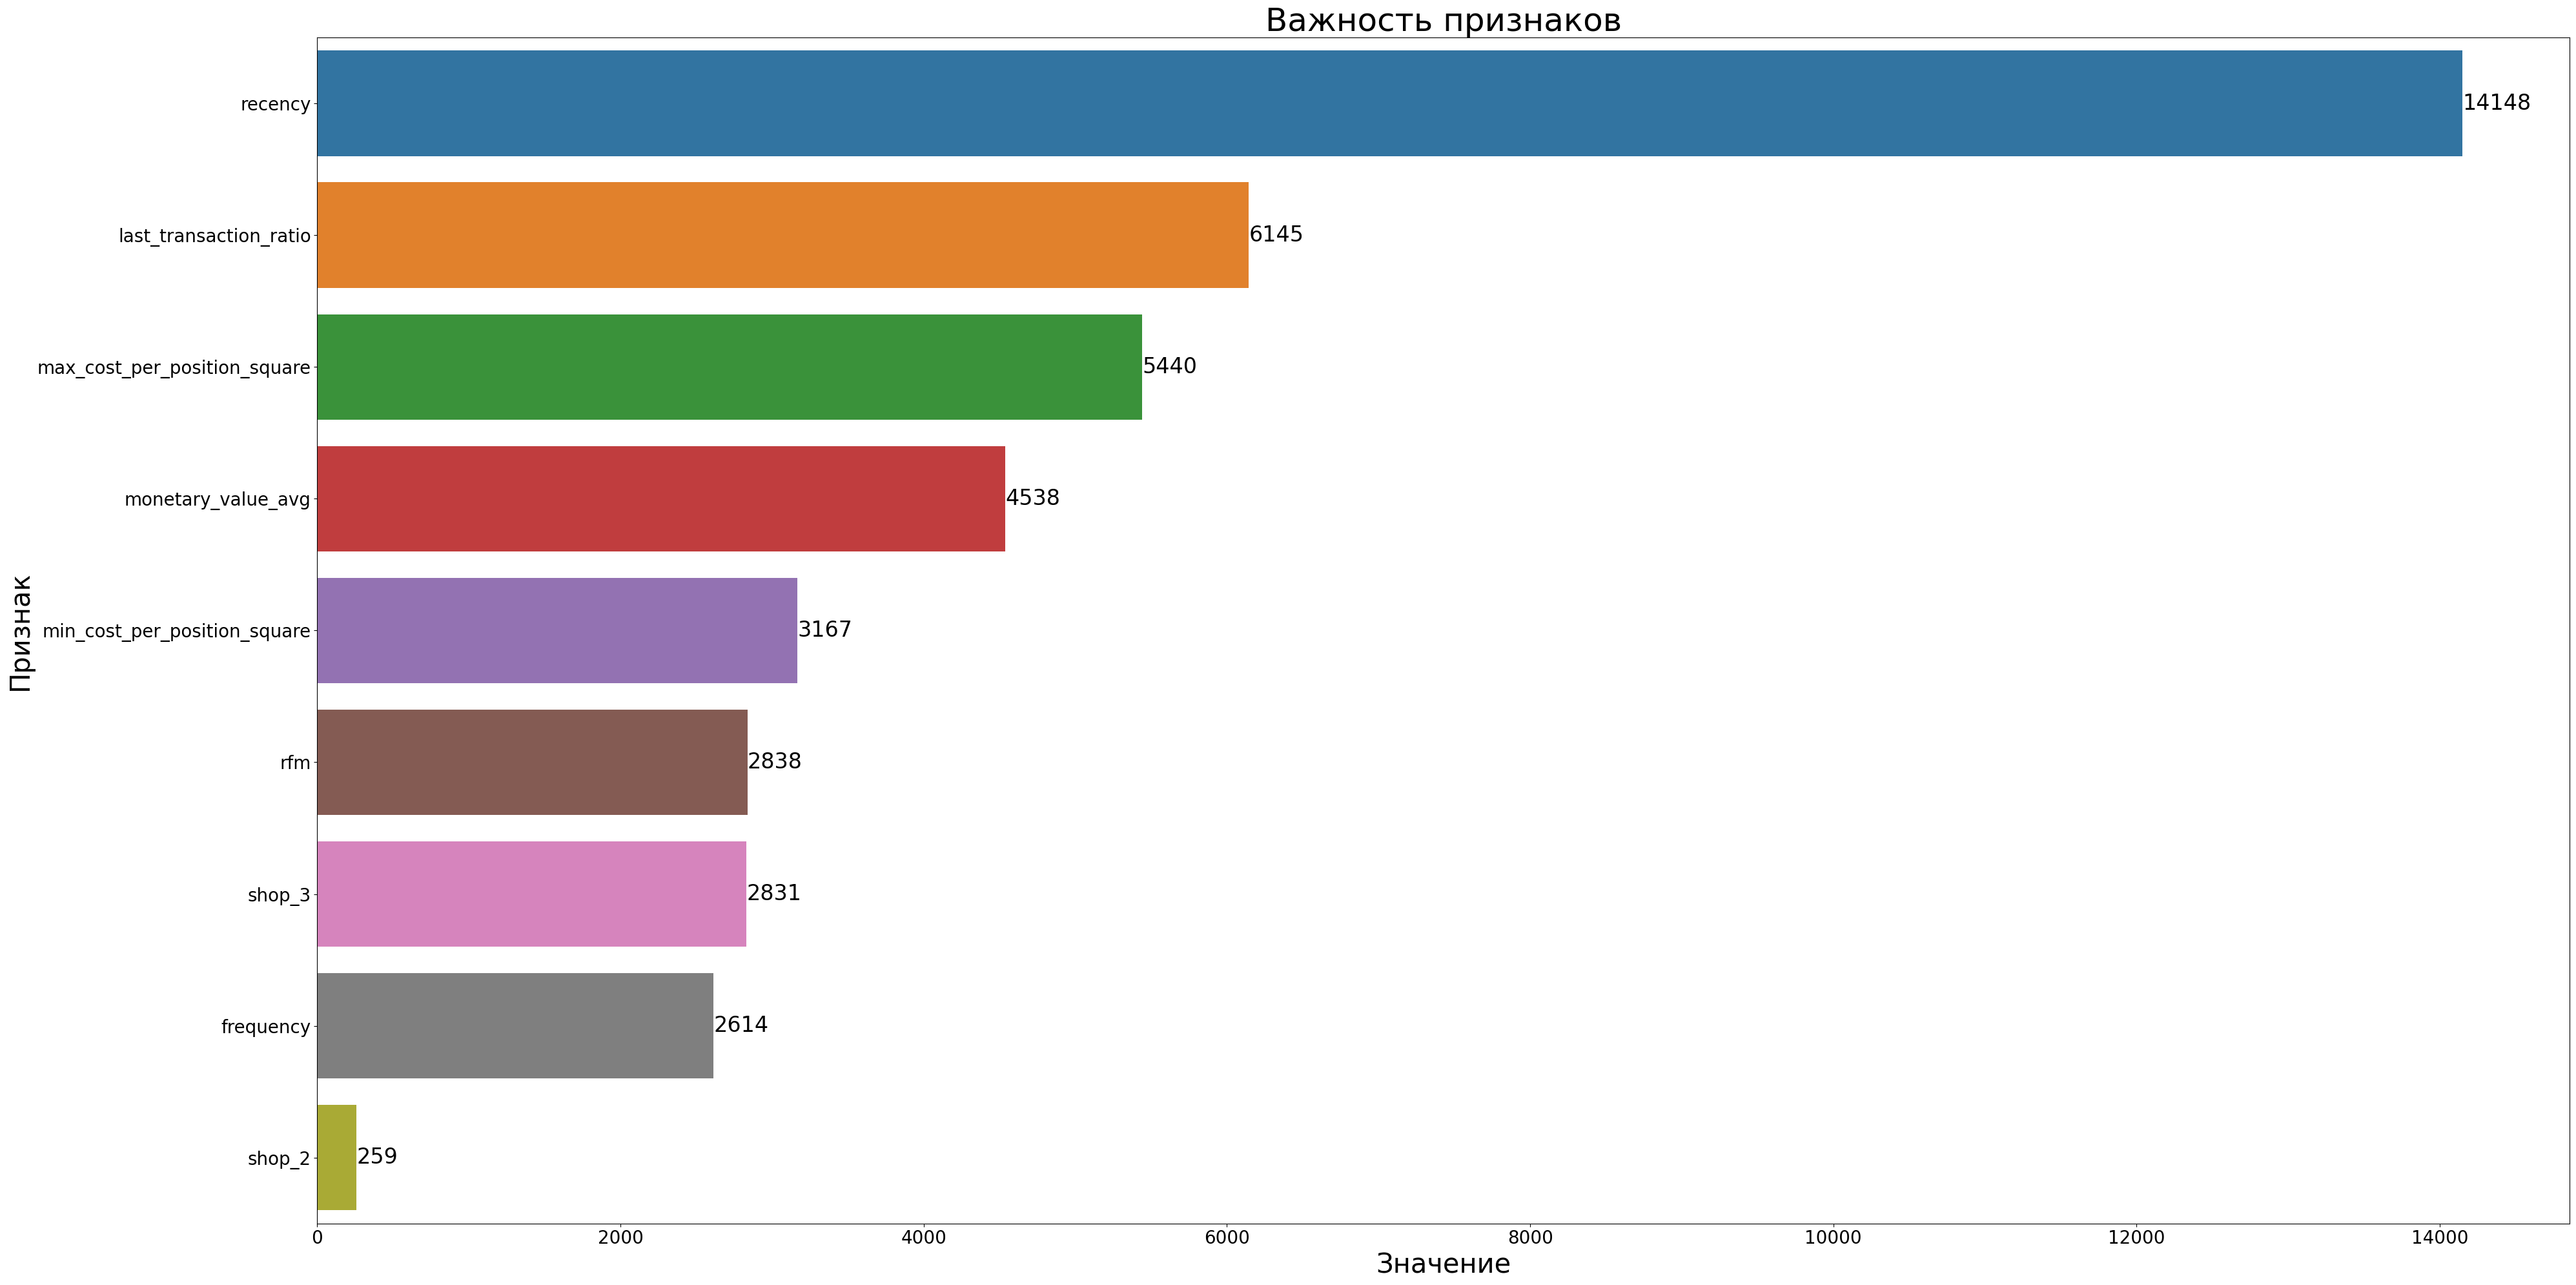

In [54]:
# выводим важность признаков, вызывая метод plot_importance класса GraphicReport
report.plot_importance(
    model=best_model_lgbm_balanced, features=features_train, fig_size=(40, 20)
)

`recency` все так же самый важный, а вот далее признаки начинают меняться местами.

#### `LGBMClassifier` с балансировкой `SMOTETOMEK`

In [55]:
# получаем новые сбалансированные выборки методом oversampling класса ModelOptuna
# балансировка SMOTETOMEK со 100 ближайшими соседями
features_train_smote, target_train_smote = modelling.oversampling(
    features=features_train,
    target=target_train,
    method=SMOTETOMEK(k=100, binary_columns=["shop_3", "shop_2"], seed=RANDOM),
)

Время выполнения: 192.15 секунд(ы)


In [56]:
# выравниваем тип дынных по столбцу "rfm", т.к. при синтетической балансировки тип в трейне
# поменялся на np.float64
features_test["rfm"] = features_test["rfm"].astype(np.float64)

In [57]:
# получаем модель с подобранными оптуной гиперпараметрами c балансировкой Crucio SMOTETOMEK
# вызываем метод get_model_with_best_params класса ModelOptuna
model_lgbm_balanced_smote = modelling.get_model_with_best_params(
    n_trials=5,
    features_train=features_train_smote,
    target_train=target_train_smote,
    model_name="LGBMClassifier",
    fixed_params=fixed_params_lgbm,
    dynamic_or_best_params=params_lgbm_unbalanced,
    metric_for_cv="balanced_accuracy",
)

[I 2024-02-21 18:47:02,114] A new study created in memory with name: LGBMClassifier
[I 2024-02-21 18:47:19,494] Trial 0 finished with value: 0.9778410696060114 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 927, 'max_depth': 5, 'num_leaves': 32, 'min_child_weight': 29.97202267634364, 'subsample': 0.9757033722905775, 'subsample_freq': 7, 'learning_rate': 0.09899802946330918, 'reg_alpha': 2.041568994445536, 'reg_lambda': 3.152541219720587}. Best is trial 0 with value: 0.9778410696060114.
[I 2024-02-21 18:47:30,105] Trial 1 finished with value: 0.9724147346776443 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 541, 'max_depth': 6, 'num_leaves': 37, 'min_child_weight': 57.0459685989543, 'subsample': 0.9152107567263323, 'subsample_freq': 10, 'learning_rate': 0.07847681841413351, 'reg_alpha': 1.9396663511526442, 'reg_lambda': 2.741622318691845}. Best is trial 0 with value: 0.9778410696060114.
[I 2024-02-21 18:49:16,667] Trial 2 finished with value: 0.9260785494183456 and


Лучшие гиперпараметры подобраные Optuna: {'boosting_type': 'gbdt', 'n_estimators': 927, 'max_depth': 5, 'num_leaves': 32, 'min_child_weight': 29.97202267634364, 'subsample': 0.9757033722905775, 'subsample_freq': 7, 'learning_rate': 0.09899802946330918, 'reg_alpha': 2.041568994445536, 'reg_lambda': 3.152541219720587}
Усредненная метрика balanced_accuracy модели на тренировочной выборке с кроссвалидацией: 0.9778410696060114
Время выполнения: 237.3 секунд(ы)


In [58]:
# обучение модели и получение метрики на тесте вызовом метода get_test_results класса ModelOptuna
best_model_lgbm_balanced_smote, _, _, _ = modelling.get_test_results(
    model=model_lgbm_balanced_smote,
    features_train=features_train_smote,
    target_train=target_train_smote,
    features_test=features_test,
    target_test=target_test,
    metric="balanced_accuracy",
)

Метрика BALANCED_ACCURACY модели на тестовой выборке: 0.566854
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7670
         1.0       0.23      0.14      0.18       134

    accuracy                           0.98      7804
   macro avg       0.61      0.57      0.58      7804
weighted avg       0.97      0.98      0.97      7804

Время выполнения: 4.94 секунд(ы)


Матрица ошибок



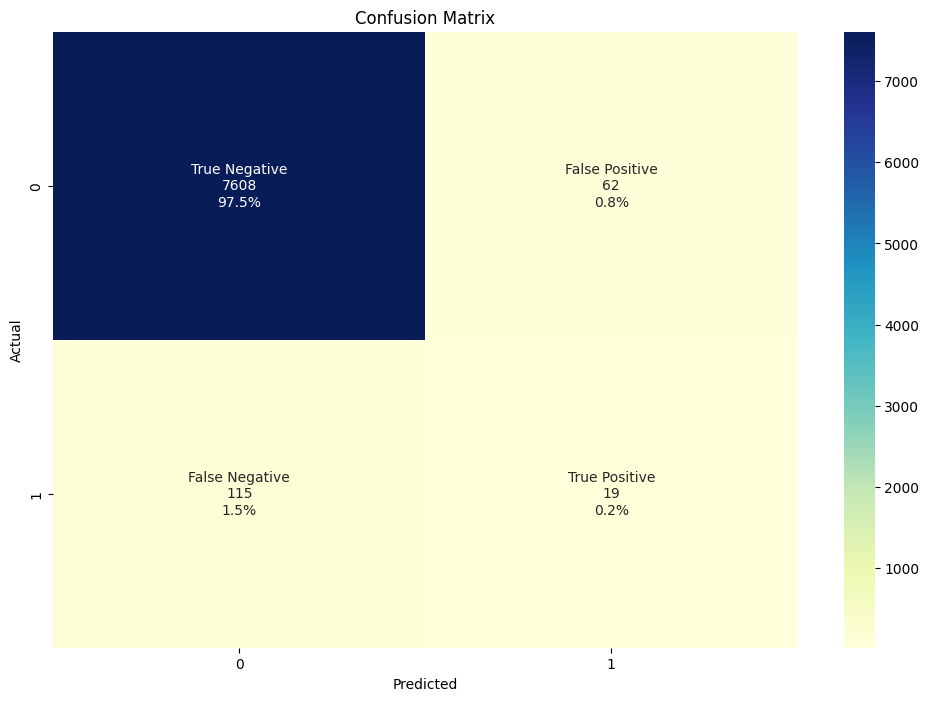

Всего предсказаний: 7804

Правильно предсказанные ответы (Accuracy): 0.9773
Ошибки в прогнозах: 0.0227

Recall: 0.1418
Precision: 0.2346

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 7608 правильных ответов. Не оплаченая заявка определена правильно.
  - TP в правом нижнем углу. 19 правильных ответов. Оплаченая заявка определена правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 62 ошибок ошибочных предсказаний первого рода. Модель определила неоплаченные заявки как оплаченные.
  - FN в левом нижнем углу. 115 ошибочных предсказаний второго рода. Модель определила оплаченные заявки как не оплаченные.


In [59]:
# выводим матрицу ошибок вызовом метода drow_confusion_matrix класса GraphicReport
report.drow_confusion_matrix(
    model=best_model_lgbm_balanced_smote, features=features_test, target=target_test
)

Метрика упала по сравнению с балансировкой на гиперпараметрах с **0.697538** до **0.566854**, `TP` тоже упал.

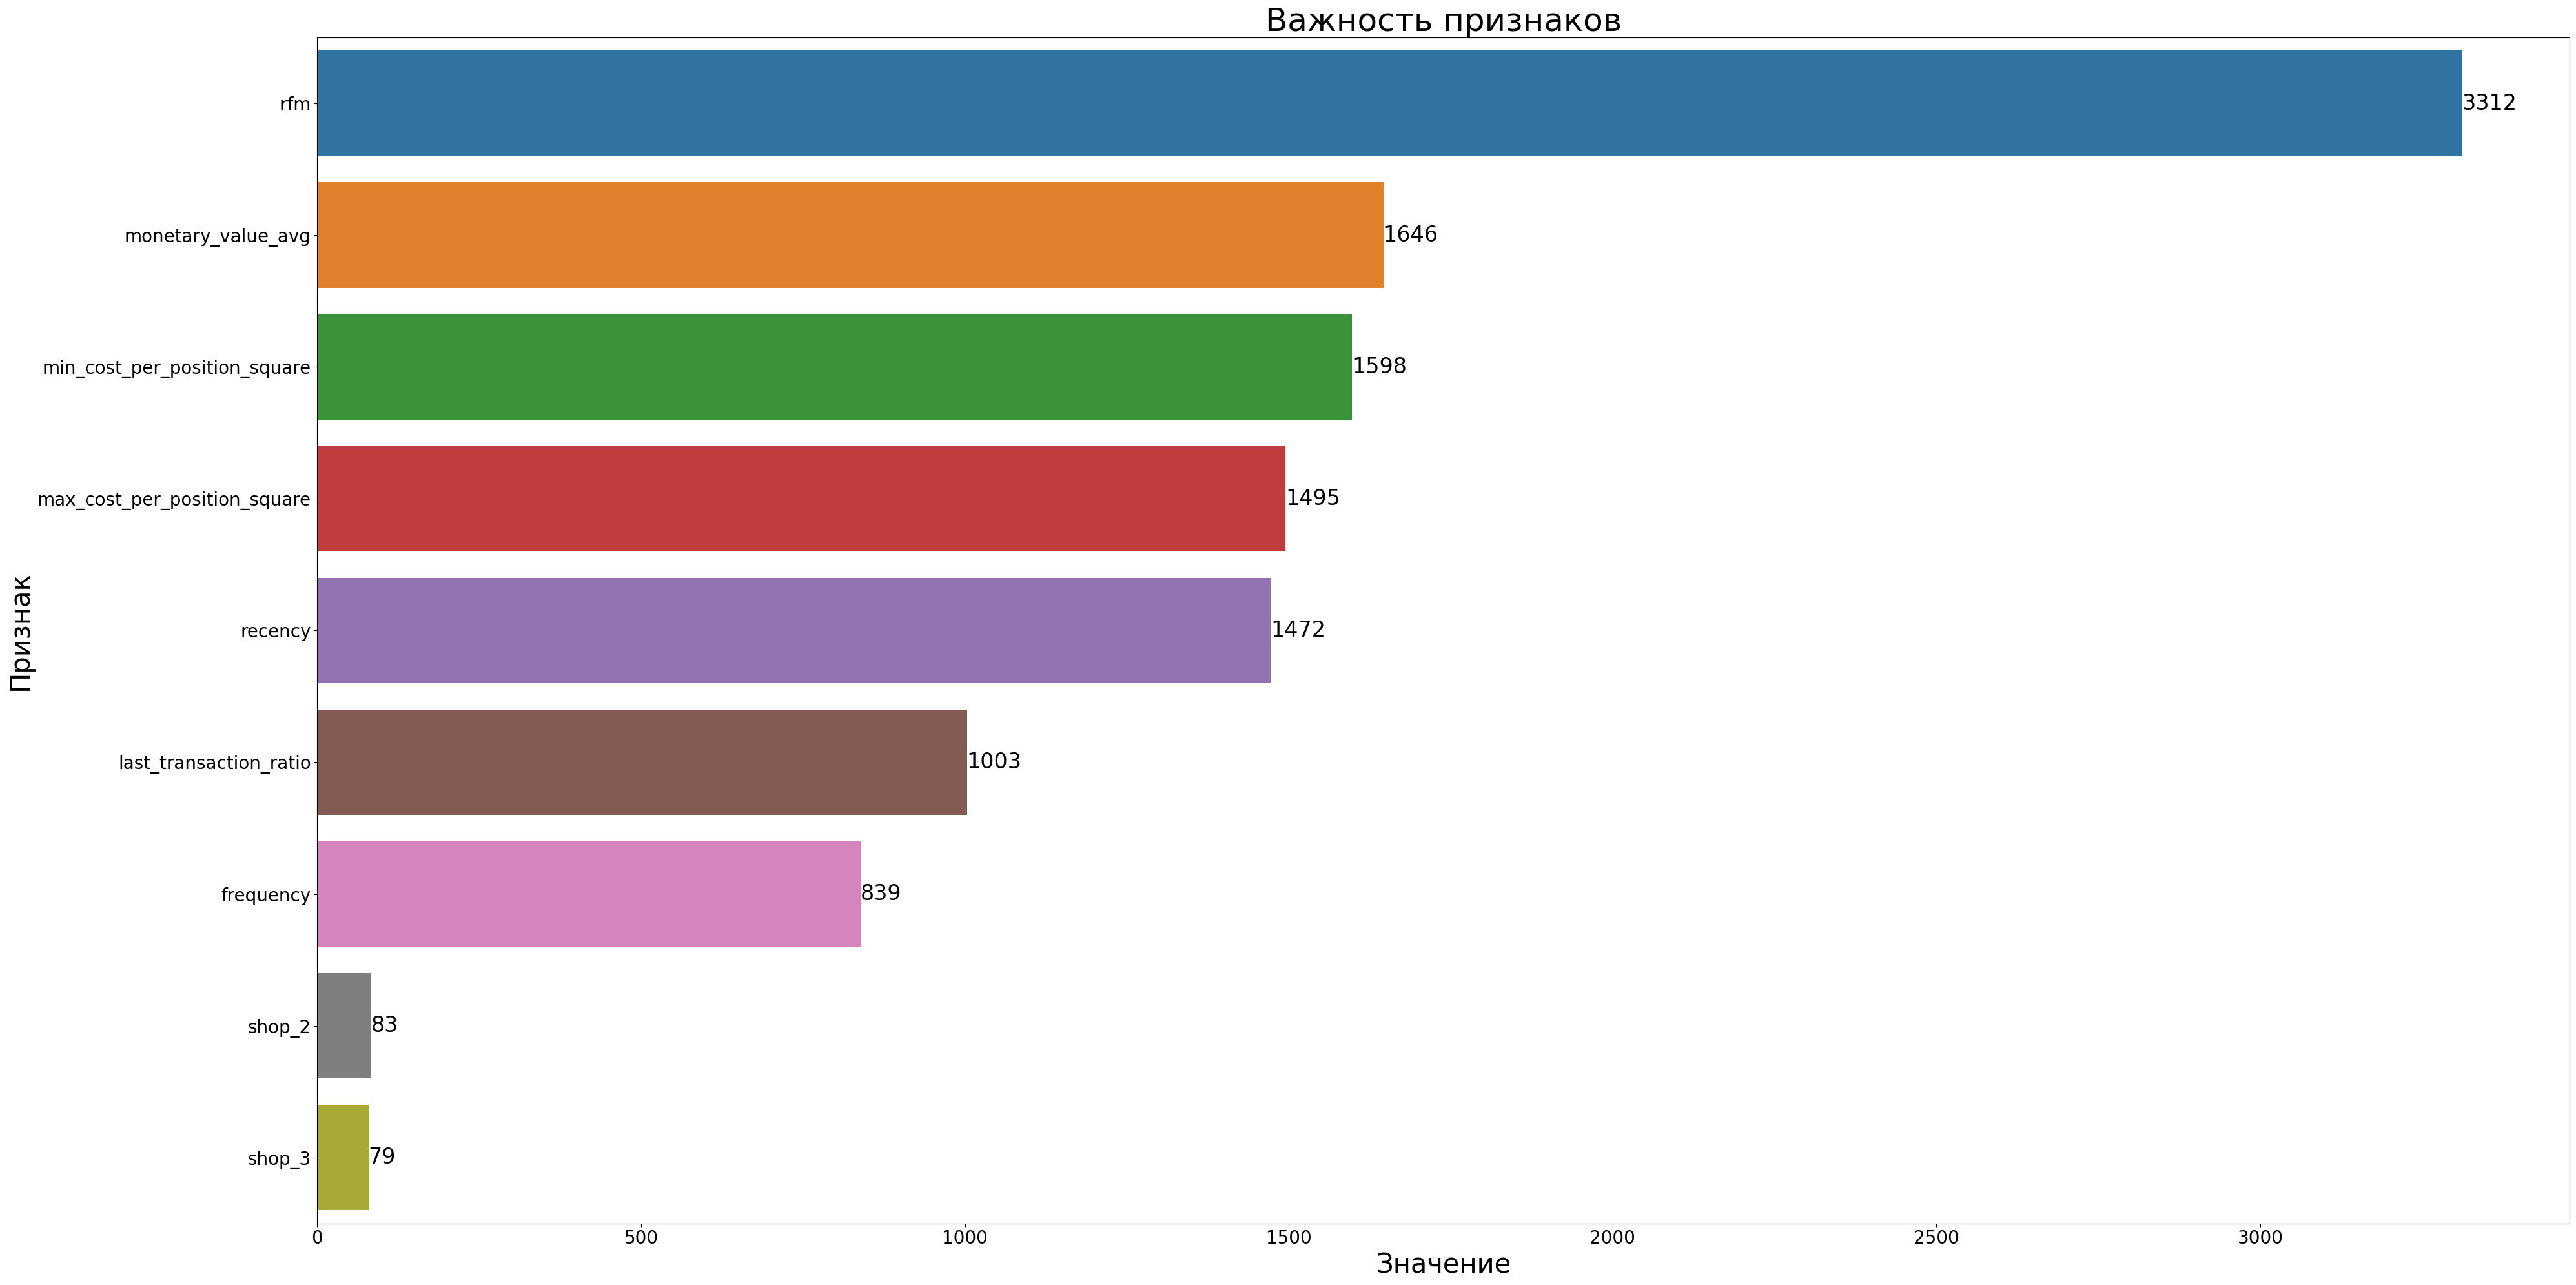

In [60]:
# выводим важность признаков, вызывая метод plot_importance класса GraphicReport
report.plot_importance(
    model=best_model_lgbm_balanced_smote,
    features=features_train_smote,
    fig_size=(40, 20),
)

Для такой балансировки самфй важный признак `rfm`, а `recency` скатился вниз.

## Вывод

В результате исследования была создана модель для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней.

В распоряжении имелись сырые данные с минимальнымм набором признаков. 

В результате был создан единый датасет с деление по магазинам (своего рода магазин с подотделами). 

Сгенерированы дополнительные признаки для дальнейшего исследования такие как:

- `total_sum_position` - сумма по позиции для каждого товара (`quantity` * `price`);
- `activity_duration` - длительность активности: количество дней между первой и последней транзакциями для каждого клиента;
- `last_transaction_ratio` - доля последней покупки в общем перечне покупок;
- `recency` - давность последней покуки;
- `first_recency` - давность первой покупки;
- `frequency` - частота покупок;
- `min_cost_per_position` - минимальная цена за товар;
- `max_cost_per_position` - максимальная цена за товар;
- `monetary_value` - общая потраченная сумма;
- `monetary_value_avg` - средняя потраченная сумма за покупку;
- `avg_recency` - средняя давность между покупками;
- `rfm` - RFM-сегментация клиента.

Помимо этого созданы вариации этих признаков для увеличения влияния на целевую переменную.

Протестированы варианты модели `LGBMClassifier` с дефолтными параметрами, подбором гиперпараметров без балансировки и с балансировкой, а так же балансировкой `SMOTETOMEK`.

Проведен автоматический селективный отбор лучших признаков влияющих на модель.

В качестве метрики была выбрана **сбалансированная точность** (`Balanced Accuracy`)

В результате удалось увеличить метрику с **0.532735** на дефолтной модели до **0.697538** на модели с подбором гиперпараметров балансирующих целевой признак.

Как оптимальный вариант рекомендуется рассмотреть модель с подбором гиперпараметров балансирующих целевой признак. Эта модель видит наибольшее количество целевого признака, что соответсвует целям. При этом увеличивается количетво ложных позитивов, но на эту ситуацию можно посмотреть с другой стороны. Например разослать данным клиентам промокоды на скидки и т.п., чтобы вернуть данных клиентов обратно в магазин.